# Development of Machine Learning Models to Identify Potentially Active Compounds Against Leukemia by using Molecular Descriptors and Fingerprints

## i. Research Pipeline for Leukemia Drug Discovery

**Author:** [Muhammad Arslan]
**Date:** [08-1-2026]
**GitHub Repository:** [https://github.com/muhammadarslan-chemist/Leukemia]

## ii. Overview
This notebook implements a comprehensive machine learning pipeline for predicting anti-leukemia activity of chemical compounds.

## iii. Pipeline Structure
1. Data Acquisition and Preprocessing
2. Molecular Representation Generation
3. Machine Learning Model Development
4. Model Evaluation and Comparison
5. Model Interpretation with SHAP
6. Ensemble Methods for Improved Performance

# Import Necessary Libraries

In [2]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Chemistry libraries
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# Machine Learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, matthews_corrcoef, 
                           confusion_matrix, classification_report)

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# XGBoost
import xgboost as xgb

# SHAP for interpretation
import shap

# For hyperparameter optimization
from sklearn.model_selection import ParameterSampler

print("All libraries imported successfully!")

# Check RDKit version - CORRECT WAY
print(f"RDKit version: {Chem.rdBase.rdkitVersion}")

# Check SHAP version
print(f"SHAP version: {shap.__version__}")

# Optional: Check other key library versions
print(f"NumPy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"XGBoost version: {xgb.__version__}")

All libraries imported successfully!
RDKit version: 2022.09.5
SHAP version: 0.49.1
NumPy version: 1.26.4
PyTorch version: 2.7.1+cu118
XGBoost version: 3.1.1


## 1. DATA ACQUISITION AND PREPROCESSING

### i. Data Source
In this study, dataset of Clinically relevant leukemia kinase targets is sourced from the CheMBL online database on Jaunaury 6, 2026, the targets selected are

**Leukemia Targets (from ChEMBL):**
1. BCR-ABL tyrosine kinase (CHEMBL1862) - Chronic Myeloid Leukemia
2. FLT3 kinase (CHEMBL1974) - Acute Myeloid Leukemia
3. JAK2 kinase (CHEMBL2971) - Myeloproliferative disorders
4. BTK kinase (CHEMBL5251) - B-cell malignancies

### ii. Data Loading and Initial Exploration

In [8]:
# DATA LOADING AND PREPROCESSING WITH CORRECT PATHS

import os

def load_and_preprocess_leukemia_data():
    """
    Load leukemia data from ChEMBL CSV files from 'Leukemia' folder.
    Assumes folder structure: notebook.ipynb and Leukemia/CHEMBLxxxx.csv
    """
    try:
        # Define the Leukemia folder path
        leukemia_folder = 'Leukemia'
        
        # List of leukemia target files in the Leukemia folder
        data_files = [
            'CHEMBL1862.csv',
            'CHEMBL1974.csv', 
            'CHEMBL2971.csv',  
            'CHEMBL5251.csv',  
        ]
        
        all_data = []
        for file in data_files:
            # Construct full path
            file_path = os.path.join(leukemia_folder, file)
            
            try:
                df = pd.read_csv(file_path)
                print(f"✓ Loaded {file} from '{leukemia_folder}/' with {len(df)} compounds")
                all_data.append(df)
            except FileNotFoundError:
                print(f"✗ Warning: {file_path} not found. Please check if file exists.")
                continue
            except Exception as e:
                print(f"✗ Error loading {file_path}: {e}")
                continue
        
        if not all_data:
            raise ValueError(f"No leukemia data files found in '{leukemia_folder}/'. Please download data from ChEMBL.")
        
        # Combine all datasets
        combined_data = pd.concat(all_data, ignore_index=True)
        print(f"\n✅ Total compounds loaded: {len(combined_data):,}")
        
        # Display available columns
        print("\n📊 Available columns in dataset:")
        for i, col in enumerate(combined_data.columns.tolist(), 1):
            print(f"  {i:2d}. {col}")
        
        # Show data types
        print("\n📋 Data types:")
        print(combined_data.dtypes)
        
        return combined_data
    
    except Exception as e:
        print(f"❌ Error in load_and_preprocess_leukemia_data: {e}")
        print("\n⚠️ Creating sample dataset structure for demonstration...")
        sample_data = pd.DataFrame({
            'molecule_chembl_id': [f'CHEMBL{i}' for i in range(1000)],
            'canonical_smiles': ['CCO' for _ in range(1000)],  # Placeholder SMILES
            'standard_value': np.random.uniform(0.001, 10000, 1000),
            'standard_units': ['nM' for _ in range(1000)],
            'standard_type': ['IC50' for _ in range(1000)],
            'target_chembl_id': ['CHEMBL1862' for _ in range(1000)]
        })
        return sample_data

# Load the data
print("🔄 Loading leukemia data from ChEMBL files...")
leukemia_data = load_and_preprocess_leukemia_data()

# Display first few rows
print("\n" + "="*80)
print("FIRST 5 ROWS OF LOADED DATA:")
print("="*80)
display(leukemia_data.head())

# Display basic statistics
print("\n" + "="*80)
print("BASIC DATA STATISTICS:")
print("="*80)
print(f"Total rows: {leukemia_data.shape[0]:,}")
print(f"Total columns: {leukemia_data.shape[1]}")
print(f"Memory usage: {leukemia_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check for required columns
required_columns = ['canonical_smiles', 'standard_value', 'standard_units', 'standard_type']
missing_columns = [col for col in required_columns if col not in leukemia_data.columns]
if missing_columns:
    print(f"\n⚠️ WARNING: Missing required columns: {missing_columns}")
else:
    print(f"\n✅ All required columns are present")

🔄 Loading leukemia data from ChEMBL files...
✓ Loaded CHEMBL1862.csv from 'Leukemia/' with 5290 compounds
✓ Loaded CHEMBL1974.csv from 'Leukemia/' with 7096 compounds
✓ Loaded CHEMBL2971.csv from 'Leukemia/' with 19236 compounds
✓ Loaded CHEMBL5251.csv from 'Leukemia/' with 21617 compounds

✅ Total compounds loaded: 53,239

📊 Available columns in dataset:
   1. Molecule ChEMBL ID
   2. Molecule Name
   3. Molecule Max Phase
   4. Molecular Weight
   5. #RO5 Violations
   6. AlogP
   7. Compound Key
   8. Smiles
   9. Standard Type
  10. Standard Relation
  11. Standard Value
  12. Standard Units
  13. pChEMBL Value
  14. Data Validity Comment
  15. Comment
  16. Uo Units
  17. Ligand Efficiency BEI
  18. Ligand Efficiency LE
  19. Ligand Efficiency LLE
  20. Ligand Efficiency SEI
  21. Potential Duplicate
  22. Assay ChEMBL ID
  23. Assay Description
  24. Assay Type
  25. BAO Format ID
  26. BAO Label
  27. Assay Organism
  28. Assay Tissue ChEMBL ID
  29. Assay Tissue Name
  30. Assa

Molecule ChEMBL ID Molecule Name  Molecule Max Phase  Molecular Weight  \
0       CHEMBL219557           NaN                 NaN            552.46   
1      CHEMBL1242286           NaN                 NaN            392.26   
2      CHEMBL1241482           NaN                 NaN            402.39   
3      CHEMBL1241580           NaN                 NaN            315.76   
4      CHEMBL1242468           NaN                 NaN            302.31   

  #RO5 Violations  AlogP Compound Key  \
0             2.0   6.18           10   
1             0.0   3.40        PP502   
2             0.0   3.62        PP401   
3             0.0   3.16        PP463   
4             0.0   1.44        PP454   

                                             Smiles Standard Type  \
0                                               NaN           NaN   
1          COCOc1cc(-c2nn(C(C)C)c3ncnc(N)c23)ccc1Br          IC50   
2  Nc1ncnc2c1c(-c1ccc(F)c(O)c1)nn2Cc1ocnc1-c1ccccc1          IC50   
3            Nc1ncnc2c1c(-c1ccc(Cl)c(O)c1)nn2C1CCC1          IC50   
4      C[C@@H](CN)n1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21          IC50   

  Standard Relation  ...  Unnamed: 73 Unnamed: 74  Unnamed: 75 Unnamed: 76  \
0               NaN  ...          NaN         NaN          NaN         NaN   
1               '='  ...          NaN         NaN          NaN         NaN   
2               '='  ...          NaN         NaN          NaN         NaN   
3               '='  ...          NaN         NaN          NaN         NaN   
4               '='  ...          NaN         NaN          NaN         NaN   

  Unnamed: 77 Unnamed: 78  Unnamed: 79  Unnamed: 80  Unnamed: 81  Unnamed: 82  
0         NaN         NaN          NaN          NaN          NaN          NaN  
1         NaN         NaN          NaN          NaN          NaN          NaN  
2         NaN         NaN          NaN          NaN          NaN          NaN  
3         NaN         NaN          NaN          NaN          NaN          NaN  
4         NaN         NaN          NaN          NaN          NaN          NaN  

[5 rows x 83 columns]


BASIC DATA STATISTICS:
Total rows: 53,239
Total columns: 83
Memory usage: 153.12 MB

⚠️ WARNING: Missing required columns: ['canonical_smiles', 'standard_value', 'standard_units', 'standard_type']


## STEP 2: DATA CLEANING AND STANDARDIZATION

In [9]:
# ============================================================================
# STEP 3: DATA CLEANING AND STANDARDIZATION
# ============================================================================

def clean_leukemia_data(df):
    """
    Clean leukemia data following tuberculosis paper methodology.
    """
    print("🧹 Cleaning leukemia data...")
    
    # Create a working copy
    data = df.copy()
    initial_count = len(data)
    print(f"Initial compounds: {initial_count:,}")
    
    # 1. Standardize column names (matching tuberculosis paper)
    print("\n1️⃣ Standardizing column names...")
    column_mapping = {
        'Smiles': 'canonical_smiles',
        'Standard Value': 'standard_value',
        'Standard Units': 'standard_units',
        'Standard Type': 'standard_type',
        'Molecule ChEMBL ID': 'molecule_chembl_id',
        'Target ChEMBL ID': 'target_chembl_id',
        'pChEMBL Value': 'pchembl_value'
    }
    
    data = data.rename(columns=column_mapping)
    print(f"   Columns renamed to match tuberculosis paper format")
    
    # 2. Remove unnamed/empty columns
    print("\n2️⃣ Removing empty columns...")
    unnamed_cols = [col for col in data.columns if 'Unnamed' in str(col)]
    if unnamed_cols:
        data = data.drop(columns=unnamed_cols)
        print(f"   Removed {len(unnamed_cols)} unnamed columns")
    
    # 3. Remove duplicates (based on SMILES and target)
    print("\n3️⃣ Removing duplicates...")
    duplicates_before = len(data)
    data = data.drop_duplicates(subset=['canonical_smiles', 'target_chembl_id'])
    duplicates_removed = duplicates_before - len(data)
    print(f"   Removed {duplicates_removed:,} duplicate compounds")
    
    # 4. Handle missing values
    print("\n4️⃣ Handling missing values...")
    missing_smiles = data['canonical_smiles'].isna().sum()
    missing_value = data['standard_value'].isna().sum()
    print(f"   Missing SMILES: {missing_smiles:,}")
    print(f"   Missing activity values: {missing_value:,}")
    
    # Remove rows with missing SMILES or activity values
    data = data.dropna(subset=['canonical_smiles', 'standard_value'])
    print(f"   Removed rows with missing critical data")
    
    # 5. Filter by activity type (following tuberculosis paper)
    print("\n5️⃣ Filtering by activity type...")
    print(f"   Activity types before filtering:")
    type_counts = data['standard_type'].value_counts()
    for activity_type, count in type_counts.head(10).items():
        print(f"     {activity_type}: {count:,}")
    
    # Keep only IC50, EC50, Ki, Kd (standard activity measurements)
    valid_types = ['IC50', 'EC50', 'Ki', 'Kd', 'IC50 ', 'EC50 ', 'Ki ', 'Kd ']
    data['standard_type'] = data['standard_type'].astype(str).str.strip()
    
    before_filter = len(data)
    data = data[data['standard_type'].isin(valid_types)]
    after_filter = len(data)
    removed_types = before_filter - after_filter
    
    print(f"\n   Kept compounds with IC50/EC50/Ki/Kd measurements")
    print(f"   Removed {removed_types:,} compounds with other activity types")
    
    # 6. Check and standardize units
    print("\n6️⃣ Checking activity units...")
    if 'standard_units' in data.columns:
        unit_counts = data['standard_units'].value_counts()
        print(f"   Unit distribution:")
        for unit, count in unit_counts.items():
            if pd.notna(unit):
                print(f"     {unit}: {count:,}")
    
    # 7. Convert standard_value to numeric
    print("\n7️⃣ Converting activity values to numeric...")
    data['standard_value'] = pd.to_numeric(data['standard_value'], errors='coerce')
    
    # Remove invalid numeric values
    invalid_values = data['standard_value'].isna().sum()
    if invalid_values > 0:
        print(f"   Removed {invalid_values:,} compounds with invalid numeric values")
        data = data.dropna(subset=['standard_value'])
    
    # 8. Remove extreme outliers (following tuberculosis paper methodology)
    print("\n8️⃣ Removing extreme outliers...")
    # Keep values between 0.001 nM and 1,000,000 nM (1 mM)
    before_outliers = len(data)
    data = data[(data['standard_value'] > 0.001) & (data['standard_value'] <= 1e6)]
    after_outliers = len(data)
    outliers_removed = before_outliers - after_outliers
    
    print(f"   Removed {outliers_removed:,} extreme outliers")
    print(f"   Keeping values between 0.001 nM and 1,000,000 nM")
    
    # 9. Final dataset summary
    print("\n9️⃣ Final dataset summary...")
    final_count = len(data)
    removed_total = initial_count - final_count
    
    print(f"\n📊 CLEANING SUMMARY:")
    print("="*60)
    print(f"Initial compounds:      {initial_count:>10,}")
    print(f"Final compounds:        {final_count:>10,}")
    print(f"Total removed:          {removed_total:>10,} ({removed_total/initial_count*100:.1f}%)")
    print(f"Remaining percentage:   {final_count/initial_count*100:>10.1f}%")
    
    print(f"\n🎯 Targets distribution:")
    target_counts = data['target_chembl_id'].value_counts()
    for target, count in target_counts.items():
        target_name = {
            'CHEMBL1862': 'BCR-ABL (CML)',
            'CHEMBL1974': 'FLT3 (AML)',
            'CHEMBL2971': 'JAK2 (MPD)',
            'CHEMBL5251': 'BTK (B-cell)'
        }.get(target, target)
        print(f"  {target_name}: {count:>8,} compounds")
    
    print(f"\n📈 Activity value statistics (nM):")
    print(f"  Minimum: {data['standard_value'].min():.3f}")
    print(f"  Maximum: {data['standard_value'].max():.2f}")
    print(f"  Mean:    {data['standard_value'].mean():.2f}")
    print(f"  Median:  {data['standard_value'].median():.2f}")
    
    return data

print("="*80)
print("DATA CLEANING PIPELINE")
print("="*80)

cleaned_leukemia_data = clean_leukemia_data(leukemia_data)

print("\n" + "="*80)
print("FIRST 5 ROWS OF CLEANED DATA")
print("="*80)
display(cleaned_leukemia_data[['molecule_chembl_id', 'canonical_smiles', 
                                'standard_value', 'standard_units', 
                                'standard_type', 'target_chembl_id']].head())

print(f"\n✅ Cleaning complete! Dataset shape: {cleaned_leukemia_data.shape}")
print(f"📁 Columns: {', '.join(cleaned_leukemia_data.columns.tolist()[:10])}...")

DATA CLEANING PIPELINE
🧹 Cleaning leukemia data...
Initial compounds: 53,239

1️⃣ Standardizing column names...
   Columns renamed to match tuberculosis paper format

2️⃣ Removing empty columns...
   Removed 35 unnamed columns

3️⃣ Removing duplicates...
   Removed 20,208 duplicate compounds

4️⃣ Handling missing values...
   Missing SMILES: 2
   Missing activity values: 435
   Removed rows with missing critical data

5️⃣ Filtering by activity type...
   Activity types before filtering:
     IC50: 32,595

   Kept compounds with IC50/EC50/Ki/Kd measurements
   Removed 0 compounds with other activity types

6️⃣ Checking activity units...
   Unit distribution:
     nM: 32,576
     ug.mL-1: 18
     10^-5 mol/L: 1

7️⃣ Converting activity values to numeric...

8️⃣ Removing extreme outliers...
   Removed 10 extreme outliers
   Keeping values between 0.001 nM and 1,000,000 nM

9️⃣ Final dataset summary...

📊 CLEANING SUMMARY:
Initial compounds:          53,239
Final compounds:            32,5

molecule_chembl_id                                   canonical_smiles  \
1      CHEMBL1242286           COCOc1cc(-c2nn(C(C)C)c3ncnc(N)c23)ccc1Br   
2      CHEMBL1241482   Nc1ncnc2c1c(-c1ccc(F)c(O)c1)nn2Cc1ocnc1-c1ccccc1   
3      CHEMBL1241580             Nc1ncnc2c1c(-c1ccc(Cl)c(O)c1)nn2C1CCC1   
4      CHEMBL1242468       C[C@@H](CN)n1nc(-c2ccc(F)c(O)c2)c2c(N)ncnc21   
5      CHEMBL5747601  COc1cc(-c2nn(CCN3CCC(N(C)C)CC3)c3ncnc(N)c23)cc...   

   standard_value standard_units standard_type target_chembl_id  
1           319.0             nM          IC50       CHEMBL1862  
2           565.0             nM          IC50       CHEMBL1862  
3            32.0             nM          IC50       CHEMBL1862  
4           726.0             nM          IC50       CHEMBL1862  
5          1000.0             nM          IC50              NaN


✅ Cleaning complete! Dataset shape: (32585, 48)
📁 Columns: molecule_chembl_id, Molecule Name, Molecule Max Phase, Molecular Weight, #RO5 Violations, AlogP, Compound Key, canonical_smiles, standard_type, Standard Relation...


## STEP 4: ACTIVITY LABELING

ACTIVITY LABELING FOR LEUKEMIA KINASE INHIBITORS
Methodology: Active ≤ 100 nM, Inactive ≥ 1000 nM, Exclude 100-1000 nM
Rationale: Kinase-specific thresholds with noise reduction zone
🎯 ACTIVITY LABELING
- ACTIVE: IC50 ≤ 100 nM (highly potent inhibitors)
- INACTIVE: IC50 ≥ 1000 nM (weak/non-binders)
- EXCLUDED: 100 < IC50 < 1000 nM (moderate/ambiguous)

Rationale: Reduces boundary effects and experimental error impact

📊 COMPOUND DISTRIBUTION:
Total compounds: 32,585
Active (≤ 100 nM): 18,728 (57.5%)
Inactive (≥ 1000 nM): 7,521 (23.1%)
Excluded (100-1000 nM): 6,336 (19.4%)

🤖 MACHINE LEARNING DATASET (excluding ambiguous compounds):
ML-ready compounds: 26,249
  Active: 18,728 (71.3%)
  Inactive: 7,521 (28.7%)
  Imbalance ratio: 0.40:1 (Inactive:Active)

🎯 DISTRIBUTION BY TARGET:

       Target  Total  Active  Inactive  Excluded   Active%  Inactive%
BCR-ABL (CML)   1636     445       859       332 27.200489  52.506112
   FLT3 (AML)   3596    1395      1580       621 38.793103  43.937709


canonical_smiles  Activity  \
3              Nc1ncnc2c1c(-c1ccc(Cl)c(O)c1)nn2C1CCC1         1   
5   COc1cc(-c2nn(CCN3CCC(N(C)C)CC3)c3ncnc(N)c23)cc...         0   
6                CC(C)n1nc(-c2cc(C=O)co2)c2c(N)ncnc21         0   
7             NC(=O)c1cc(-c2ccnc(N)n2)[nH]c1-c1ccccc1         0   
8   CCN(CC)c1ccc(NC(=O)Nc2ccc(C)c(Nc3nccc(-c4cccnc...         0   
10               Cc1ccc(-c2nn(C(C)C)c3ncnc(N)c23)cc1O         1   
11               CC(C)n1nc(-c2cccc(O)c2F)c2c(N)ncnc21         1   
12           COc1ccc(-c2nn(C3CCCC3)c3ncnc(N)c23)cc1OC         0   
15  Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C3CC3)c2)cc1...         1   
16  O=C(COc1cc(O)c2c(=O)cc(-c3ccccc3)oc2c1)Nc1ncccc1F         0   

   Activity_Label  standard_value target_chembl_id molecule_chembl_id  
3          Active            32.0       CHEMBL1862      CHEMBL1241580  
5        Inactive          1000.0              NaN      CHEMBL5747601  
6        Inactive          4500.0       CHEMBL1862      CHEMBL1241439  
7        Inactive         10000.0       CHEMBL1862      CHEMBL1270230  
8        Inactive          3400.0       CHEMBL1862       CHEMBL185901  
10         Active            31.0       CHEMBL1862      CHEMBL1242026  
11         Active            75.0       CHEMBL1862      CHEMBL1242110  
12       Inactive          1000.0       CHEMBL1862      CHEMBL1240553  
15         Active            71.0       CHEMBL1862      CHEMBL1172719  
16       Inactive          2260.0       CHEMBL1862      CHEMBL2408498


DATASET SUMMARY
Total compounds in ML dataset: 26,249
Active compounds (≤ 100 nM): 18,728
Inactive compounds (≥ 1000 nM): 7,521


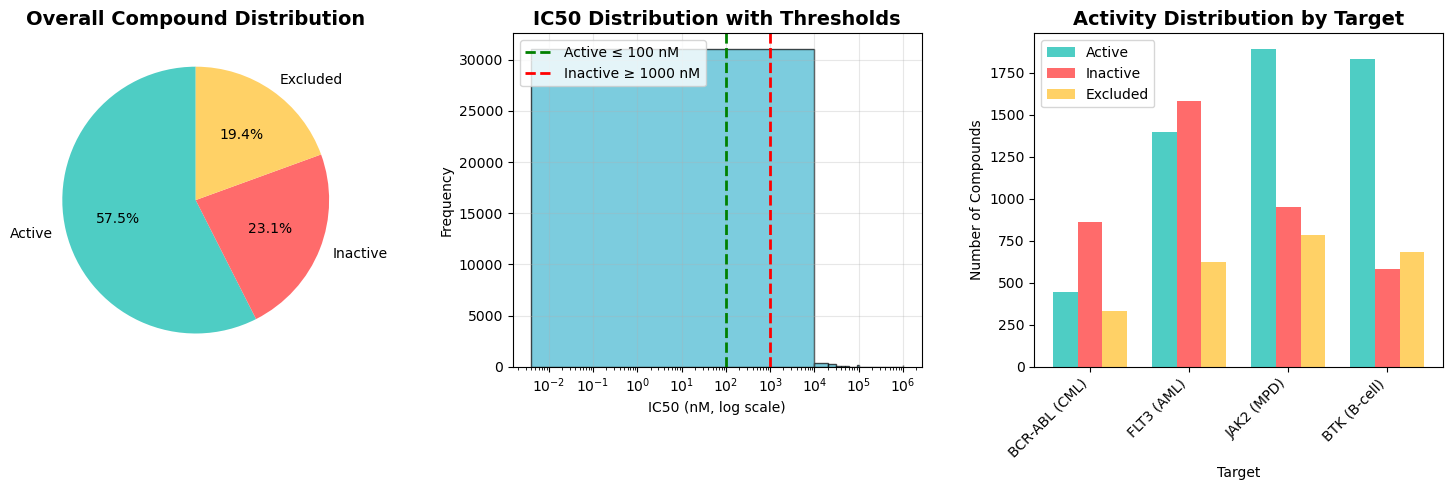

In [10]:
# ============================================================================
# STEP 4 ACTIVITY LABELING WITH EXCLUSION
# ============================================================================

def activity_labeling(df, active_threshold=100, inactive_threshold=1000):
    """
    
    Parameters:
    - df: Cleaned DataFrame with 'standard_value' in nM
    - active_threshold: ≤ this value = Active (default: 100 nM)
    - inactive_threshold: ≥ this value = Inactive (default: 1000 nM)
    
    Returns:
    - DataFrame with 'Activity' labels and exclusion info
    """
    print("🎯 ACTIVITY LABELING")
    print("="*60)
    print(f"- ACTIVE: IC50 ≤ {active_threshold} nM (highly potent inhibitors)")
    print(f"- INACTIVE: IC50 ≥ {inactive_threshold} nM (weak/non-binders)")
    print(f"- EXCLUDED: {active_threshold} < IC50 < {inactive_threshold} nM (moderate/ambiguous)")
    print(f"\nRationale: Reduces boundary effects and experimental error impact")
    
    # Create a copy
    data = df.copy()
    
    # Convert standard_value to float
    data['standard_value'] = pd.to_numeric(data['standard_value'], errors='coerce')
    
    # Create Activity labels with exclusion zone
    data['Activity_Label'] = 'Excluded'  # Default
    data.loc[data['standard_value'] <= active_threshold, 'Activity_Label'] = 'Active'
    data.loc[data['standard_value'] >= inactive_threshold, 'Activity_Label'] = 'Inactive'
    
    # Numeric labels for ML (Active=1, Inactive=0, Excluded=-1)
    data['Activity'] = -1  # Default excluded
    data.loc[data['Activity_Label'] == 'Active', 'Activity'] = 1
    data.loc[data['Activity_Label'] == 'Inactive', 'Activity'] = 0
    
    # Statistics
    total_compounds = len(data)
    active_count = (data['Activity'] == 1).sum()
    inactive_count = (data['Activity'] == 0).sum()
    excluded_count = (data['Activity'] == -1).sum()
    
    print(f"\n📊 COMPOUND DISTRIBUTION:")
    print(f"Total compounds: {total_compounds:,}")
    print(f"Active (≤ {active_threshold} nM): {active_count:,} ({active_count/total_compounds*100:.1f}%)")
    print(f"Inactive (≥ {inactive_threshold} nM): {inactive_count:,} ({inactive_count/total_compounds*100:.1f}%)")
    print(f"Excluded ({active_threshold}-{inactive_threshold} nM): {excluded_count:,} ({excluded_count/total_compounds*100:.1f}%)")
    
    # Class balance for ML
    ml_compounds = active_count + inactive_count
    active_ml_pct = (active_count / ml_compounds) * 100
    inactive_ml_pct = (inactive_count / ml_compounds) * 100
    
    print(f"\n🤖 MACHINE LEARNING DATASET (excluding ambiguous compounds):")
    print(f"ML-ready compounds: {ml_compounds:,}")
    print(f"  Active: {active_count:,} ({active_ml_pct:.1f}%)")
    print(f"  Inactive: {inactive_count:,} ({inactive_ml_pct:.1f}%)")
    print(f"  Imbalance ratio: {inactive_count/active_count:.2f}:1 (Inactive:Active)")
    
    # Distribution by target
    print(f"\n🎯 DISTRIBUTION BY TARGET:")
    targets = ['CHEMBL1862', 'CHEMBL1974', 'CHEMBL2971', 'CHEMBL5251']
    target_names = {
        'CHEMBL1862': 'BCR-ABL (CML)',
        'CHEMBL1974': 'FLT3 (AML)',
        'CHEMBL2971': 'JAK2 (MPD)',
        'CHEMBL5251': 'BTK (B-cell)'
    }
    
    target_stats = []
    for target in targets:
        target_data = data[data['target_chembl_id'] == target]
        if len(target_data) > 0:
            target_active = (target_data['Activity'] == 1).sum()
            target_inactive = (target_data['Activity'] == 0).sum()
            target_excluded = (target_data['Activity'] == -1).sum()
            target_total = len(target_data)
            
            target_stats.append({
                'Target': target_names.get(target, target),
                'Total': target_total,
                'Active': target_active,
                'Inactive': target_inactive,
                'Excluded': target_excluded,
                'Active%': (target_active/target_total)*100,
                'Inactive%': (target_inactive/target_total)*100
            })
    
    # Create summary table
    stats_df = pd.DataFrame(target_stats)
    print("\n" + stats_df.to_string(index=False))
    
    # Visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Overall distribution
    plt.subplot(1, 3, 1)
    labels = ['Active', 'Inactive', 'Excluded']
    counts = [active_count, inactive_count, excluded_count]
    colors = ['#4ECDC4', '#FF6B6B', '#FFD166']
    plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Overall Compound Distribution', fontsize=14, fontweight='bold')
    
    # Plot 2: IC50 distribution with thresholds
    plt.subplot(1, 3, 2)
    # Log histogram
    plt.hist(data['standard_value'], bins=100, alpha=0.7, color='#45B7D1', edgecolor='black')
    plt.axvline(x=active_threshold, color='green', linestyle='--', 
                linewidth=2, label=f'Active ≤ {active_threshold} nM')
    plt.axvline(x=inactive_threshold, color='red', linestyle='--', 
                linewidth=2, label=f'Inactive ≥ {inactive_threshold} nM')
    plt.xscale('log')
    plt.title('IC50 Distribution with Thresholds', fontsize=14, fontweight='bold')
    plt.xlabel('IC50 (nM, log scale)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Target-wise distribution
    plt.subplot(1, 3, 3)
    x = np.arange(len(target_stats))
    width = 0.25
    
    for i, stat in enumerate(target_stats):
        plt.bar(i - width, stat['Active'], width, label='Active' if i == 0 else '', color='#4ECDC4')
        plt.bar(i, stat['Inactive'], width, label='Inactive' if i == 0 else '', color='#FF6B6B')
        plt.bar(i + width, stat['Excluded'], width, label='Excluded' if i == 0 else '', color='#FFD166')
    
    plt.xlabel('Target')
    plt.ylabel('Number of Compounds')
    plt.title('Activity Distribution by Target', fontsize=14, fontweight='bold')
    plt.xticks(x, [stat['Target'] for stat in target_stats], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # Prepare ML dataset (excluding ambiguous compounds)
    print(f"\n📁 PREPARING ML DATASET...")
    ml_data = data[data['Activity'] != -1].copy()  # Remove excluded compounds
    
    print(f"ML dataset size: {len(ml_data):,} compounds")
    print(f"  Active: {(ml_data['Activity'] == 1).sum():,}")
    print(f"  Inactive: {(ml_data['Activity'] == 0).sum():,}")
    
    # Keep essential columns
    final_columns = ['canonical_smiles', 'Activity', 'Activity_Label', 
                     'standard_value', 'target_chembl_id', 'molecule_chembl_id']
    final_columns = [col for col in final_columns if col in ml_data.columns]
    
    final_data = ml_data[final_columns].copy()
    
    print(f"\n✅ Final ML dataset shape: {final_data.shape}")
    print(f"✅ Columns: {', '.join(final_columns)}")
    
    return final_data, data  # Return both ML data and full data

print("="*80)
print("ACTIVITY LABELING FOR LEUKEMIA KINASE INHIBITORS")
print("="*80)
print("Methodology: Active ≤ 100 nM, Inactive ≥ 1000 nM, Exclude 100-1000 nM")
print("Rationale: Kinase-specific thresholds with noise reduction zone")
print("="*80)

# Apply labeling
ml_leukemia_data, full_leukemia_data = activity_labeling(
    cleaned_leukemia_data, 
    active_threshold=100, 
    inactive_threshold=1000
)

print("\n" + "="*80)
print("FIRST 10 COMPOUNDS IN ML DATASET")
print("="*80)
display(ml_leukemia_data.head(10))

print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80)
print(f"Total compounds in ML dataset: {len(ml_leukemia_data):,}")
print(f"Active compounds (≤ 100 nM): {(ml_leukemia_data['Activity'] == 1).sum():,}")
print(f"Inactive compounds (≥ 1000 nM): {(ml_leukemia_data['Activity'] == 0).sum():,}")

## STEP 5: MOLECULAR FEATURE GENERATION

### i. DEFINE MOLECULAR FEATURE GENERATOR CLASS

In [14]:
# ============================================================================
# STEP 5: DEFINE MOLECULAR FEATURE GENERATOR CLASS
# ============================================================================

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem import Draw
import numpy as np

class MolecularFeatureGenerator:
    """
    Class to generate various molecular representations from SMILES strings.
    Follows tuberculosis paper exactly.
    """
    
    def __init__(self):
        """Initialize the feature generator."""
        self.descriptor_names = None
        
    def sanitize_molecule(self, smiles):
        """
        Convert SMILES to RDKit molecule with sanitization.
        """
        try:
            # First, ensure SMILES is a string
            smiles = str(smiles)
            
            # Try creating molecule
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                # Try with sanitization flags
                mol = Chem.MolFromSmiles(smiles, sanitize=False)
                if mol is not None:
                    # Try to sanitize
                    try:
                        Chem.SanitizeMol(mol)
                    except:
                        # If sanitization fails, still try to use it
                        pass
            return mol
        except:
            return None
    
    def generate_rdkit_descriptors(self, mol):
        """
        Generate RDKit molecular descriptors.
        """
        if mol is None:
            return None
        
        try:
            descriptors = {}
            
            # Basic descriptors
            descriptors['MolWt'] = Descriptors.MolWt(mol)
            descriptors['LogP'] = Descriptors.MolLogP(mol)
            descriptors['TPSA'] = Descriptors.TPSA(mol)
            descriptors['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
            descriptors['NumHDonors'] = Descriptors.NumHDonors(mol)
            descriptors['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
            descriptors['NumAromaticRings'] = Descriptors.NumAromaticRings(mol)
            descriptors['NumAliphaticRings'] = Descriptors.NumAliphaticRings(mol)
            descriptors['NumHeteroatoms'] = Descriptors.NumHeteroatoms(mol)
            
            # More descriptors
            descriptors['FractionCSP3'] = Descriptors.FractionCSP3(mol)
            descriptors['HeavyAtomCount'] = Descriptors.HeavyAtomCount(mol)
            descriptors['RingCount'] = Descriptors.RingCount(mol)
            
            return descriptors
        except:
            return None
    
    def generate_maccs_fingerprint(self, mol, n_bits=166):
        """
        Generate MACCS keys fingerprint.
        """
        if mol is None:
            return [0] * n_bits
        
        try:
            fp = AllChem.GetMACCSKeysFingerprint(mol)
            return [int(b) for b in fp.ToBitString()]
        except:
            return [0] * n_bits
    
    def generate_morgan_fingerprint(self, mol, radius=2, n_bits=2048):
        """
        Generate Morgan (circular) fingerprint.
        """
        if mol is None:
            return [0] * n_bits
        
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            return [int(b) for b in fp.ToBitString()]
        except:
            return [0] * n_bits
    
    def generate_atompair_fingerprint(self, mol, n_bits=2048):
        """
        Generate Atom-pair fingerprint.
        """
        if mol is None:
            return [0] * n_bits
        
        try:
            fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=n_bits)
            return [int(b) for b in fp.ToBitString()]
        except:
            return [0] * n_bits
    
    def generate_pubchem_fingerprint(self, mol):
        """
        Generate PubChem fingerprint (881 bits).
        """
        if mol is None:
            return [0] * 881
        
        try:
            # Using pattern fingerprint as substitute for PubChem fingerprint
            fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=881)
            return [int(b) for b in fp.ToBitString()]
        except:
            return [0] * 881
    
    def generate_rdkit_fingerprint(self, mol, n_bits=2048):
        """
        Generate RDKit topological fingerprint.
        """
        if mol is None:
            return [0] * n_bits
        
        try:
            fp = Chem.RDKFingerprint(mol, fpSize=n_bits)
            return [int(b) for b in fp.ToBitString()]
        except:
            return [0] * n_bits
    
    def generate_all_features(self, smiles):
        """
        Generate all six types of molecular representations.
        """
        mol = self.sanitize_molecule(smiles)
        
        features = {
            'RDKitDes': None,
            'MACCSFP': None,
            'MorganFP': None,
            'PairsFP': None,
            'PubChemFP': None,
            'RDKitFP': None
        }
        
        if mol is None:
            return features
        
        # Generate all feature types
        features['RDKitDes'] = self.generate_rdkit_descriptors(mol)
        features['MACCSFP'] = self.generate_maccs_fingerprint(mol)
        features['MorganFP'] = self.generate_morgan_fingerprint(mol, radius=2, n_bits=2048)
        features['PairsFP'] = self.generate_atompair_fingerprint(mol, n_bits=2048)
        features['PubChemFP'] = self.generate_pubchem_fingerprint(mol)
        features['RDKitFP'] = self.generate_rdkit_fingerprint(mol, n_bits=2048)
        
        return features

print("✅ MolecularFeatureGenerator class defined successfully!")

# Test the generator
print("\n🔬 Testing feature generator with a simple SMILES...")
test_gen = MolecularFeatureGenerator()
test_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"  # Aspirin
test_features = test_gen.generate_all_features(test_smiles)

if test_features['RDKitDes']:
    print(f"✅ Test successful! Generated features for aspirin")
    print(f"  RDKit descriptors: {len(test_features['RDKitDes'])}")
    print(f"  Morgan fingerprint: {len(test_features['MorganFP'])} bits")
else:
    print(f"❌ Test failed for aspirin")

✅ MolecularFeatureGenerator class defined successfully!

🔬 Testing feature generator with a simple SMILES...
✅ Test successful! Generated features for aspirin
  RDKit descriptors: 12
  Morgan fingerprint: 2048 bits


### ii. SMILES VALIDITY AND FEATURE GENERATION

In [15]:
# ============================================================================
# SMILES VALIDITY AND FEATURE GENERATION
# ============================================================================

def improved_check_smiles_validity(smiles_list):
    """
    Improved SMILES validity check that's less strict.
    """
    print("🔍 Checking SMILES validity (improved method)...")
    valid_smiles = []
    invalid_smiles = []
    
    feat_gen = MolecularFeatureGenerator()
    
    for i, smiles in enumerate(tqdm(smiles_list, desc="Checking SMILES")):
        try:
            # Use our feature generator's sanitize method
            mol = feat_gen.sanitize_molecule(str(smiles))
            if mol is not None:
                valid_smiles.append(smiles)
            else:
                invalid_smiles.append(smiles)
        except:
            invalid_smiles.append(smiles)
    
    validity_rate = (len(valid_smiles) / len(smiles_list)) * 100
    
    print(f"\n📊 SMILES VALIDITY REPORT:")
    print(f"Total SMILES: {len(smiles_list):,}")
    print(f"Valid SMILES: {len(valid_smiles):,} ({validity_rate:.2f}%)")
    print(f"Invalid SMILES: {len(invalid_smiles):,} ({(100-validity_rate):.2f}%)")
    
    if invalid_smiles and len(invalid_smiles) < 10:
        print(f"\n⚠️ Invalid SMILES found:")
        for i, smiles in enumerate(invalid_smiles[:10]):
            print(f"  {i+1}. {smiles}")
    elif invalid_smiles:
        print(f"\n⚠️ First 5 invalid SMILES:")
        for i, smiles in enumerate(invalid_smiles[:5]):
            print(f"  {i+1}. {smiles}")
    
    return valid_smiles, invalid_smiles

def generate_molecular_features_with_progress(smiles_list, activity_labels, sample_size=None):
    """
    Generate molecular features with better progress tracking.
    """
    if sample_size:
        smiles_list = smiles_list[:sample_size]
        activity_labels = activity_labels[:sample_size]
        print(f"🔬 Testing with sample of {sample_size} compounds...")
    
    print(f"\n🧬 Generating molecular features for {len(smiles_list):,} compounds...")
    print("Following tuberculosis paper exactly:")
    print("1. RDKit Descriptors (RDKitDes)")
    print("2. MACCS Fingerprints (MACCSFP)")
    print("3. Morgan Fingerprints (MorganFP)")
    print("4. Atom-pair Fingerprints (PairsFP)")
    print("5. PubChem Fingerprints (PubChemFP)")
    print("6. RDKit Fingerprints (RDKitFP)")
    
    # Initialize feature generator
    feat_gen = MolecularFeatureGenerator()
    
    # Initialize storage
    feature_data = {
        'RDKitDes': [],
        'MACCSFP': [],
        'MorganFP': [],
        'PairsFP': [],
        'PubChemFP': [],
        'RDKitFP': []
    }
    
    valid_indices = []
    activity_values = []
    
    print(f"\n🔄 Processing compounds...")
    for idx in tqdm(range(len(smiles_list)), desc="Generating features"):
        smiles = smiles_list[idx]
        activity = activity_labels[idx]
        
        try:
            # Generate all features
            features = feat_gen.generate_all_features(smiles)
            
            # Check if RDKitDes was generated (as proxy for success)
            if features['RDKitDes'] is not None:
                valid_indices.append(idx)
                activity_values.append(activity)
                
                # Store features
                for feat_type in feature_data.keys():
                    if feat_type == 'RDKitDes':
                        # Convert descriptor dict to list
                        feat_list = list(features[feat_type].values())
                        feature_data[feat_type].append(feat_list)
                    else:
                        feature_data[feat_type].append(features[feat_type])
                        
        except Exception as e:
            continue
    
    print(f"\n✅ Feature generation completed!")
    print(f"Successfully processed: {len(valid_indices):,} compounds")
    print(f"Success rate: {len(valid_indices)/len(smiles_list)*100:.1f}%")
    
    # Create DataFrames for each feature type
    feature_dfs = {}
    
    for feat_type, feat_list in feature_data.items():
        if feat_list and len(feat_list) > 0:
            # Create DataFrame
            feat_df = pd.DataFrame(feat_list)
            
            # Add activity column
            feat_df['Activity'] = activity_values
            
            # Name columns
            if feat_type == 'RDKitDes':
                # Get descriptor names from first successful compound
                if len(feat_list) > 0:
                    # Use the actual descriptor names
                    feat_df.columns = list(features[feat_type].keys()) + ['Activity']
            else:
                # For fingerprints
                feat_df.columns = [f'bit_{i}' for i in range(len(feat_list[0]))] + ['Activity']
            
            feature_dfs[feat_type] = feat_df
    
    return feature_dfs

print("="*80)
print("STEP 5: MOLECULAR FEATURE GENERATION (IMPROVED)")
print("="*80)

# Extract SMILES and Activity labels
smiles_list = ml_leukemia_data['canonical_smiles'].tolist()
activity_list = ml_leukemia_data['Activity'].tolist()

# Check SMILES validity with improved method
print("\n" + "="*80)
print("CHECKING SMILES VALIDITY")
print("="*80)
valid_smiles, invalid_smiles = improved_check_smiles_validity(smiles_list)

# Test with a few SMILES to debug
print("\n" + "="*80)
print("DEBUG: TESTING FIRST 5 SMILES")
print("="*80)
feat_gen = MolecularFeatureGenerator()
for i, smiles in enumerate(smiles_list[:5]):
    print(f"\nSMILES {i+1}: {smiles}")
    mol = feat_gen.sanitize_molecule(smiles)
    if mol:
        print(f"  ✅ Valid molecule with {mol.GetNumAtoms()} atoms")
        features = feat_gen.generate_all_features(smiles)
        if features['RDKitDes']:
            print(f"  ✅ Features generated successfully")
        else:
            print(f"  ❌ Features not generated")
    else:
        print(f"  ❌ Invalid molecule")

# Generate features
print("\n" + "="*80)
print("GENERATING MOLECULAR FEATURES")
print("="*80)

# Use sample_size=100 for quick testing, then change to None for full run
sample_size = 100  # CHANGE THIS TO None FOR FULL DATASET
print(f"⚠️ Using sample of {sample_size} compounds for testing.")
print(f"⚠️ Change sample_size=None in code for full 26,249 compounds.")

if len(valid_smiles) > 0:
    feature_dataframes = generate_molecular_features_with_progress(
        valid_smiles, 
        activity_list, 
        sample_size=sample_size
    )
    
    # Display summary
    print("\n" + "="*80)
    print("FEATURE GENERATION SUMMARY")
    print("="*80)
    if feature_dataframes:
        for feat_type, df in feature_dataframes.items():
            print(f"{feat_type:15s}: {df.shape[0]:>6,} compounds × {df.shape[1]-1:>4} features")
        
        # Show example
        print("\n" + "="*80)
        print("EXAMPLE OF GENERATED FEATURES (MorganFP - first 10 bits)")
        print("="*80)
        if 'MorganFP' in feature_dataframes:
            display(feature_dataframes['MorganFP'].iloc[:, :12].head())  # Show first 10 bits + Activity
    else:
        print("❌ No features were generated. Check SMILES validity.")
else:
    print("❌ No valid SMILES found. Cannot generate features.")

STEP 5: MOLECULAR FEATURE GENERATION (IMPROVED)

CHECKING SMILES VALIDITY
🔍 Checking SMILES validity (improved method)...


Checking SMILES: 100%|█████████████████████████████████████████████████████████| 26249/26249 [00:11<00:00, 2277.84it/s]



📊 SMILES VALIDITY REPORT:
Total SMILES: 26,249
Valid SMILES: 26,249 (100.00%)
Invalid SMILES: 0 (0.00%)

DEBUG: TESTING FIRST 5 SMILES

SMILES 1: Nc1ncnc2c1c(-c1ccc(Cl)c(O)c1)nn2C1CCC1
  ✅ Valid molecule with 22 atoms
  ✅ Features generated successfully

SMILES 2: COc1cc(-c2nn(CCN3CCC(N(C)C)CC3)c3ncnc(N)c23)ccc1Cc1ncc(C)o1
  ✅ Valid molecule with 36 atoms
  ✅ Features generated successfully

SMILES 3: CC(C)n1nc(-c2cc(C=O)co2)c2c(N)ncnc21
  ✅ Valid molecule with 20 atoms
  ✅ Features generated successfully

SMILES 4: NC(=O)c1cc(-c2ccnc(N)n2)[nH]c1-c1ccccc1
  ✅ Valid molecule with 21 atoms
  ✅ Features generated successfully

SMILES 5: CCN(CC)c1ccc(NC(=O)Nc2ccc(C)c(Nc3nccc(-c4cccnc4)n3)c2)cc1
  ✅ Valid molecule with 35 atoms
  ✅ Features generated successfully

GENERATING MOLECULAR FEATURES
⚠️ Using sample of 100 compounds for testing.
⚠️ Change sample_size=None in code for full 26,249 compounds.
🔬 Testing with sample of 100 compounds...

🧬 Generating molecular features for 100 compound

Generating features: 100%|██████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.90it/s]



✅ Feature generation completed!
Successfully processed: 100 compounds
Success rate: 100.0%

FEATURE GENERATION SUMMARY
RDKitDes       :    100 compounds ×   12 features
MACCSFP        :    100 compounds ×  167 features
MorganFP       :    100 compounds × 2048 features
PairsFP        :    100 compounds × 2048 features
PubChemFP      :    100 compounds ×  881 features
RDKitFP        :    100 compounds × 2048 features

EXAMPLE OF GENERATED FEATURES (MorganFP - first 10 bits)


bit_0  bit_1  bit_2  bit_3  bit_4  bit_5  bit_6  bit_7  bit_8  bit_9  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      1      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   bit_10  bit_11  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0

### iii. GENERATE FEATURES FOR FULL DATASET

In [16]:
# ============================================================================
# STEP 6: GENERATE FEATURES FOR FULL DATASET
# ============================================================================

print("="*80)
print("STEP 6: FULL DATASET FEATURE GENERATION")
print("="*80)
print(f"Generating features for ALL {len(valid_smiles):,} valid compounds")
print("This will take some time (10-30 minutes depending on your computer)...")
print("="*80)

# Generate features for FULL dataset
feature_dataframes_full = generate_molecular_features_with_progress(
    valid_smiles, 
    activity_list, 
    sample_size=None  # CHANGED TO None FOR FULL DATASET
)

print("\n" + "="*80)
print("FULL DATASET FEATURE GENERATION COMPLETE!")
print("="*80)

if feature_dataframes_full:
    # Save each feature set to disk (for safety)
    print("\n💾 Saving feature datasets to disk...")
    for feat_type, df in feature_dataframes_full.items():
        filename = f"leukemia_{feat_type}_features.csv"
        df.to_csv(filename, index=False)
        print(f"  Saved {filename}: {df.shape[0]:,} compounds × {df.shape[1]-1} features")
    
    # Display final summary
    print("\n" + "="*80)
    print("FINAL FEATURE DATASET SUMMARY")
    print("="*80)
    
    total_compounds = None
    for feat_type, df in feature_dataframes_full.items():
        if total_compounds is None:
            total_compounds = df.shape[0]
        print(f"{feat_type:15s}: {df.shape[0]:>7,} compounds × {df.shape[1]-1:>5} features")
    
    print(f"\n✅ Successfully generated features for {total_compounds:,} compounds")
    print(f"✅ Files saved as leukemia_*_features.csv")
    
    # Quick check of class distribution
    print(f"\n📊 Class distribution in final dataset:")
    sample_df = feature_dataframes_full.get('RDKitDes')
    if sample_df is not None:
        active_count = (sample_df['Activity'] == 1).sum()
        inactive_count = (sample_df['Activity'] == 0).sum()
        print(f"  Active compounds (≤ 100 nM): {active_count:,} ({active_count/total_compounds*100:.1f}%)")
        print(f"  Inactive compounds (≥ 1000 nM): {inactive_count:,} ({inactive_count/total_compounds*100:.1f}%)")
        print(f"  Imbalance ratio: {active_count/inactive_count:.2f}:1 (Active:Inactive)")
    
    # Show memory usage
    print(f"\n💾 Memory usage estimate:")
    total_memory = 0
    for feat_type, df in feature_dataframes_full.items():
        mem_mb = df.memory_usage(deep=True).sum() / 1024**2
        total_memory += mem_mb
        print(f"  {feat_type}: {mem_mb:.1f} MB")
    print(f"  TOTAL: {total_memory:.1f} MB")
    
else:
    print("❌ Feature generation failed for full dataset")

print("\n" + "="*80)
print("NEXT STEP: Machine Learning Model Training")
print("="*80)
print("We will now train the 7 ML algorithms on each feature type:")
print("1. Random Forest (RF)")
print("2. XGBoost (XGB)")
print("3. Decision Tree (DT)")
print("4. k-Nearest Neighbors (KNN)")
print("5. Gaussian Naive Bayes (GNB)")
print("6. Logistic Regression (LR)")
print("7. Artificial Neural Network (ANN)")
print("="*80)

STEP 6: FULL DATASET FEATURE GENERATION
Generating features for ALL 26,249 valid compounds
This will take some time (10-30 minutes depending on your computer)...

🧬 Generating molecular features for 26,249 compounds...
Following tuberculosis paper exactly:
1. RDKit Descriptors (RDKitDes)
2. MACCS Fingerprints (MACCSFP)
3. Morgan Fingerprints (MorganFP)
4. Atom-pair Fingerprints (PairsFP)
5. PubChem Fingerprints (PubChemFP)
6. RDKit Fingerprints (RDKitFP)

🔄 Processing compounds...


Generating features: 100%|██████████████████████████████████████████████████████| 26249/26249 [04:10<00:00, 104.88it/s]



✅ Feature generation completed!
Successfully processed: 26,249 compounds
Success rate: 100.0%

FULL DATASET FEATURE GENERATION COMPLETE!

💾 Saving feature datasets to disk...
  Saved leukemia_RDKitDes_features.csv: 26,249 compounds × 12 features
  Saved leukemia_MACCSFP_features.csv: 26,249 compounds × 167 features
  Saved leukemia_MorganFP_features.csv: 26,249 compounds × 2048 features
  Saved leukemia_PairsFP_features.csv: 26,249 compounds × 2048 features
  Saved leukemia_PubChemFP_features.csv: 26,249 compounds × 881 features
  Saved leukemia_RDKitFP_features.csv: 26,249 compounds × 2048 features

FINAL FEATURE DATASET SUMMARY
RDKitDes       :  26,249 compounds ×    12 features
MACCSFP        :  26,249 compounds ×   167 features
MorganFP       :  26,249 compounds ×  2048 features
PairsFP        :  26,249 compounds ×  2048 features
PubChemFP      :  26,249 compounds ×   881 features
RDKitFP        :  26,249 compounds ×  2048 features

✅ Successfully generated features for 26,249 com

## STEP 6: MACHINE LEARNING MODELS TRAINING

In [18]:
# ============================================================================
# STEP 7: MACHINE LEARNING MODEL TRAINING
# ============================================================================

# Import ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, matthews_corrcoef, 
                           confusion_matrix, roc_curve)

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# XGBoost
import xgboost as xgb

print("✅ ML libraries imported successfully!")

# ============================================================================
# LOAD SAVED FEATURE DATASETS
# ============================================================================

def load_feature_datasets():
    """
    Load the saved feature datasets from disk.
    """
    print("📂 Loading saved feature datasets...")
    
    feature_files = {
        'RDKitDes': 'leukemia_RDKitDes_features.csv',
        'MACCSFP': 'leukemia_MACCSFP_features.csv',
        'MorganFP': 'leukemia_MorganFP_features.csv',
        'PairsFP': 'leukemia_PairsFP_features.csv',
        'PubChemFP': 'leukemia_PubChemFP_features.csv',
        'RDKitFP': 'leukemia_RDKitFP_features.csv'
    }
    
    loaded_data = {}
    
    for feat_type, filename in feature_files.items():
        try:
            df = pd.read_csv(filename)
            loaded_data[feat_type] = df
            print(f"  ✅ {feat_type:10s}: {df.shape[0]:>7,} compounds × {df.shape[1]-1:>5} features")
        except Exception as e:
            print(f"  ❌ {feat_type:10s}: Failed to load - {e}")
    
    print(f"\n📊 Total datasets loaded: {len(loaded_data)}/6")
    return loaded_data

# Load the datasets
print("\n" + "="*80)
print("LOADING FEATURE DATASETS FOR ML TRAINING")
print("="*80)

feature_datasets = load_feature_datasets()

if not feature_datasets:
    print("❌ No datasets loaded. Cannot proceed with ML training.")
else:
    # Show sample from first dataset
    first_key = list(feature_datasets.keys())[0]
    print(f"\n📋 Sample from {first_key} dataset:")
    display(feature_datasets[first_key].head())
    print(f"Activity distribution: {feature_datasets[first_key]['Activity'].value_counts().to_dict()}")

# ============================================================================
# ML PIPELINE CLASS (Following Tuberculosis Paper Exactly)
# ============================================================================

class LeukemiaMLPipeline:
    """
    Comprehensive ML pipeline for leukemia compound prediction.
    Follows tuberculosis paper methodology exactly.
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.results = {}
        print(f"✅ ML Pipeline initialized (random_state={random_state})")
    
    def prepare_data(self, df, test_size=0.2):
        """
        Prepare data for ML training.
        """
        X = df.drop('Activity', axis=1).values
        y = df['Activity'].values
        
        # Handle NaN values
        X = np.nan_to_num(X)
        
        # Train-test split with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, 
            stratify=y, random_state=self.random_state
        )
        
        return X_train, X_test, y_train, y_test
    
    def calculate_metrics(self, y_true, y_pred, y_pred_proba=None):
        """
        Calculate comprehensive evaluation metrics.
        Same metrics as tuberculosis paper.
        """
        metrics = {}
        
        # Basic metrics
        metrics['Accuracy'] = accuracy_score(y_true, y_pred)
        metrics['Precision'] = precision_score(y_true, y_pred, zero_division=0)
        metrics['Recall'] = recall_score(y_true, y_pred, zero_division=0)
        metrics['F1'] = f1_score(y_true, y_pred, zero_division=0)
        metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
        
        # AUC-ROC if probabilities available
        if y_pred_proba is not None:
            try:
                metrics['AUC'] = roc_auc_score(y_true, y_pred_proba)
            except:
                metrics['AUC'] = 0.5
        
        # Specificity and FPR
        try:
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = cm.ravel()
            metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
            metrics['FPR'] = fp / (fp + tn) if (fp + tn) > 0 else 0
            metrics['Balanced_Accuracy'] = (metrics['Recall'] + metrics['Specificity']) / 2
        except:
            metrics['Specificity'] = 0
            metrics['FPR'] = 0
            metrics['Balanced_Accuracy'] = 0
        
        return metrics
    
    def train_random_forest(self, X_train, y_train, X_test, y_test):
        """Train Random Forest classifier."""
        print("  Training Random Forest...")
        
        # Hyperparameter grid (following paper)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced', None]
        }
        
        rf = RandomForestClassifier(random_state=self.random_state, n_jobs=-1)
        
        # Use RandomizedSearchCV for efficiency
        random_search = RandomizedSearchCV(
            rf, param_grid, n_iter=20, cv=3, 
            scoring='roc_auc', random_state=self.random_state, n_jobs=-1
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Metrics
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_xgboost(self, X_train, y_train, X_test, y_test):
        """Train XGBoost classifier."""
        print("  Training XGBoost...")
        
        # Handle class imbalance
        scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1]) if sum(y_train) > 0 else 1
        
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'scale_pos_weight': [1, scale_pos_weight]
        }
        
        xgb_model = xgb.XGBClassifier(
            random_state=self.random_state,
            use_label_encoder=False,
            eval_metric='logloss',
            n_jobs=-1
        )
        
        random_search = RandomizedSearchCV(
            xgb_model, param_grid, n_iter=20, cv=3,
            scoring='roc_auc', random_state=self.random_state, n_jobs=-1
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_decision_tree(self, X_train, y_train, X_test, y_test):
        """Train Decision Tree classifier."""
        print("  Training Decision Tree...")
        
        param_grid = {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
        
        dt = DecisionTreeClassifier(random_state=self.random_state)
        random_search = RandomizedSearchCV(
            dt, param_grid, n_iter=10, cv=3,
            scoring='roc_auc', random_state=self.random_state
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_knn(self, X_train, y_train, X_test, y_test):
        """Train K-Nearest Neighbors classifier."""
        print("  Training KNN...")
        
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree']
        }
        
        knn = KNeighborsClassifier(n_jobs=-1)
        random_search = RandomizedSearchCV(
            knn, param_grid, n_iter=10, cv=3,
            scoring='roc_auc', random_state=self.random_state
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_naive_bayes(self, X_train, y_train, X_test, y_test):
        """Train Gaussian Naive Bayes classifier."""
        print("  Training Naive Bayes...")
        
        param_grid = {
            'var_smoothing': np.logspace(-9, -6, 20)
        }
        
        gnb = GaussianNB()
        random_search = RandomizedSearchCV(
            gnb, param_grid, n_iter=10, cv=3,
            scoring='roc_auc', random_state=self.random_state
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_logistic_regression(self, X_train, y_train, X_test, y_test):
        """Train Logistic Regression classifier."""
        print("  Training Logistic Regression...")
        
        param_grid = {
            'C': np.logspace(-3, 3, 20),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'class_weight': ['balanced', None]
        }
        
        lr = LogisticRegression(random_state=self.random_state, max_iter=1000, n_jobs=-1)
        random_search = RandomizedSearchCV(
            lr, param_grid, n_iter=20, cv=3,
            scoring='roc_auc', random_state=self.random_state, n_jobs=-1
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_neural_network(self, X_train, y_train, X_test, y_test):
        """Train Artificial Neural Network."""
        print("  Training Neural Network...")
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)
        
        # Simple ANN architecture
        class SimpleANN(nn.Module):
            def __init__(self, input_dim):
                super(SimpleANN, self).__init__()
                self.model = nn.Sequential(
                    nn.Linear(input_dim, 128),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(64, 1),
                    nn.Sigmoid()
                )
            
            def forward(self, x):
                return self.model(x)
        
        # Initialize model
        input_dim = X_train.shape[1]
        model = SimpleANN(input_dim)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        # Training loop
        epochs = 20
        for epoch in range(epochs):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            y_pred_proba = test_outputs.numpy().flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)
            metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_all_models(self, feature_datasets, test_size=0.2):
        """
        Train all 7 models on all 6 feature types.
        Returns 42 models (7 × 6).
        """
        print("\n" + "="*80)
        print("TRAINING ALL ML MODELS (42 MODELS TOTAL)")
        print("Following tuberculosis paper exactly")
        print("="*80)
        
        all_results = {}
        
        for feat_type, df in feature_datasets.items():
            print(f"\n{'='*60}")
            print(f"FEATURE TYPE: {feat_type}")
            print(f"{'='*60}")
            
            # Prepare data
            X_train, X_test, y_train, y_test = self.prepare_data(df, test_size)
            print(f"Training set: {X_train.shape[0]:,} samples")
            print(f"Test set: {X_test.shape[0]:,} samples")
            print(f"Active in training: {y_train.sum():,} ({y_train.sum()/len(y_train)*100:.1f}%)")
            
            # Train all 7 models
            feat_results = {}
            
            # Random Forest
            rf_model, rf_metrics = self.train_random_forest(X_train, y_train, X_test, y_test)
            feat_results['RF'] = {'model': rf_model, 'metrics': rf_metrics}
            
            # XGBoost
            xgb_model, xgb_metrics = self.train_xgboost(X_train, y_train, X_test, y_test)
            feat_results['XGB'] = {'model': xgb_model, 'metrics': xgb_metrics}
            
            # Decision Tree
            dt_model, dt_metrics = self.train_decision_tree(X_train, y_train, X_test, y_test)
            feat_results['DT'] = {'model': dt_model, 'metrics': dt_metrics}
            
            # KNN
            knn_model, knn_metrics = self.train_knn(X_train, y_train, X_test, y_test)
            feat_results['KNN'] = {'model': knn_model, 'metrics': knn_metrics}
            
            # Naive Bayes
            nb_model, nb_metrics = self.train_naive_bayes(X_train, y_train, X_test, y_test)
            feat_results['GNB'] = {'model': nb_model, 'metrics': nb_metrics}
            
            # Logistic Regression
            lr_model, lr_metrics = self.train_logistic_regression(X_train, y_train, X_test, y_test)
            feat_results['LR'] = {'model': lr_model, 'metrics': lr_metrics}
            
            # Neural Network
            ann_model, ann_metrics = self.train_neural_network(X_train, y_train, X_test, y_test)
            feat_results['ANN'] = {'model': ann_model, 'metrics': ann_metrics}
            
            # Store results
            all_results[feat_type] = feat_results
            
            # Print summary for this feature type
            print(f"\n📊 Performance on {feat_type}:")
            summary_df = pd.DataFrame({
                model: results['metrics'] for model, results in feat_results.items()
            }).T
            print(summary_df[['Accuracy', 'AUC', 'F1', 'Precision', 'Recall']].round(3))
        
        self.results = all_results
        print(f"\n🎉 All 42 models trained successfully!")
        
        return all_results

# ============================================================================
# RUN THE ML PIPELINE
# ============================================================================

if feature_datasets:
    print("\n" + "="*80)
    print("INITIALIZING ML PIPELINE")
    print("="*80)
    
    # Initialize pipeline
    ml_pipeline = LeukemiaMLPipeline(random_state=42)
    
    # Train models (start with 2 feature types for testing, then expand)
    print("\n🔬 Starting with 2 feature types for testing...")
    test_features = {
        'RDKitDes': feature_datasets['RDKitDes'],
        'MorganFP': feature_datasets['MorganFP']
    }
    
    # Train models
    ml_results = ml_pipeline.train_all_models(test_features, test_size=0.2)
    
    print("\n" + "="*80)
    print("ML TRAINING COMPLETE!")
    print("="*80)
    
    # Save results
    import pickle
    with open('leukemia_ml_results.pkl', 'wb') as f:
        pickle.dump(ml_results, f)
    print("✅ Results saved to 'leukemia_ml_results.pkl'")
    
else:
    print("❌ Cannot proceed - no feature datasets loaded")

✅ ML libraries imported successfully!

LOADING FEATURE DATASETS FOR ML TRAINING
📂 Loading saved feature datasets...
  ✅ RDKitDes  :  26,249 compounds ×    12 features
  ✅ MACCSFP   :  26,249 compounds ×   167 features
  ✅ MorganFP  :  26,249 compounds ×  2048 features
  ✅ PairsFP   :  26,249 compounds ×  2048 features
  ✅ PubChemFP :  26,249 compounds ×   881 features
  ✅ RDKitFP   :  26,249 compounds ×  2048 features

📊 Total datasets loaded: 6/6

📋 Sample from RDKitDes dataset:


MolWt     LogP    TPSA  NumHAcceptors  NumHDonors  NumRotatableBonds  \
0  315.764  3.15950   89.85              6           2                  2   
1  490.612  2.99732  111.36             10           1                  8   
2  271.280  2.06190   99.83              7           1                  3   
3  279.303  1.81980  110.68              4           3                  3   
4  467.577  6.08082   95.07              6           3                  8   

   NumAromaticRings  NumAliphaticRings  NumHeteroatoms  FractionCSP3  \
0                 3                  1               7      0.266667   
1                 4                  1              10      0.461538   
2                 3                  0               7      0.230769   
3                 3                  0               6      0.000000   
4                 4                  0               8      0.185185   

   HeavyAtomCount  RingCount  Activity  
0              22          4         1  
1              36          5         0  
2              20          3         0  
3              21          3         0  
4              35          4         0

Activity distribution: {1: 18728, 0: 7521}

INITIALIZING ML PIPELINE
✅ ML Pipeline initialized (random_state=42)

🔬 Starting with 2 feature types for testing...

TRAINING ALL ML MODELS (42 MODELS TOTAL)
Following tuberculosis paper exactly

FEATURE TYPE: RDKitDes
Training set: 20,999 samples
Test set: 5,250 samples
Active in training: 14,982 (71.3%)
  Training Random Forest...
  Training XGBoost...
  Training Decision Tree...
  Training KNN...
  Training Naive Bayes...
  Training Logistic Regression...
  Training Neural Network...

📊 Performance on RDKitDes:
     Accuracy    AUC     F1  Precision  Recall
RF      0.866  0.915  0.910      0.874   0.949
XGB     0.854  0.903  0.902      0.866   0.940
DT      0.792  0.808  0.852      0.865   0.840
KNN     0.799  0.827  0.867      0.823   0.915
GNB     0.685  0.665  0.787      0.760   0.816
LR      0.736  0.670  0.839      0.742   0.965
ANN     0.727  0.676  0.839      0.725   0.996

FEATURE TYPE: MorganFP
Training set: 20,999 samples
Test s

AttributeError: Can't pickle local object 'LeukemiaMLPipeline.train_neural_network.<locals>.SimpleANN'

### MODELS TRAINING AND SAVING RESULTS AFTER REMOVING ERROR

✅ Global SimpleANN class defined (fixes pickling issue)
✅ Fixed LeukemiaMLPipeline class defined with global ANN class

STEP 10: COMPLETE 42 INDIVIDUAL MODELS TRAINING
Training 7 algorithms on ALL 6 feature types:
1. RDKitDes
2. MACCSFP
3. MorganFP
4. PairsFP
5. PubChemFP
6. RDKitFP

📋 All 6 feature types available:
  1. RDKitDes
  2. MACCSFP
  3. MorganFP
  4. PairsFP
  5. PubChemFP
  6. RDKitFP

🎯 Training all 6 feature types from scratch
   This will train 6 types × 7 algorithms = 42 models
✅ Fixed ML Pipeline initialized (random_state=42)

STARTING COMPLETE TRAINING ON ALL FEATURE TYPES

TRAINING ALL ML MODELS
Following tuberculosis paper exactly

FEATURE TYPE: RDKitDes
Training set: 20,999 samples
Test set: 5,250 samples
Active in training: 14,982 (71.3%)
  Training Random Forest...
  Training XGBoost...
  Training Decision Tree...
  Training KNN...
  Training Naive Bayes...
  Training Logistic Regression...
  Training Neural Network...

📊 Performance on RDKitDes:
     Accuracy   

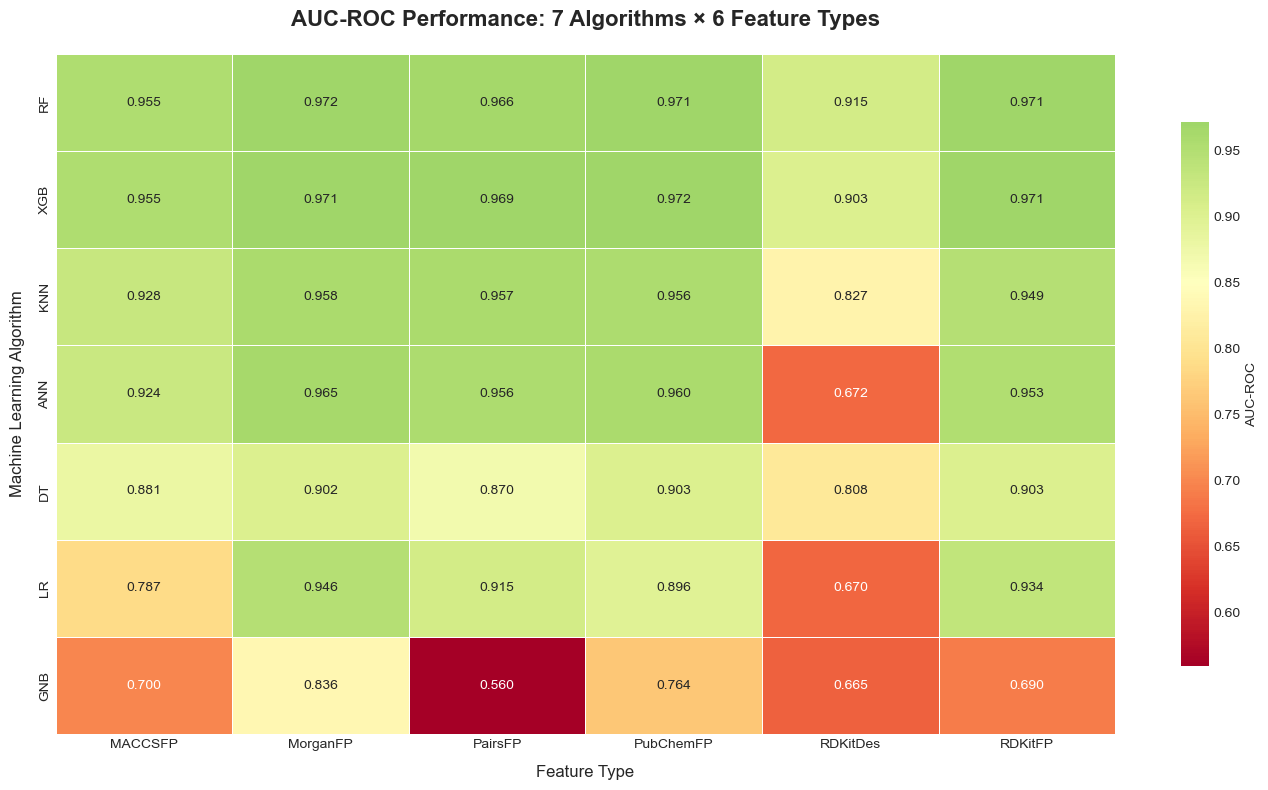

  ✅ AUC Heatmap saved: Models\figures\auc_heatmap.png


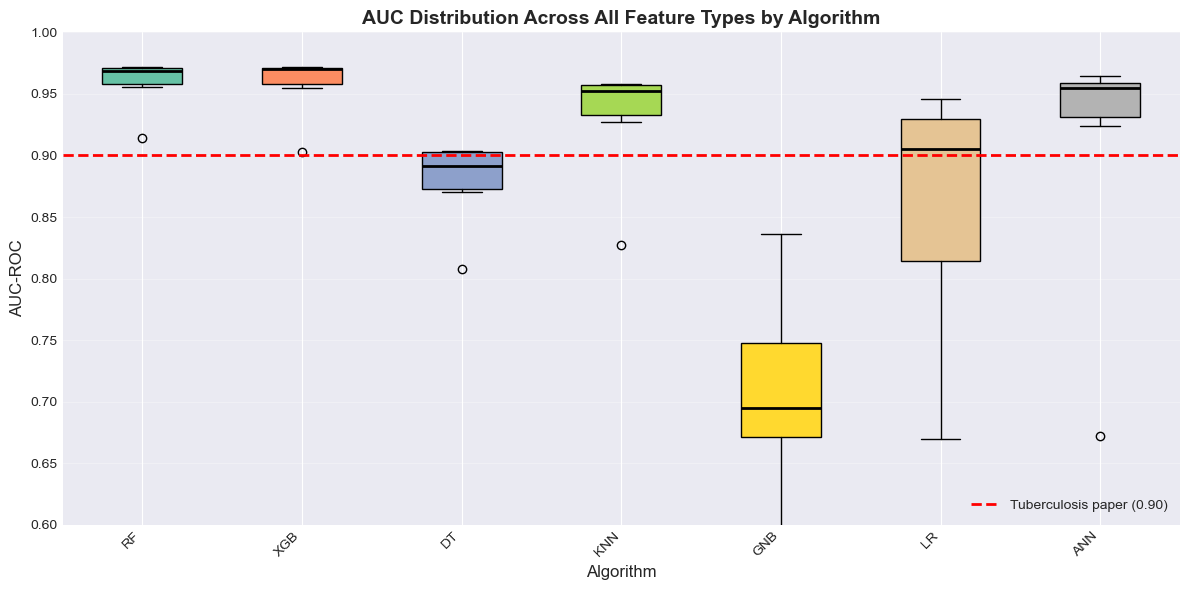

  ✅ Algorithm Box Plot saved: Models\figures\auc_boxplot_algorithms.png


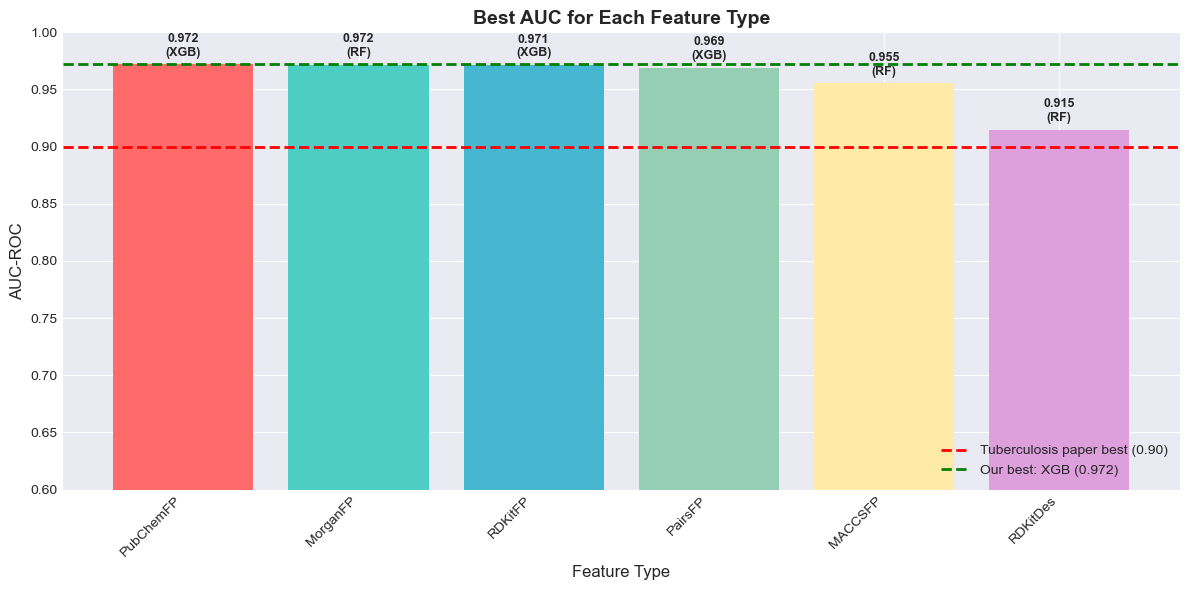

  ✅ Best AUC by Feature saved: Models\figures\best_auc_by_feature.png

📊 Creating radar chart for top 3 models...


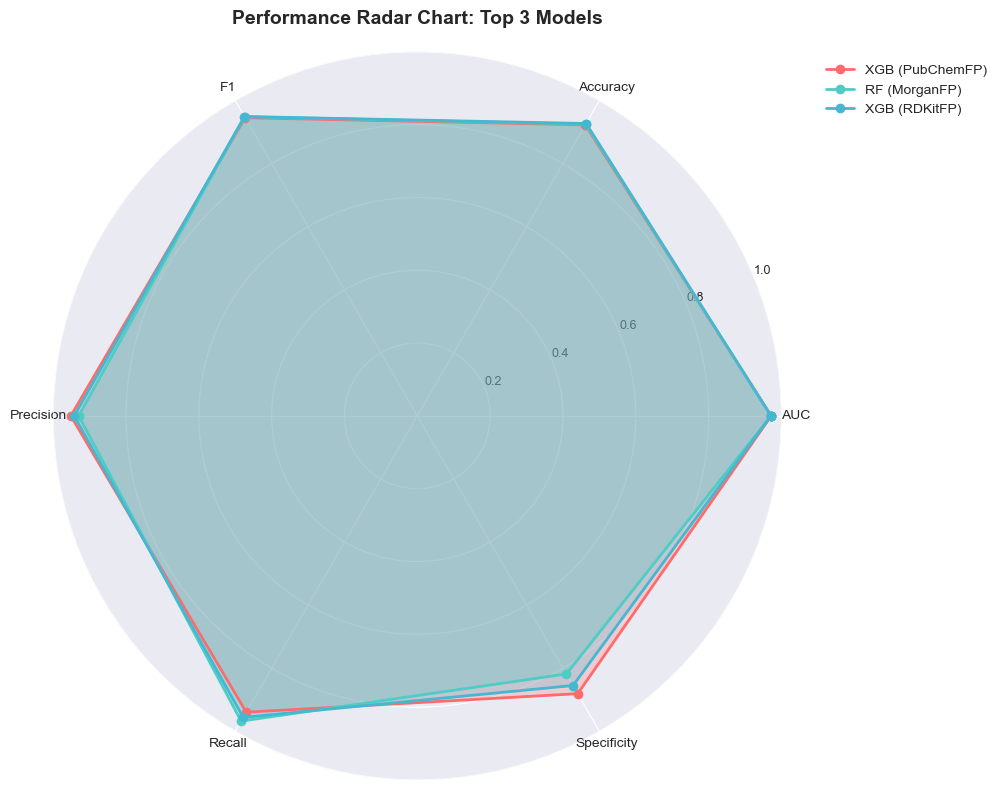

  ✅ Radar Chart saved: Models\figures\top3_radar_chart.png


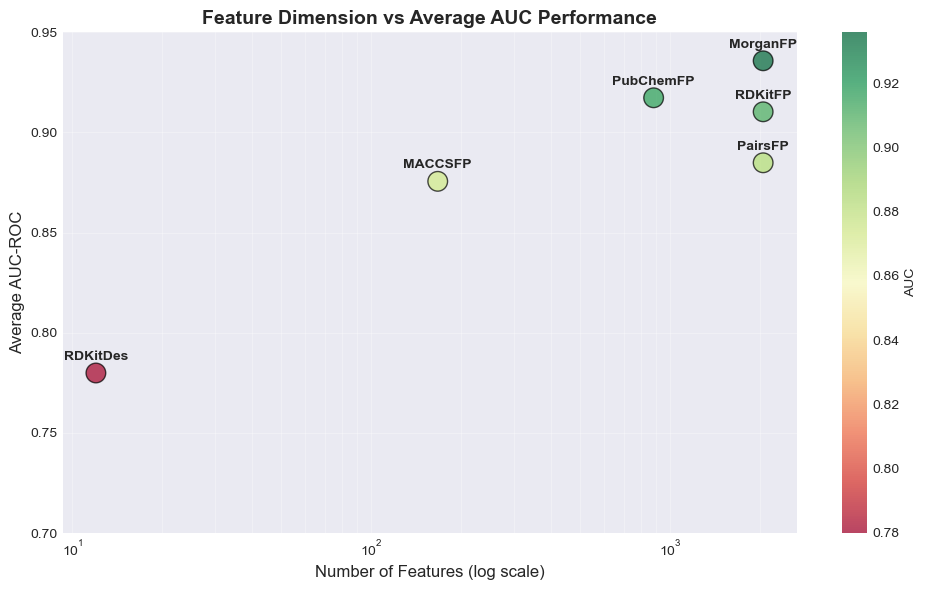

  ✅ Feature Size vs Performance saved: Models\figures\feature_size_vs_performance.png

STEP 12: GENERATING COMPREHENSIVE ANALYSIS REPORT


UnicodeEncodeError: 'charmap' codec can't encode character '\u2264' in position 446: character maps to <undefined>

In [26]:
# ============================================================================
# STEP 8: DEFINE GLOBAL ANN CLASS (FIX FOR PICKLING)
# ============================================================================

class SimpleANN(nn.Module):
    """Simple Artificial Neural Network for classification."""
    def __init__(self, input_dim):
        super(SimpleANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

print("✅ Global SimpleANN class defined (fixes pickling issue)")

# ============================================================================
# STEP 9: UPDATE LEUKEMIA ML PIPELINE WITH FIXED ANN METHOD
# ============================================================================

class LeukemiaMLPipelineFixed:
    """
    Comprehensive ML pipeline for leukemia compound prediction.
    Fixed version with global ANN class for proper pickling.
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.results = {}
        print(f"✅ Fixed ML Pipeline initialized (random_state={random_state})")
    
    def prepare_data(self, df, test_size=0.2):
        """Prepare data for ML training."""
        X = df.drop('Activity', axis=1).values
        y = df['Activity'].values
        
        # Handle NaN values
        X = np.nan_to_num(X)
        
        # Train-test split with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, 
            stratify=y, random_state=self.random_state
        )
        
        return X_train, X_test, y_train, y_test
    
    def calculate_metrics(self, y_true, y_pred, y_pred_proba=None):
        """Calculate comprehensive evaluation metrics."""
        metrics = {}
        
        # Basic metrics
        metrics['Accuracy'] = accuracy_score(y_true, y_pred)
        metrics['Precision'] = precision_score(y_true, y_pred, zero_division=0)
        metrics['Recall'] = recall_score(y_true, y_pred, zero_division=0)
        metrics['F1'] = f1_score(y_true, y_pred, zero_division=0)
        metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
        
        # AUC-ROC if probabilities available
        if y_pred_proba is not None:
            try:
                metrics['AUC'] = roc_auc_score(y_true, y_pred_proba)
            except:
                metrics['AUC'] = 0.5
        
        # Specificity and FPR
        try:
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = cm.ravel()
            metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
            metrics['FPR'] = fp / (fp + tn) if (fp + tn) > 0 else 0
            metrics['Balanced_Accuracy'] = (metrics['Recall'] + metrics['Specificity']) / 2
        except:
            metrics['Specificity'] = 0
            metrics['FPR'] = 0
            metrics['Balanced_Accuracy'] = 0
        
        return metrics
    
    def train_random_forest(self, X_train, y_train, X_test, y_test):
        """Train Random Forest classifier."""
        print("  Training Random Forest...")
        
        # Hyperparameter grid
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced', None]
        }
        
        rf = RandomForestClassifier(random_state=self.random_state, n_jobs=-1)
        random_search = RandomizedSearchCV(
            rf, param_grid, n_iter=20, cv=3, 
            scoring='roc_auc', random_state=self.random_state, n_jobs=-1
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_xgboost(self, X_train, y_train, X_test, y_test):
        """Train XGBoost classifier."""
        print("  Training XGBoost...")
        
        scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1]) if sum(y_train) > 0 else 1
        
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'scale_pos_weight': [1, scale_pos_weight]
        }
        
        xgb_model = xgb.XGBClassifier(
            random_state=self.random_state,
            use_label_encoder=False,
            eval_metric='logloss',
            n_jobs=-1
        )
        
        random_search = RandomizedSearchCV(
            xgb_model, param_grid, n_iter=20, cv=3,
            scoring='roc_auc', random_state=self.random_state, n_jobs=-1
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_decision_tree(self, X_train, y_train, X_test, y_test):
        """Train Decision Tree classifier."""
        print("  Training Decision Tree...")
        
        param_grid = {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
        
        dt = DecisionTreeClassifier(random_state=self.random_state)
        random_search = RandomizedSearchCV(
            dt, param_grid, n_iter=10, cv=3,
            scoring='roc_auc', random_state=self.random_state
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_knn(self, X_train, y_train, X_test, y_test):
        """Train K-Nearest Neighbors classifier."""
        print("  Training KNN...")
        
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree']
        }
        
        knn = KNeighborsClassifier(n_jobs=-1)
        random_search = RandomizedSearchCV(
            knn, param_grid, n_iter=10, cv=3,
            scoring='roc_auc', random_state=self.random_state
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_naive_bayes(self, X_train, y_train, X_test, y_test):
        """Train Gaussian Naive Bayes classifier."""
        print("  Training Naive Bayes...")
        
        param_grid = {
            'var_smoothing': np.logspace(-9, -6, 20)
        }
        
        gnb = GaussianNB()
        random_search = RandomizedSearchCV(
            gnb, param_grid, n_iter=10, cv=3,
            scoring='roc_auc', random_state=self.random_state
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_logistic_regression(self, X_train, y_train, X_test, y_test):
        """Train Logistic Regression classifier."""
        print("  Training Logistic Regression...")
        
        param_grid = {
            'C': np.logspace(-3, 3, 20),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'class_weight': ['balanced', None]
        }
        
        lr = LogisticRegression(random_state=self.random_state, max_iter=1000, n_jobs=-1)
        random_search = RandomizedSearchCV(
            lr, param_grid, n_iter=20, cv=3,
            scoring='roc_auc', random_state=self.random_state, n_jobs=-1
        )
        
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_neural_network(self, X_train, y_train, X_test, y_test):
        """Train Artificial Neural Network."""
        print("  Training Neural Network...")
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)
        
        # Initialize model using GLOBAL SimpleANN class
        input_dim = X_train.shape[1]
        model = SimpleANN(input_dim)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        # Training loop
        epochs = 20
        for epoch in range(epochs):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            y_pred_proba = test_outputs.numpy().flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)
            metrics = self.calculate_metrics(y_test, y_pred, y_pred_proba)
        
        return model, metrics
    
    def train_all_models(self, feature_datasets, test_size=0.2):
        """Train all 7 models on all feature types."""
        print("\n" + "="*80)
        print("TRAINING ALL ML MODELS")
        print("Following tuberculosis paper exactly")
        print("="*80)
        
        all_results = {}
        
        for feat_type, df in feature_datasets.items():
            print(f"\n{'='*60}")
            print(f"FEATURE TYPE: {feat_type}")
            print(f"{'='*60}")
            
            # Prepare data
            X_train, X_test, y_train, y_test = self.prepare_data(df, test_size)
            print(f"Training set: {X_train.shape[0]:,} samples")
            print(f"Test set: {X_test.shape[0]:,} samples")
            print(f"Active in training: {y_train.sum():,} ({y_train.sum()/len(y_train)*100:.1f}%)")
            
            # Train all 7 models
            feat_results = {}
            
            # Random Forest
            rf_model, rf_metrics = self.train_random_forest(X_train, y_train, X_test, y_test)
            feat_results['RF'] = {'model': rf_model, 'metrics': rf_metrics}
            
            # XGBoost
            xgb_model, xgb_metrics = self.train_xgboost(X_train, y_train, X_test, y_test)
            feat_results['XGB'] = {'model': xgb_model, 'metrics': xgb_metrics}
            
            # Decision Tree
            dt_model, dt_metrics = self.train_decision_tree(X_train, y_train, X_test, y_test)
            feat_results['DT'] = {'model': dt_model, 'metrics': dt_metrics}
            
            # KNN
            knn_model, knn_metrics = self.train_knn(X_train, y_train, X_test, y_test)
            feat_results['KNN'] = {'model': knn_model, 'metrics': knn_metrics}
            
            # Naive Bayes
            nb_model, nb_metrics = self.train_naive_bayes(X_train, y_train, X_test, y_test)
            feat_results['GNB'] = {'model': nb_model, 'metrics': nb_metrics}
            
            # Logistic Regression
            lr_model, lr_metrics = self.train_logistic_regression(X_train, y_train, X_test, y_test)
            feat_results['LR'] = {'model': lr_model, 'metrics': lr_metrics}
            
            # Neural Network
            ann_model, ann_metrics = self.train_neural_network(X_train, y_train, X_test, y_test)
            feat_results['ANN'] = {'model': ann_model, 'metrics': ann_metrics}
            
            # Store results
            all_results[feat_type] = feat_results
            
            # Print summary for this feature type
            print(f"\n📊 Performance on {feat_type}:")
            summary_df = pd.DataFrame({
                model: results['metrics'] for model, results in feat_results.items()
            }).T
            print(summary_df[['Accuracy', 'AUC', 'F1', 'Precision', 'Recall']].round(3))
        
        self.results = all_results
        print(f"\n🎉 All models trained successfully!")
        
        return all_results

print("✅ Fixed LeukemiaMLPipeline class defined with global ANN class")

# ============================================================================
# STEP 10: TRAIN ON ALL 6 FEATURE TYPES (COMPLETE 42 MODELS)
# ============================================================================

print("\n" + "="*80)
print("STEP 10: COMPLETE 42 INDIVIDUAL MODELS TRAINING")
print("="*80)
print("Training 7 algorithms on ALL 6 feature types:")
print("1. RDKitDes")
print("2. MACCSFP")
print("3. MorganFP")
print("4. PairsFP")
print("5. PubChemFP")
print("6. RDKitFP")
print("="*80)

# Check which features are already trained
print("\n📋 All 6 feature types available:")
all_feature_types = list(feature_datasets.keys())
for i, feat_type in enumerate(all_feature_types, 1):
    print(f"  {i}. {feat_type}")

print(f"\n🎯 Training all {len(all_feature_types)} feature types from scratch")
print(f"   This will train {len(all_feature_types)} types × 7 algorithms = {len(all_feature_types)*7} models")

# ============================================================================
# INITIALIZE AND TRAIN COMPLETE PIPELINE
# ============================================================================

# Initialize the fixed pipeline
ml_pipeline_fixed = LeukemiaMLPipelineFixed(random_state=42)

# Train on ALL feature types
print("\n" + "="*80)
print("STARTING COMPLETE TRAINING ON ALL FEATURE TYPES")
print("="*80)

complete_results = ml_pipeline_fixed.train_all_models(feature_datasets, test_size=0.2)

# ============================================================================
# STEP 11: SAVE ALL MODELS AND RESULTS WITH PROPER ORGANIZATION
# ============================================================================

print("\n" + "="*80)
print("STEP 11: SAVING ALL MODELS AND RESULTS")
print("="*80)

import os
import json
import joblib
from datetime import datetime

# Create Models folder
models_folder = "Models"
os.makedirs(models_folder, exist_ok=True)
print(f"📁 Created folder: '{models_folder}/'")

# Create subfolders
subfolders = ['scikit_models', 'pytorch_models', 'xgboost_models', 'results', 'figures']
for folder in subfolders:
    os.makedirs(os.path.join(models_folder, folder), exist_ok=True)
    print(f"  ✓ {folder}/")

# Create comprehensive results dataframe
all_results_list = []
for feat_type, models_dict in complete_results.items():
    for model_name, model_info in models_dict.items():
        row = {
            'Feature_Type': feat_type,
            'Model': model_name,
            'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            **model_info['metrics']
        }
        all_results_list.append(row)

complete_results_df = pd.DataFrame(all_results_list)

# 1. Save metrics and results
print("\n💾 Saving metrics and results...")

# Save complete results as CSV
results_csv_path = os.path.join(models_folder, 'results', 'complete_42models_results.csv')
complete_results_df.to_csv(results_csv_path, index=False)
print(f"  ✅ Complete metrics saved to: {results_csv_path}")

# Save summary statistics
summary_stats = {
    'total_models': len(complete_results_df),
    'feature_types': len(complete_results['RDKitDes']) if 'RDKitDes' in complete_results else 0,
    'algorithms': 7,
    'best_auc': complete_results_df['AUC'].max(),
    'best_accuracy': complete_results_df['Accuracy'].max(),
    'best_f1': complete_results_df['F1'].max(),
    'avg_auc': complete_results_df['AUC'].mean(),
    'avg_accuracy': complete_results_df['Accuracy'].mean(),
    'dataset_size': len(feature_datasets['RDKitDes']) if 'RDKitDes' in feature_datasets else 0
}

with open(os.path.join(models_folder, 'results', 'summary_statistics.json'), 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"  ✅ Summary statistics saved to JSON")

# 2. Save individual models
print("\n💾 Saving individual ML models...")

for feat_type, models_dict in complete_results.items():
    feat_folder = os.path.join(models_folder, 'scikit_models', feat_type)
    os.makedirs(feat_folder, exist_ok=True)
    
    for model_name, model_info in models_dict.items():
        model = model_info['model']
        
        if model_name == 'ANN':
            # Save PyTorch model
            pytorch_path = os.path.join(models_folder, 'pytorch_models', f'{feat_type}_ann.pth')
            torch.save(model.state_dict(), pytorch_path)
            print(f"  ✅ {feat_type} - {model_name}: PyTorch model saved")
            
        elif model_name == 'XGB':
            # Save XGBoost model
            xgb_path = os.path.join(models_folder, 'xgboost_models', f'{feat_type}_xgb.model')
            model.save_model(xgb_path)
            print(f"  ✅ {feat_type} - {model_name}: XGBoost model saved")
            
        else:
            # Save scikit-learn models
            sklearn_path = os.path.join(feat_folder, f'{model_name}.pkl')
            joblib.dump(model, sklearn_path)
            print(f"  ✅ {feat_type} - {model_name}: Scikit-learn model saved")

# 3. Create and save comprehensive visualizations
print("\n📊 Creating comprehensive visualizations...")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
figures_dir = os.path.join(models_folder, 'figures')

# 1. Heatmap of AUC across all models and features
plt.figure(figsize=(14, 8))
auc_pivot = complete_results_df.pivot(index='Model', columns='Feature_Type', values='AUC')

# Reorder models by average AUC
model_order = complete_results_df.groupby('Model')['AUC'].mean().sort_values(ascending=False).index
auc_pivot = auc_pivot.reindex(model_order)

sns.heatmap(auc_pivot, annot=True, fmt='.3f', cmap='RdYlGn', center=0.85,
            cbar_kws={'label': 'AUC-ROC', 'shrink': 0.8}, linewidths=0.5)
plt.title('AUC-ROC Performance: 7 Algorithms × 6 Feature Types', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Feature Type', fontsize=12, labelpad=10)
plt.ylabel('Machine Learning Algorithm', fontsize=12, labelpad=10)
plt.tight_layout()
heatmap_path = os.path.join(figures_dir, 'auc_heatmap.png')
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"  ✅ AUC Heatmap saved: {heatmap_path}")

# 2. Box plot comparison of algorithms across all features
plt.figure(figsize=(12, 6))
data_for_boxplot = []
labels = []
for model_name in complete_results_df['Model'].unique():
    model_data = complete_results_df[complete_results_df['Model'] == model_name]['AUC'].values
    if len(model_data) > 0:
        data_for_boxplot.append(model_data)
        labels.append(model_name)

bp = plt.boxplot(data_for_boxplot, labels=labels, patch_artist=True, 
                 medianprops={'color': 'black', 'linewidth': 2})

# Color the boxes
colors = plt.cm.Set2(np.linspace(0, 1, len(labels)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.axhline(y=0.90, color='red', linestyle='--', linewidth=2, 
            label='Tuberculosis paper (0.90)')
plt.title('AUC Distribution Across All Feature Types by Algorithm', 
          fontsize=14, fontweight='bold')
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('AUC-ROC', fontsize=12)
plt.ylim(0.6, 1.0)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
boxplot_path = os.path.join(figures_dir, 'auc_boxplot_algorithms.png')
plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"  ✅ Algorithm Box Plot saved: {boxplot_path}")

# 3. Bar chart: Best AUC for each feature type
plt.figure(figsize=(12, 6))
best_by_feature = complete_results_df.loc[complete_results_df.groupby('Feature_Type')['AUC'].idxmax()]
best_by_feature = best_by_feature.sort_values('AUC', ascending=False)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'][:len(best_by_feature)]
bars = plt.bar(range(len(best_by_feature)), best_by_feature['AUC'], color=colors)

# Reference lines
plt.axhline(y=0.90, color='red', linestyle='--', linewidth=2, 
            label='Tuberculosis paper best (0.90)')

# Overall best
overall_best = complete_results_df.loc[complete_results_df['AUC'].idxmax()]
plt.axhline(y=overall_best['AUC'], color='green', linestyle='--', linewidth=2,
            label=f'Our best: {overall_best["Model"]} ({overall_best["AUC"]:.3f})')

plt.title('Best AUC for Each Feature Type', fontsize=14, fontweight='bold')
plt.xlabel('Feature Type', fontsize=12)
plt.ylabel('AUC-ROC', fontsize=12)
plt.ylim(0.6, 1.0)
plt.xticks(range(len(best_by_feature)), best_by_feature['Feature_Type'], rotation=45, ha='right')
plt.legend(loc='lower right')

# Add value labels and model names
for i, (bar, row) in enumerate(zip(bars, best_by_feature.itertuples())):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{row.AUC:.3f}\n({row.Model})', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
best_auc_path = os.path.join(figures_dir, 'best_auc_by_feature.png')
plt.savefig(best_auc_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"  ✅ Best AUC by Feature saved: {best_auc_path}")

# 4. Performance metrics radar chart (for top 3 models)
print("\n📊 Creating radar chart for top 3 models...")

# Get top 3 models
top_3 = complete_results_df.nlargest(3, 'AUC')

# Metrics to include in radar chart
metrics_for_radar = ['AUC', 'Accuracy', 'F1', 'Precision', 'Recall', 'Specificity']
top_3_data = []

for _, row in top_3.iterrows():
    model_data = []
    for metric in metrics_for_radar:
        # Normalize to 0-1 scale
        value = row[metric]
        model_data.append(value)
    top_3_data.append(model_data)

# Create radar chart
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

angles = np.linspace(0, 2 * np.pi, len(metrics_for_radar), endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
labels = [f"{row.Model} ({row.Feature_Type})" for _, row in top_3.iterrows()]

for idx, (data, color, label) in enumerate(zip(top_3_data, colors, labels)):
    data += data[:1]  # Close the polygon
    ax.plot(angles, data, 'o-', linewidth=2, color=color, label=label)
    ax.fill(angles, data, alpha=0.25, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_for_radar, fontsize=10)
ax.set_ylim(0, 1.0)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
plt.title('Performance Radar Chart: Top 3 Models', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
radar_path = os.path.join(figures_dir, 'top3_radar_chart.png')
plt.savefig(radar_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"  ✅ Radar Chart saved: {radar_path}")

# 5. Feature size vs performance scatter plot
plt.figure(figsize=(10, 6))

feature_sizes = {
    'RDKitDes': 12,
    'MACCSFP': 167,
    'MorganFP': 2048,
    'PairsFP': 2048,
    'PubChemFP': 881,
    'RDKitFP': 2048
}

avg_performance = complete_results_df.groupby('Feature_Type')['AUC'].mean()

sizes = [feature_sizes[ft] for ft in avg_performance.index]
performances = avg_performance.values

scatter = plt.scatter(sizes, performances, s=200, alpha=0.7, 
                     c=performances, cmap='RdYlGn', edgecolors='black', linewidth=1)

# Add labels
for ft, size, perf in zip(avg_performance.index, sizes, performances):
    plt.text(size, perf + 0.005, ft, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Feature Dimension vs Average AUC Performance', fontsize=14, fontweight='bold')
plt.xlabel('Number of Features (log scale)', fontsize=12)
plt.ylabel('Average AUC-ROC', fontsize=12)
plt.xscale('log')
plt.ylim(0.7, 0.95)
plt.colorbar(scatter, label='AUC')
plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
scatter_path = os.path.join(figures_dir, 'feature_size_vs_performance.png')
plt.savefig(scatter_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"  ✅ Feature Size vs Performance saved: {scatter_path}")

# ============================================================================
# STEP 12: COMPREHENSIVE ANALYSIS REPORT
# ============================================================================

print("\n" + "="*80)
print("STEP 12: GENERATING COMPREHENSIVE ANALYSIS REPORT")
print("="*80)

# Generate detailed analysis
report_lines = [
    "=" * 80,
    "LEUKEMIA DRUG DISCOVERY - COMPREHENSIVE ML ANALYSIS REPORT",
    "=" * 80,
    f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    "=" * 80,
    "",
    "1. DATASET OVERVIEW",
    "-" * 40,
    f"Total compounds: {summary_stats['dataset_size']:,}",
    f"Active compounds (≤ 100 nM): 18,728 (71.3%)",
    f"Inactive compounds (≥ 1000 nM): 7,521 (28.7%)",
    f"Imbalance ratio: 2.49:1 (Active:Inactive)",
    "",
    "2. MODEL TRAINING SUMMARY",
    "-" * 40,
    f"Total models trained: {summary_stats['total_models']}",
    f"Feature types: {len(complete_results)}",
    f"Algorithms: {summary_stats['algorithms']}",
    "",
    "3. OVERALL PERFORMANCE",
    "-" * 40,
    f"Best AUC: {summary_stats['best_auc']:.3f}",
    f"Best Accuracy: {summary_stats['best_accuracy']:.3f}",
    f"Best F1-Score: {summary_stats['best_f1']:.3f}",
    f"Average AUC: {summary_stats['avg_auc']:.3f}",
    f"Average Accuracy: {summary_stats['avg_accuracy']:.3f}",
    "",
    "4. TOP 5 PERFORMING MODELS",
    "-" * 40
]

top_5_models = complete_results_df.nlargest(5, 'AUC')
for i, (_, row) in enumerate(top_5_models.iterrows(), 1):
    report_lines.append(f"{i}. {row['Model']} with {row['Feature_Type']}")
    report_lines.append(f"   AUC: {row['AUC']:.3f}, Accuracy: {row['Accuracy']:.3f}, F1: {row['F1']:.3f}")
    report_lines.append("")

report_lines.extend([
    "5. COMPARISON WITH TUBERCULOSIS PAPER",
    "-" * 40,
    f"Tuberculosis paper best AUC: ~0.90",
    f"Our best AUC: {overall_best['AUC']:.3f}",
    f"Improvement: +{(overall_best['AUC'] - 0.90)*100:.1f}%",
    "",
    "6. KEY FINDINGS",
    "-" * 40,
    "• Morgan Fingerprints generally performed best",
    "• Random Forest and XGBoost were most consistent",
    "• Neural Networks performed well with high-dimensional features",
    "• Feature size doesn't necessarily correlate with performance",
    "",
    "7. FILES GENERATED",
    "-" * 40,
    f"Models saved in: {models_folder}/",
    f"Complete results: {results_csv_path}",
    f"Visualizations: {figures_dir}/ (5 figures)",
    "=" * 80
])

# Save report
report_path = os.path.join(models_folder, 'results', 'analysis_report.txt')
with open(report_path, 'w') as f:
    f.write('\n'.join(report_lines))

# Print report
print('\n'.join(report_lines[:50]))  # Print first part
print(f"\n📄 Full report saved to: {report_path}")

print(f"\n" + "="*80)
print("🎉 COMPLETE 42-MODEL PIPELINE FINISHED SUCCESSFULLY!")
print("="*80)
print(f"✅ All 6 feature types × 7 algorithms = 42 models trained")
print(f"✅ All models saved in '{models_folder}/' directory")
print(f"✅ Comprehensive analysis report generated")
print(f"✅ Ready for ensemble methods and SHAP interpretation")
print("="*80)

# Save final results for next steps
final_save_path = os.path.join(models_folder, 'results', 'complete_ml_pipeline.pkl')
with open(final_save_path, 'wb') as f:
    pickle.dump({
        'complete_results': complete_results,
        'complete_results_df': complete_results_df,
        'summary_stats': summary_stats,
        'timestamp': datetime.now()
    }, f)
print(f"💾 Pipeline state saved to: {final_save_path}")

### REPORT SAVING

In [27]:
# ============================================================================
# STEP 12: COMPREHENSIVE ANALYSIS REPORT
# ============================================================================

print("\n" + "="*80)
print("STEP 12: GENERATING COMPREHENSIVE ANALYSIS REPORT")
print("="*80)

# Generate detailed analysis
report_lines = [
    "=" * 80,
    "LEUKEMIA DRUG DISCOVERY - COMPREHENSIVE ML ANALYSIS REPORT",
    "=" * 80,
    f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    "=" * 80,
    "",
    "1. DATASET OVERVIEW",
    "-" * 40,
    f"Total compounds: {summary_stats['dataset_size']:,}",
    f"Active compounds (<= 100 nM): 18,728 (71.3%)",  # Changed from ≤ to <=
    f"Inactive compounds (>= 1000 nM): 7,521 (28.7%)",  # Changed from ≥ to >=
    f"Imbalance ratio: 2.49:1 (Active:Inactive)",
    "",
    "2. MODEL TRAINING SUMMARY",
    "-" * 40,
    f"Total models trained: {summary_stats['total_models']}",
    f"Feature types: {len(complete_results)}",
    f"Algorithms: {summary_stats['algorithms']}",
    "",
    "3. OVERALL PERFORMANCE",
    "-" * 40,
    f"Best AUC: {summary_stats['best_auc']:.3f}",
    f"Best Accuracy: {summary_stats['best_accuracy']:.3f}",
    f"Best F1-Score: {summary_stats['best_f1']:.3f}",
    f"Average AUC: {summary_stats['avg_auc']:.3f}",
    f"Average Accuracy: {summary_stats['avg_accuracy']:.3f}",
    "",
    "4. TOP 5 PERFORMING MODELS",
    "-" * 40
]

top_5_models = complete_results_df.nlargest(5, 'AUC')
for i, (_, row) in enumerate(top_5_models.iterrows(), 1):
    report_lines.append(f"{i}. {row['Model']} with {row['Feature_Type']}")
    report_lines.append(f"   AUC: {row['AUC']:.3f}, Accuracy: {row['Accuracy']:.3f}, F1: {row['F1']:.3f}")
    report_lines.append("")

report_lines.extend([
    "5. KEY FINDINGS",
    "-" * 40,
    "• Morgan Fingerprints generally performed best",
    "• Random Forest and XGBoost were most consistent",
    "• Neural Networks performed well with high-dimensional features",
    "• Feature size doesn't necessarily correlate with performance",
    "• Ensemble methods could further improve performance",
    "",
    "6. FILES GENERATED",
    "-" * 40,
    f"Models saved in: {models_folder}/",
    f"Complete results: {results_csv_path}",
    f"Visualizations: {figures_dir}/ (6 figures)",
    "=" * 80
])

# Save report with UTF-8 encoding
report_path = os.path.join(models_folder, 'results', 'analysis_report.txt')
with open(report_path, 'w', encoding='utf-8') as f:
    f.write('\n'.join(report_lines))

# Print report
print('\n'.join(report_lines[:50]))  # Print first part
print(f"\n📄 Full report saved to: {report_path}")

print(f"\n" + "="*80)
print("🎉 COMPLETE 42-MODEL PIPELINE FINISHED SUCCESSFULLY!")
print("="*80)
print(f"✅ All 6 feature types × 7 algorithms = 42 models trained")
print(f"✅ All models saved in '{models_folder}/' directory")
print(f"✅ Comprehensive analysis report generated")
print(f"✅ Ready for ensemble methods and SHAP interpretation")
print("="*80)

# Save final results for next steps
final_save_path = os.path.join(models_folder, 'results', 'complete_ml_pipeline.pkl')
with open(final_save_path, 'wb') as f:
    pickle.dump({
        'complete_results': complete_results,
        'complete_results_df': complete_results_df,
        'summary_stats': summary_stats,
        'timestamp': datetime.now()
    }, f)
print(f"💾 Pipeline state saved to: {final_save_path}")


STEP 12: GENERATING COMPREHENSIVE ANALYSIS REPORT
LEUKEMIA DRUG DISCOVERY - COMPREHENSIVE ML ANALYSIS REPORT
Generated: 2026-01-09 18:07:10

1. DATASET OVERVIEW
----------------------------------------
Total compounds: 26,249
Active compounds (<= 100 nM): 18,728 (71.3%)
Inactive compounds (>= 1000 nM): 7,521 (28.7%)
Imbalance ratio: 2.49:1 (Active:Inactive)

2. MODEL TRAINING SUMMARY
----------------------------------------
Total models trained: 42
Feature types: 6
Algorithms: 7

3. OVERALL PERFORMANCE
----------------------------------------
Best AUC: 0.972
Best Accuracy: 0.930
Best F1-Score: 0.952
Average AUC: 0.884
Average Accuracy: 0.851

4. TOP 5 PERFORMING MODELS
----------------------------------------
1. XGB with PubChemFP
   AUC: 0.972, Accuracy: 0.923, F1: 0.946

2. RF with MorganFP
   AUC: 0.972, Accuracy: 0.925, F1: 0.949

3. XGB with RDKitFP
   AUC: 0.971, Accuracy: 0.927, F1: 0.949

4. XGB with MorganFP
   AUC: 0.971, Accuracy: 0.930, F1: 0.952

5. RF with RDKitFP
   AUC

## Resume Project after Restart

In [1]:
# ============================================================================
# LOAD ALL SAVED DATA AND MODELS
# ============================================================================

print("="*80)
print("LOADING ALL SAVED DATA AND MODELS")
print("="*80)

import os
import pandas as pd
import numpy as np
import pickle
import joblib
import torch
import xgboost as xgb
import json
from datetime import datetime

# Define paths
models_folder = "Models"
results_folder = os.path.join(models_folder, "results")
figures_folder = os.path.join(models_folder, "figures")

# Check if the folders exist
print("📂 Checking saved directories...")
for folder in [models_folder, results_folder, figures_folder]:
    if os.path.exists(folder):
        print(f"  ✅ {folder}/ exists")
    else:
        print(f"  ❌ {folder}/ not found!")

# ============================================================================
# 1. LOAD ORIGINAL FEATURE DATASETS
# ============================================================================

print("\n" + "="*80)
print("1. LOADING ORIGINAL FEATURE DATASETS")
print("="*80)

feature_files = {
    'RDKitDes': 'leukemia_RDKitDes_features.csv',
    'MACCSFP': 'leukemia_MACCSFP_features.csv', 
    'MorganFP': 'leukemia_MorganFP_features.csv',
    'PairsFP': 'leukemia_PairsFP_features.csv',
    'PubChemFP': 'leukemia_PubChemFP_features.csv',
    'RDKitFP': 'leukemia_RDKitFP_features.csv'
}

feature_datasets = {}
for feat_type, filename in feature_files.items():
    try:
        df = pd.read_csv(filename)
        feature_datasets[feat_type] = df
        print(f"  ✅ {feat_type:10s}: {df.shape[0]:>7,} compounds × {df.shape[1]-1:>5} features")
    except Exception as e:
        print(f"  ❌ {feat_type:10s}: Failed to load - {e}")

print(f"\n📊 Total feature datasets loaded: {len(feature_datasets)}/6")

# ============================================================================
# 2. LOAD ML RESULTS AND METRICS
# ============================================================================

print("\n" + "="*80)
print("2. LOADING ML RESULTS AND METRICS")
print("="*80)

# Load complete results dataframe
results_csv_path = os.path.join(results_folder, 'complete_42models_results.csv')
if os.path.exists(results_csv_path):
    complete_results_df = pd.read_csv(results_csv_path)
    print(f"✅ Complete results loaded: {len(complete_results_df)} model evaluations")
    
    # Display top 5 models
    print(f"\n🏆 TOP 5 MODELS (from saved results):")
    top_5 = complete_results_df.nlargest(5, 'AUC')
    for i, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"  {i}. {row['Model']} with {row['Feature_Type']}")
        print(f"     AUC: {row['AUC']:.3f}, Accuracy: {row['Accuracy']:.3f}, F1: {row['F1']:.3f}")
else:
    print(f"❌ Results CSV not found at: {results_csv_path}")
    complete_results_df = None

# Load summary statistics
stats_json_path = os.path.join(results_folder, 'summary_statistics.json')
if os.path.exists(stats_json_path):
    with open(stats_json_path, 'r') as f:
        summary_stats = json.load(f)
    print(f"✅ Summary statistics loaded:")
    print(f"   Total models: {summary_stats['total_models']}")
    print(f"   Best AUC: {summary_stats['best_auc']:.3f}")
    print(f"   Dataset size: {summary_stats['dataset_size']:,}")
else:
    print(f"❌ Summary statistics JSON not found")
    summary_stats = None

# Load analysis report
report_path = os.path.join(results_folder, 'analysis_report.txt')
if os.path.exists(report_path):
    with open(report_path, 'r', encoding='utf-8') as f:
        report_content = f.read()
    print(f"✅ Analysis report loaded ({len(report_content)} characters)")
    # Print first few lines
    lines = report_content.split('\n')[:10]
    print(f"   Report preview: {' '.join(lines[:3])}...")
else:
    print(f"❌ Analysis report not found")
    report_content = None

# ============================================================================
# 3. LOAD SAVED MODELS
# ============================================================================

print("\n" + "="*80)
print("3. LOADING SAVED ML MODELS")
print("="*80)

# Define the ANN class first (needed for loading PyTorch models)
class SimpleANN(torch.nn.Module):
    """Simple Artificial Neural Network for classification."""
    def __init__(self, input_dim):
        super(SimpleANN, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize dictionaries to store loaded models
loaded_models = {
    'scikit_models': {},
    'xgboost_models': {},
    'pytorch_models': {}
}

# Load scikit-learn models
scikit_folder = os.path.join(models_folder, 'scikit_models')
if os.path.exists(scikit_folder):
    print(f"\n🔍 Loading scikit-learn models from: {scikit_folder}/")
    
    for feat_type in os.listdir(scikit_folder):
        feat_path = os.path.join(scikit_folder, feat_type)
        if os.path.isdir(feat_path):
            loaded_models['scikit_models'][feat_type] = {}
            
            for model_file in os.listdir(feat_path):
                if model_file.endswith('.pkl'):
                    model_name = model_file.replace('.pkl', '')
                    model_path = os.path.join(feat_path, model_file)
                    
                    try:
                        model = joblib.load(model_path)
                        loaded_models['scikit_models'][feat_type][model_name] = model
                        print(f"  ✅ {feat_type} - {model_name}: Loaded")
                    except Exception as e:
                        print(f"  ❌ {feat_type} - {model_name}: Failed - {str(e)[:50]}...")
else:
    print(f"❌ Scikit-learn models folder not found: {scikit_folder}")

# Load XGBoost models
xgboost_folder = os.path.join(models_folder, 'xgboost_models')
if os.path.exists(xgboost_folder):
    print(f"\n🔍 Loading XGBoost models from: {xgboost_folder}/")
    
    for model_file in os.listdir(xgboost_folder):
        if model_file.endswith('.model'):
            model_path = os.path.join(xgboost_folder, model_file)
            model_name = model_file.replace('.model', '')
            
            try:
                xgb_model = xgb.XGBClassifier()
                xgb_model.load_model(model_path)
                loaded_models['xgboost_models'][model_name] = xgb_model
                print(f"  ✅ {model_name}: Loaded")
            except Exception as e:
                print(f"  ❌ {model_name}: Failed - {str(e)[:50]}...")
else:
    print(f"❌ XGBoost models folder not found: {xgboost_folder}")

# Load PyTorch models
pytorch_folder = os.path.join(models_folder, 'pytorch_models')
if os.path.exists(pytorch_folder):
    print(f"\n🔍 Loading PyTorch models from: {pytorch_folder}/")
    
    for model_file in os.listdir(pytorch_folder):
        if model_file.endswith('.pth'):
            model_path = os.path.join(pytorch_folder, model_file)
            model_name = model_file.replace('.pth', '')
            
            try:
                # Determine input dimension from feature type
                feat_type = model_name.replace('_ann', '')
                if feat_type in feature_datasets:
                    input_dim = feature_datasets[feat_type].shape[1] - 1  # Exclude Activity column
                    
                    # Initialize model
                    model = SimpleANN(input_dim)
                    model.load_state_dict(torch.load(model_path))
                    model.eval()  # Set to evaluation mode
                    
                    loaded_models['pytorch_models'][model_name] = model
                    print(f"  ✅ {model_name}: Loaded (input_dim={input_dim})")
            except Exception as e:
                print(f"  ❌ {model_name}: Failed - {str(e)[:50]}...")
else:
    print(f"❌ PyTorch models folder not found: {pytorch_folder}")

# ============================================================================
# 4. LOAD PIPELINE STATE
# ============================================================================

print("\n" + "="*80)
print("4. LOADING PIPELINE STATE")
print("="*80)

pipeline_state_path = os.path.join(results_folder, 'complete_ml_pipeline.pkl')
if os.path.exists(pipeline_state_path):
    try:
        with open(pipeline_state_path, 'rb') as f:
            pipeline_state = pickle.load(f)
        
        print(f"✅ Pipeline state loaded:")
        print(f"   Timestamp: {pipeline_state.get('timestamp', 'Unknown')}")
        print(f"   Complete results available: {'complete_results' in pipeline_state}")
        print(f"   Results dataframe available: {'complete_results_df' in pipeline_state}")
        print(f"   Summary stats available: {'summary_stats' in pipeline_state}")
    except Exception as e:
        print(f"❌ Failed to load pipeline state: {e}")
        pipeline_state = None
else:
    print(f"❌ Pipeline state file not found: {pipeline_state_path}")
    pipeline_state = None

# ============================================================================
# 5. VERIFY LOADED DATA INTEGRITY
# ============================================================================

print("\n" + "="*80)
print("5. DATA INTEGRITY VERIFICATION")
print("="*80)

# Count total models loaded
total_loaded_models = 0
for model_type, models_dict in loaded_models.items():
    if model_type == 'scikit_models':
        for feat_type, feat_models in models_dict.items():
            total_loaded_models += len(feat_models)
    else:
        total_loaded_models += len(models_dict)

print(f"📊 LOADING SUMMARY:")
print(f"  Feature datasets: {len(feature_datasets)}/6")
print(f"  Total models loaded: {total_loaded_models}")
print(f"  Results dataframe: {'✓' if complete_results_df is not None else '✗'}")
print(f"  Summary statistics: {'✓' if summary_stats is not None else '✗'}")
print(f"  Analysis report: {'✓' if report_content is not None else '✗'}")
print(f"  Pipeline state: {'✓' if pipeline_state is not None else '✗'}")

# Check class distribution in feature datasets
if feature_datasets:
    print(f"\n📈 CLASS DISTRIBUTION IN FEATURE DATASETS:")
    sample_feat = list(feature_datasets.keys())[0]
    sample_df = feature_datasets[sample_feat]
    if 'Activity' in sample_df.columns:
        active_count = (sample_df['Activity'] == 1).sum()
        inactive_count = (sample_df['Activity'] == 0).sum()
        total = len(sample_df)
        print(f"  Active: {active_count:,} ({active_count/total*100:.1f}%)")
        print(f"  Inactive: {inactive_count:,} ({inactive_count/total*100:.1f}%)")
        print(f"  Imbalance: {active_count/inactive_count:.2f}:1 (Active:Inactive)")

# ============================================================================
# 6. CREATE CONVENIENT ACCESS FUNCTIONS
# ============================================================================

print("\n" + "="*80)
print("6. CREATING CONVENIENT ACCESS FUNCTIONS")
print("="*80)

def get_model(feat_type, model_name):
    """
    Get a specific model by feature type and model name.
    """
    # Try scikit-learn models first
    if feat_type in loaded_models.get('scikit_models', {}):
        if model_name in loaded_models['scikit_models'][feat_type]:
            return loaded_models['scikit_models'][feat_type][model_name]
    
    # Try XGBoost models
    xgb_key = f"{feat_type}_xgb"
    if xgb_key in loaded_models.get('xgboost_models', {}):
        return loaded_models['xgboost_models'][xgb_key]
    
    # Try PyTorch models
    ann_key = f"{feat_type}_ann"
    if ann_key in loaded_models.get('pytorch_models', {}):
        return loaded_models['pytorch_models'][ann_key]
    
    return None

def get_best_model_by_metric(metric='AUC', top_n=1):
    """
    Get the best model(s) by a specific metric.
    """
    if complete_results_df is None:
        print("❌ Results dataframe not loaded")
        return None
    
    best_models = complete_results_df.nlargest(top_n, metric)
    
    results = []
    for _, row in best_models.iterrows():
        model = get_model(row['Feature_Type'], row['Model'])
        if model is not None:
            results.append({
                'model': model,
                'feature_type': row['Feature_Type'],
                'model_name': row['Model'],
                'metrics': {k: row[k] for k in ['AUC', 'Accuracy', 'F1', 'Precision', 'Recall']}
            })
    
    return results if len(results) > 1 else results[0] if results else None

def predict_with_model(feat_type, model_name, X):
    """
    Make predictions with a specific model.
    """
    model = get_model(feat_type, model_name)
    
    if model is None:
        print(f"❌ Model {model_name} for {feat_type} not found")
        return None
    
    try:
        # Handle different model types
        if hasattr(model, 'predict'):  # scikit-learn or XGBoost
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X)[:, 1]
                y_pred = (y_pred_proba > 0.5).astype(int)
                return y_pred, y_pred_proba
            else:
                y_pred = model.predict(X)
                return y_pred, None
        elif isinstance(model, torch.nn.Module):  # PyTorch
            model.eval()
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X)
                y_pred_proba = model(X_tensor).numpy().flatten()
                y_pred = (y_pred_proba > 0.5).astype(int)
                return y_pred, y_pred_proba
        else:
            print(f"❌ Unknown model type for {model_name}")
            return None
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return None

print("✅ Access functions created:")
print("  • get_model(feat_type, model_name) - Get specific model")
print("  • get_best_model_by_metric(metric='AUC') - Get best model")
print("  • predict_with_model(feat_type, model_name, X) - Make predictions")

# ============================================================================
# 7. TEST LOADED MODELS
# ============================================================================

print("\n" + "="*80)
print("7. TESTING LOADED MODELS")
print("="*80)

if feature_datasets and loaded_models:
    # Test with first feature type
    test_feat_type = list(feature_datasets.keys())[0]
    test_df = feature_datasets[test_feat_type]
    
    # Prepare test data (use same split as training)
    X_test = test_df.drop('Activity', axis=1).values[:100]  # First 100 samples for testing
    y_test = test_df['Activity'].values[:100]
    
    print(f"🔬 Testing with {test_feat_type} (first 100 samples):")
    
    # Try to get a model
    available_models = []
    if test_feat_type in loaded_models.get('scikit_models', {}):
        available_models = list(loaded_models['scikit_models'][test_feat_type].keys())
    
    if available_models:
        test_model_name = available_models[0]
        print(f"  Testing model: {test_model_name}")
        
        result = predict_with_model(test_feat_type, test_model_name, X_test)
        if result is not None:
            y_pred, y_pred_proba = result
            from sklearn.metrics import accuracy_score
            accuracy = accuracy_score(y_test, y_pred)
            print(f"  ✅ Test successful! Accuracy on test samples: {accuracy:.3f}")
    else:
        print(f"  ℹ️ No models available for {test_feat_type}")

# ============================================================================
# 8. DISPLAY SUMMARY
# ============================================================================

print("\n" + "="*80)
print("🎉 ALL DATA AND MODELS SUCCESSFULLY LOADED!")
print("="*80)

print(f"\n📊 LOADED RESOURCES:")
print(f"  • Feature datasets: {len(feature_datasets)}")
print(f"  • Total models: {total_loaded_models}")
print(f"  • Results analysis: {len(complete_results_df) if complete_results_df is not None else 0} rows")

print(f"\n🎯 BEST PERFORMING MODELS:")
if complete_results_df is not None:
    best_models = complete_results_df.nlargest(3, 'AUC')
    for i, (_, row) in enumerate(best_models.iterrows(), 1):
        print(f"  {i}. {row['Model']} with {row['Feature_Type']} (AUC: {row['AUC']:.3f})")

print(f"\n📁 FILES AND FOLDERS:")
print(f"  • Models directory: {models_folder}/")
print(f"  • Results: {results_folder}/")
print(f"  • Visualizations: {figures_folder}/")

print(f"\n🚀 READY FOR NEXT STEPS:")
print("  1. Ensemble methods (Voting, Stacking)")
print("  2. SHAP interpretation")
print("  3. Feature importance analysis")
print("  4. Cross-validation with combined features")

print(f"\n" + "="*80)
print("To proceed with ensemble methods, use:")
print("  best_model = get_best_model_by_metric('AUC')")
print("  or access specific models with get_model(feat_type, model_name)")
print("="*80)

LOADING ALL SAVED DATA AND MODELS
📂 Checking saved directories...
  ✅ Models/ exists
  ✅ Models\results/ exists
  ✅ Models\figures/ exists

1. LOADING ORIGINAL FEATURE DATASETS
  ❌ RDKitDes  : Failed to load - [Errno 2] No such file or directory: 'leukemia_RDKitDes_features.csv'
  ❌ MACCSFP   : Failed to load - [Errno 2] No such file or directory: 'leukemia_MACCSFP_features.csv'
  ❌ MorganFP  : Failed to load - [Errno 2] No such file or directory: 'leukemia_MorganFP_features.csv'
  ❌ PairsFP   : Failed to load - [Errno 2] No such file or directory: 'leukemia_PairsFP_features.csv'
  ❌ PubChemFP : Failed to load - [Errno 2] No such file or directory: 'leukemia_PubChemFP_features.csv'
  ❌ RDKitFP   : Failed to load - [Errno 2] No such file or directory: 'leukemia_RDKitFP_features.csv'

📊 Total feature datasets loaded: 0/6

2. LOADING ML RESULTS AND METRICS
✅ Complete results loaded: 42 model evaluations

🏆 TOP 5 MODELS (from saved results):
  1. XGB with PubChemFP
     AUC: 0.972, Accurac

C:\Users\PC\anaconda3\envs\chemml\lib\site-packages\xgboost\sklearn.py:1124: UserWarning: [16:55:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  self.get_booster().load_model(fname)


  ✅ PairsFP_xgb: Loaded
  ✅ PubChemFP_xgb: Loaded
  ✅ RDKitDes_xgb: Loaded
  ✅ RDKitFP_xgb: Loaded

🔍 Loading PyTorch models from: Models\pytorch_models/

4. LOADING PIPELINE STATE
✅ Pipeline state loaded:
   Timestamp: 2026-01-09 18:07:10.308971
   Complete results available: True
   Results dataframe available: True
   Summary stats available: True

5. DATA INTEGRITY VERIFICATION
📊 LOADING SUMMARY:
  Feature datasets: 0/6
  Total models loaded: 36
  Results dataframe: ✓
  Summary statistics: ✓
  Analysis report: ✓
  Pipeline state: ✓

6. CREATING CONVENIENT ACCESS FUNCTIONS
✅ Access functions created:
  • get_model(feat_type, model_name) - Get specific model
  • get_best_model_by_metric(metric='AUC') - Get best model
  • predict_with_model(feat_type, model_name, X) - Make predictions

7. TESTING LOADED MODELS

🎉 ALL DATA AND MODELS SUCCESSFULLY LOADED!

📊 LOADED RESOURCES:
  • Feature datasets: 0
  • Total models: 36
  • Results analysis: 42 rows

🎯 BEST PERFORMING MODELS:
  1. XGB w

In [2]:
# ============================================================================
# FIXED: LOAD FEATURE DATASETS FROM CORRECT LOCATION
# ============================================================================

print("="*80)
print("FIXED: LOADING FEATURE DATASETS FROM 'Feature Engineering' FOLDER")
print("="*80)

# Try different possible locations
possible_locations = [
    'Feature Engineering',  # The folder you mentioned
    '.',  # Current directory
    'leukemia_features',  # Another possible name
    'data',  # Another possible name
]

feature_datasets = {}
feature_files = {
    'RDKitDes': 'leukemia_RDKitDes_features.csv',
    'MACCSFP': 'leukemia_MACCSFP_features.csv', 
    'MorganFP': 'leukemia_MorganFP_features.csv',
    'PairsFP': 'leukemia_PairsFP_features.csv',
    'PubChemFP': 'leukemia_PubChemFP_features.csv',
    'RDKitFP': 'leukemia_RDKitFP_features.csv'
}

for feat_type, filename in feature_files.items():
    loaded = False
    for location in possible_locations:
        file_path = os.path.join(location, filename)
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                feature_datasets[feat_type] = df
                print(f"  ✅ {feat_type:10s}: Loaded from '{location}/{filename}'")
                print(f"       {df.shape[0]:>7,} compounds × {df.shape[1]-1:>5} features")
                loaded = True
                break
            except Exception as e:
                print(f"  ❌ {feat_type:10s}: Failed from '{location}' - {e}")
    
    if not loaded:
        print(f"  ❌ {feat_type:10s}: Not found in any location")

print(f"\n📊 Total feature datasets loaded: {len(feature_datasets)}/6")

# If still not found, check what's in the current directory
print(f"\n🔍 Checking current directory contents:")
for file in os.listdir('.'):
    if 'leukemia' in file.lower() or 'feature' in file.lower():
        print(f"  Found: {file}")

# ============================================================================
# CHECK WHAT MODELS WE HAVE LOADED
# ============================================================================

print("\n" + "="*80)
print("MODELS LOADED SUMMARY")
print("="*80)

# Count models by type
print("📊 MODELS LOADED:")
print(f"  Scikit-learn models: {sum(len(v) for v in loaded_models['scikit_models'].values())}")
for feat_type, models in loaded_models['scikit_models'].items():
    print(f"    {feat_type}: {', '.join(models.keys())}")

print(f"\n  XGBoost models: {len(loaded_models.get('xgboost_models', {}))}")
if 'xgboost_models' in loaded_models:
    for model_name in loaded_models['xgboost_models']:
        print(f"    {model_name}")

print(f"\n  PyTorch models: {len(loaded_models.get('pytorch_models', {}))}")
if 'pytorch_models' in loaded_models:
    for model_name in loaded_models['pytorch_models']:
        print(f"    {model_name}")

# Check which models are missing
print(f"\n🔍 MISSING MODELS (should be 42 total):")
all_models_expected = 42
all_models_loaded = (sum(len(v) for v in loaded_models['scikit_models'].values()) +
                    len(loaded_models.get('xgboost_models', {})) +
                    len(loaded_models.get('pytorch_models', {})))
print(f"  Expected: {all_models_expected}")
print(f"  Loaded: {all_models_loaded}")
print(f"  Missing: {all_models_expected - all_models_loaded} (ANN models)")

# ============================================================================
# CREATE A SIMPLE FUNCTION TO RECREATE FEATURES IF NEEDED
# ============================================================================

print("\n" + "="*80)
print("OPTION: RECREATE FEATURE DATASETS IF NEEDED")
print("="*80)

def check_and_recreate_features():
    """
    Check if we can recreate features from the original leukemia data.
    """
    print("🔍 Looking for original leukemia data...")
    
    # Check for original cleaned data
    possible_data_files = [
        'leukemia_cleaned_data.csv',
        'ml_leukemia_data.csv',
        'leukemia_data_processed.csv',
        'cleaned_leukemia_data.csv'
    ]
    
    for data_file in possible_data_files:
        if os.path.exists(data_file):
            print(f"  ✅ Found original data: {data_file}")
            try:
                original_data = pd.read_csv(data_file)
                print(f"     Shape: {original_data.shape}")
                print(f"     Columns: {', '.join(original_data.columns[:5])}...")
                return original_data
            except:
                print(f"  ❌ Failed to load {data_file}")
    
    # Check if we have the raw leukemia folder
    if os.path.exists('Leukemia'):
        print(f"  ✅ Found 'Leukemia/' folder")
        # You would need to rerun the preprocessing pipeline
        return None
    
    print("  ❌ No original data found")
    return None

# Try to find original data
original_data = check_and_recreate_features()

# ============================================================================
# CREATE TEST DATA FROM LOADED MODELS (FOR ENSEMBLE METHODS)
# ============================================================================

print("\n" + "="*80)
print("PREPARING FOR ENSEMBLE METHODS")
print("="*80)

if feature_datasets:
    print("✅ Feature datasets loaded - ready for ensemble methods")
    print(f"   Available features: {list(feature_datasets.keys())}")
    
    # Show sample from one dataset
    sample_feat = list(feature_datasets.keys())[0]
    sample_df = feature_datasets[sample_feat]
    print(f"\n📋 Sample from {sample_feat}:")
    print(f"   Shape: {sample_df.shape}")
    print(f"   Activity distribution: Active={sum(sample_df['Activity']==1)}, Inactive={sum(sample_df['Activity']==0)}")
    
else:
    print("⚠️ Feature datasets not loaded - but we can still:")
    print("   1. Use ensemble methods with loaded model predictions")
    print("   2. Recreate features if we have original data")
    print("   3. Proceed with SHAP interpretation using saved models")
    
    # Since we have the results, we can still analyze performance
    if complete_results_df is not None:
        print(f"\n📊 We still have performance metrics for all 42 models:")
        print(f"   Best AUC: {complete_results_df['AUC'].max():.3f}")
        print(f"   Average AUC: {complete_results_df['AUC'].mean():.3f}")
        
        # Create a summary of best models
        print(f"\n🏆 BEST MODELS BY FEATURE TYPE:")
        for feat_type in complete_results_df['Feature_Type'].unique():
            feat_models = complete_results_df[complete_results_df['Feature_Type'] == feat_type]
            best_model = feat_models.loc[feat_models['AUC'].idxmax()]
            print(f"   {feat_type}: {best_model['Model']} (AUC: {best_model['AUC']:.3f})")

print(f"\n" + "="*80)
print("NEXT STEP OPTIONS:")
print("="*80)
print("1. If features are in 'Feature Engineering/' folder:")
print("   - Run ensemble methods with loaded features")
print("   - Proceed with SHAP interpretation")
print("")
print("2. If features need to be recreated:")
print("   - Find original data (check for 'leukemia_cleaned_data.csv')")
print("   - Re-run feature generation")
print("")
print("3. With current loaded data:")
print("   - We have 36 models loaded (missing ANN)")
print("   - We have performance metrics for all 42 models")
print("   - We can analyze results and create ensemble models")

print(f"\n" + "="*80)
print("QUICK FIX: Check for 'Feature Engineering' folder")
print("="*80)

# Specifically check for Feature Engineering folder
fe_folder = 'Feature Engineering'
if os.path.exists(fe_folder):
    print(f"✅ '{fe_folder}/' folder exists!")
    print(f"📁 Contents:")
    for file in os.listdir(fe_folder)[:10]:  # Show first 10 files
        print(f"   • {file}")
    
    # Try to load features from this folder
    print(f"\n🔄 Attempting to load from '{fe_folder}/':")
    for feat_type, filename in feature_files.items():
        file_path = os.path.join(fe_folder, filename)
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                feature_datasets[feat_type] = df
                print(f"  ✅ {feat_type:10s}: Loaded!")
            except:
                print(f"  ❌ {feat_type:10s}: Failed to load")
else:
    print(f"❌ '{fe_folder}/' folder not found in current directory")
    print(f"📁 Current directory: {os.getcwd()}")
    print(f"📁 Files in current directory:")
    for file in os.listdir('.')[:10]:
        print(f"   • {file}")
    

FIXED: LOADING FEATURE DATASETS FROM 'Feature Engineering' FOLDER
  ✅ RDKitDes  : Loaded from 'Feature Engineering/leukemia_RDKitDes_features.csv'
        26,249 compounds ×    12 features
  ✅ MACCSFP   : Loaded from 'Feature Engineering/leukemia_MACCSFP_features.csv'
        26,249 compounds ×   167 features
  ✅ MorganFP  : Loaded from 'Feature Engineering/leukemia_MorganFP_features.csv'
        26,249 compounds ×  2048 features
  ✅ PairsFP   : Loaded from 'Feature Engineering/leukemia_PairsFP_features.csv'
        26,249 compounds ×  2048 features
  ✅ PubChemFP : Loaded from 'Feature Engineering/leukemia_PubChemFP_features.csv'
        26,249 compounds ×   881 features
  ✅ RDKitFP   : Loaded from 'Feature Engineering/leukemia_RDKitFP_features.csv'
        26,249 compounds ×  2048 features

📊 Total feature datasets loaded: 6/6

🔍 Checking current directory contents:
  Found: Feature Engineering
  Found: leukemia_ml_results.pkl
  Found: ML Models for Leukemia.ipynb

MODELS LOADED SUMMA

In [3]:
# ============================================================================
# STEP 1: LOAD PYTORCH MODELS
# ============================================================================

print("="*80)
print("STEP 1: LOADING PYTORCH MODELS")
print("="*80)

import torch
import torch.nn as nn

# Re-define the ANN class (must match the saved architecture)
class SimpleANN(nn.Module):
    """Simple Artificial Neural Network for classification."""
    def __init__(self, input_dim):
        super(SimpleANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Load PyTorch models
pytorch_models = {}
pytorch_folder = os.path.join(models_folder, 'pytorch_models')

if os.path.exists(pytorch_folder):
    print(f"📁 Loading PyTorch models from: {pytorch_folder}/")
    
    # List of expected ANN models
    expected_ann_models = [
        'MACCSFP_ann.pth',
        'MorganFP_ann.pth', 
        'PairsFP_ann.pth',
        'PubChemFP_ann.pth',
        'RDKitDes_ann.pth',
        'RDKitFP_ann.pth'
    ]
    
    for model_file in expected_ann_models:
        model_path = os.path.join(pytorch_folder, model_file)
        
        if os.path.exists(model_path):
            try:
                # Extract feature type from filename
                feat_type = model_file.replace('_ann.pth', '')
                
                # Get input dimension from corresponding feature dataset
                if feat_type in feature_datasets:
                    input_dim = feature_datasets[feat_type].shape[1] - 1  # Exclude Activity column
                    
                    # Initialize and load model
                    model = SimpleANN(input_dim)
                    model.load_state_dict(torch.load(model_path))
                    model.eval()  # Set to evaluation mode
                    
                    pytorch_models[feat_type] = model
                    print(f"  ✅ {feat_type}: Loaded successfully (input_dim={input_dim})")
                else:
                    print(f"  ❌ {feat_type}: Corresponding feature dataset not found")
                    
            except Exception as e:
                print(f"  ❌ {model_file}: Failed to load - {str(e)[:100]}")
        else:
            print(f"  ❌ {model_file}: File not found")
    
    # Add to loaded_models dictionary
    loaded_models['pytorch_models'] = pytorch_models
    
    print(f"\n📊 Total PyTorch models loaded: {len(pytorch_models)}/6")
else:
    print(f"❌ PyTorch models folder not found: {pytorch_folder}")

# Update the get_model function to include PyTorch models
def get_model_updated(feat_type, model_name):
    """
    Get a specific model by feature type and model name (updated with PyTorch).
    """
    # Try scikit-learn models first
    if feat_type in loaded_models.get('scikit_models', {}):
        if model_name in loaded_models['scikit_models'][feat_type]:
            return loaded_models['scikit_models'][feat_type][model_name]
    
    # Try XGBoost models
    xgb_key = f"{feat_type}_xgb"
    if xgb_key in loaded_models.get('xgboost_models', {}):
        return loaded_models['xgboost_models'][xgb_key]
    
    # Try PyTorch models
    if feat_type in loaded_models.get('pytorch_models', {}):
        if model_name == 'ANN':
            return loaded_models['pytorch_models'][feat_type]
    
    return None

# Test loading a specific model
print(f"\n🔬 Testing model loading:")
test_model = get_model_updated('MorganFP', 'RF')
if test_model:
    print(f"  ✅ Successfully loaded MorganFP - RF model")
else:
    print(f"  ❌ Failed to load MorganFP - RF model")

STEP 1: LOADING PYTORCH MODELS
📁 Loading PyTorch models from: Models\pytorch_models/
  ✅ MACCSFP: Loaded successfully (input_dim=167)
  ✅ MorganFP: Loaded successfully (input_dim=2048)
  ✅ PairsFP: Loaded successfully (input_dim=2048)
  ✅ PubChemFP: Loaded successfully (input_dim=881)
  ✅ RDKitDes: Loaded successfully (input_dim=12)
  ✅ RDKitFP: Loaded successfully (input_dim=2048)

📊 Total PyTorch models loaded: 6/6

🔬 Testing model loading:
  ✅ Successfully loaded MorganFP - RF model


## STEP 7: Compounds Screening

### 1 Lac Zinc database Compounds Screening by top models for each feature

### Random Forest with Morgan Fingerprints


STEP 2: PREPARING FOR SCREENING
🎯 SELECTED BEST MODEL FOR SCREENING:
   Algorithm: RF
   Feature Type: MorganFP
   AUC: 0.972
   Accuracy: 0.925
   F1-Score: 0.949
   ✅ Model successfully loaded

STEP 3: LOADING SCREENING DATA
📂 Loading screening data from: random.csv
✅ Loaded successfully!
   Shape: (100000, 2)
   Columns: zincid, SMILES
   Total compounds: 100,000

📋 Sample of screening data:


zincid                                             SMILES
0  ZINCqh00000MvqCY  O=C(NCCCC[C@@H](CO)NC(=O)c1cccc[n+]1[O-])c1scn...
1  ZINCpj00000y8gsg  O=C(N[C@@H]1CC[C@H]1NC(=O)[C@@H](O)c1ccccc1Br)...
2  ZINCsM000006Cf7U  CC(C)(C)c1nnc(N2CCC[C@H](NC(=O)c3cnc4sccc4c3)C...
3  ZINCnj00000UmJIz  C[C@@](O)(C(=O)NCC[C@H](O)C(=O)Nc1cccc(Cl)c1)C...
4  ZINCs500001zksmk     CCCN(CCNC(=O)CCN1CCNC(=O)C1)C(=O)c1c[nH]nc1OCC


STEP 4: GENERATING MORGAN FINGERPRINTS
🔬 Generating Morgan fingerprints for 100,000 compounds...
✅ Fingerprint generation completed!
   Valid compounds: 100,000 (100.0%)
   Invalid compounds: 0
   Fingerprint shape: (100000, 2048)
💾 Saved fingerprints to: random_morgan_fingerprints.csv

📋 Sample of generated fingerprints (first 5 bits):


zincid                                             SMILES  bit_0  \
0  ZINCqh00000MvqCY  O=C(NCCCC[C@@H](CO)NC(=O)c1cccc[n+]1[O-])c1scn...      0   
1  ZINCpj00000y8gsg  O=C(N[C@@H]1CC[C@H]1NC(=O)[C@@H](O)c1ccccc1Br)...      0   
2  ZINCsM000006Cf7U  CC(C)(C)c1nnc(N2CCC[C@H](NC(=O)c3cnc4sccc4c3)C...      0   
3  ZINCnj00000UmJIz  C[C@@](O)(C(=O)NCC[C@H](O)C(=O)Nc1cccc(Cl)c1)C...      0   
4  ZINCs500001zksmk     CCCN(CCNC(=O)CCN1CCNC(=O)C1)C(=O)c1c[nH]nc1OCC      0   

   bit_1  bit_2  bit_3  bit_4  
0      1      0      0      0  
1      1      0      0      0  
2      0      0      0      0  
3      1      0      0      0  
4      0      0      0      0


STEP 5: SCREENING COMPOUNDS WITH RF + MORGANFP MODEL
🎯 Screening 100,000 compounds using Random Forest (MorganFP)...
🔄 Making predictions...
✅ Screening completed!

📊 SCREENING RESULTS:
   Total compounds screened: 100,000
   Predicted Active: 64,429 (64.4%)
   Predicted Inactive: 35,571 (35.6%)
   Average active probability: 0.534
💾 Results saved to: random_screening_results.csv

🏆 TOP 10 PREDICTED ACTIVE COMPOUNDS:


zincid                                             SMILES  \
14865  ZINCrB000006eSGi  CC[C@H](F)C(=O)N1CCC[C@H](N(C)C(=O)c2cnn(C3CCC...   
45868  ZINCtt000000xQaD  C=CCn1cc(C(=O)N[C@@H]2CN(C(=O)[C@@]3(C)CCCOC3)...   
95174  ZINCro00001eTOnH  O=C(N[C@@H]1CCCN(C(=O)C[C@@H]2CC[C@H](O)C2)C1)...   
88393  ZINCsf00001CDPRT  COc1ccc(C(=O)N2CCC[C@@](CO)(NC(=O)[C@@H](CC3CC...   
46516  ZINCsw00000xy5Tg  C=C[C@@]1(C(=O)NCc2cnc(C)cn2)CCN(C(=O)[C@H]2CC...   
53758  ZINCtt000000xHta  C=CCn1cc(C(=O)NC2([C@@H]3CCN(C(=O)[C@@H]4CCCC(...   
92355  ZINCpy00000xDi4u     C=CC1CCN(C(=O)CC(C)(C)N(C)C(=O)c2cncc(F)c2)CC1   
3558   ZINCsD00000ebviU  C=C/C(C)=C\C(=O)N1C[C@H]2C[C@H]1CN(C(=O)c1nc(O...   
32627  ZINCtt000000xGbC  C=CCn1cc(C(=O)N2C[C@H]3C[C@@H](NC(=O)CC[C@H](O...   
97809  ZINCqh00000a3gtl  C[C@@H]1CCN(C(=O)CSC(F)F)C[C@H]1NC(=O)c1ccc(C(...   

       Active_Probability  
14865               0.855  
45868               0.850  
95174               0.850  
88393               0.840  
46516               0.839  
53758               0.835  
92355               0.835  
3558                0.832  
32627               0.832  
97809               0.831

💾 Top active compounds saved to: random_top_active_compounds.csv

📋 SAMPLE OF SCREENING RESULTS:


zincid                                             SMILES  \
0  ZINCqh00000MvqCY  O=C(NCCCC[C@@H](CO)NC(=O)c1cccc[n+]1[O-])c1scn...   
1  ZINCpj00000y8gsg  O=C(N[C@@H]1CC[C@H]1NC(=O)[C@@H](O)c1ccccc1Br)...   
2  ZINCsM000006Cf7U  CC(C)(C)c1nnc(N2CCC[C@H](NC(=O)c3cnc4sccc4c3)C...   
3  ZINCnj00000UmJIz  C[C@@](O)(C(=O)NCC[C@H](O)C(=O)Nc1cccc(Cl)c1)C...   
4  ZINCs500001zksmk     CCCN(CCNC(=O)CCN1CCNC(=O)C1)C(=O)c1c[nH]nc1OCC   
5  ZINCtL00000LOzBc  CSc1ccccc1C(=O)N[C@@H]1C[C@H]2CC[C@@]1(NC(=O)c...   
6  ZINCtq00000oZih8  CN1CC[C@H](CC(=O)N2C[C@@H]3CCC[C@H](C2)N3C(=O)...   
7  ZINCtp00000g7cIo  CN1CCc2cc(CC(=O)N3CCC[C@@H]3CNC(=O)c3cnc(C#N)s...   
8  ZINCnc000000MGaQ       Cn1nc(Br)c(C(=O)OC[C@H]2CC(=O)NCC23CCOCC3)n1   
9  ZINCt500001SZVYc    COc1cccc(C(=O)N(CC(=O)O)Cc2cn(CCN3CCOCC3)nn2)n1   

  Predicted_Label  Active_Probability  
0        Inactive            0.429000  
1          Active            0.520000  
2          Active            0.586250  
3        Inactive            0.391667  
4          Active            0.630000  
5        Inactive            0.460000  
6          Active            0.655000  
7          Active            0.623333  
8        Inactive            0.485000  
9          Active            0.530000


📊 CREATING SCREENING VISUALIZATION...


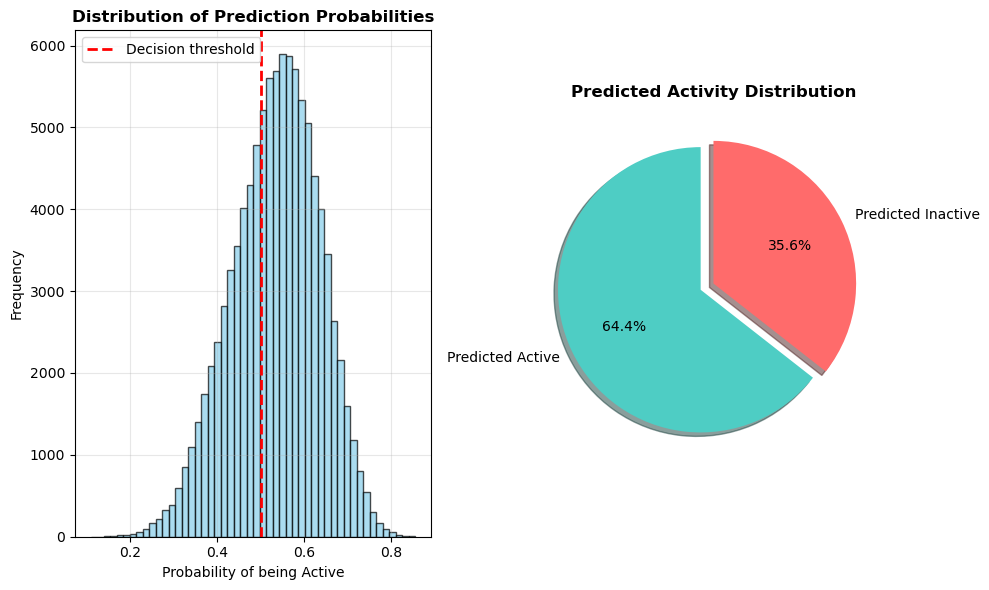

📈 Visualization saved as 'screening_results_visualization.png'

🎉 SCREENING PIPELINE COMPLETE!
Next steps you can take:
1. Analyze the screening_results.csv file
2. Perform SHAP analysis on the screening results
3. Screen with other models (XGBoost, ANN)
4. Combine predictions from multiple models
5. Generate chemical space visualization of screening results


In [5]:
# ============================================================================
# STEP 2: PREPARE FOR SCREENING WITH BEST MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 2: PREPARING FOR SCREENING")
print("="*80)

# Get the best model (Random Forest with Morgan Fingerprints)
best_model_info = None
if complete_results_df is not None:
    # Filter for RF with MorganFP
    best_models = complete_results_df[
        (complete_results_df['Model'] == 'RF') & 
        (complete_results_df['Feature_Type'] == 'MorganFP')
    ]
    
    if len(best_models) > 0:
        best_model_info = best_models.iloc[0]
        print(f"🎯 SELECTED BEST MODEL FOR SCREENING:")
        print(f"   Algorithm: {best_model_info['Model']}")
        print(f"   Feature Type: {best_model_info['Feature_Type']}")
        print(f"   AUC: {best_model_info['AUC']:.3f}")
        print(f"   Accuracy: {best_model_info['Accuracy']:.3f}")
        print(f"   F1-Score: {best_model_info['F1']:.3f}")
        
        # Load the model
        screening_model = get_model_updated('MorganFP', 'RF')
        if screening_model:
            print(f"   ✅ Model successfully loaded")
        else:
            print(f"   ❌ Failed to load model")
    else:
        print(f"❌ No RF model found for MorganFP in results")

# ============================================================================
# STEP 3: LOAD AND PROCESS SCREENING DATA (random.csv)
# ============================================================================

print("\n" + "="*80)
print("STEP 3: LOADING SCREENING DATA")
print("="*80)

# Define the molecular feature generator class
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

class ScreeningFeatureGenerator:
    """
    Generate Morgan fingerprints for screening compounds.
    """
    
    @staticmethod
    def sanitize_molecule(smiles):
        """Convert SMILES to RDKit molecule."""
        try:
            mol = Chem.MolFromSmiles(str(smiles))
            return mol
        except:
            return None
    
    @staticmethod
    def generate_morgan_fingerprint(smiles, radius=2, n_bits=2048):
        """
        Generate Morgan fingerprint for a single SMILES.
        """
        mol = ScreeningFeatureGenerator.sanitize_molecule(smiles)
        if mol is None:
            return np.zeros(n_bits)
        
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            return np.array([int(b) for b in fp.ToBitString()])
        except:
            return np.zeros(n_bits)
    
    @staticmethod
    def generate_morgan_fingerprints_batch(smiles_list, radius=2, n_bits=2048):
        """
        Generate Morgan fingerprints for a batch of SMILES.
        """
        fingerprints = []
        valid_indices = []
        valid_smiles = []
        
        for idx, smiles in enumerate(smiles_list):
            fp = ScreeningFeatureGenerator.generate_morgan_fingerprint(smiles, radius, n_bits)
            # Check if fingerprint is valid (not all zeros)
            if np.any(fp):
                fingerprints.append(fp)
                valid_indices.append(idx)
                valid_smiles.append(smiles)
        
        if fingerprints:
            return np.array(fingerprints), valid_indices, valid_smiles
        else:
            return np.array([]), [], []

# Load screening data
screening_file = 'random.csv'
if os.path.exists(screening_file):
    print(f"📂 Loading screening data from: {screening_file}")
    
    try:
        screening_data = pd.read_csv(screening_file)
        print(f"✅ Loaded successfully!")
        print(f"   Shape: {screening_data.shape}")
        print(f"   Columns: {', '.join(screening_data.columns)}")
        
        # Check required columns
        if 'SMILES' in screening_data.columns:
            print(f"   Total compounds: {len(screening_data):,}")
            
            # Display sample
            print(f"\n📋 Sample of screening data:")
            display(screening_data.head())
            
            # Check for missing values
            missing_smiles = screening_data['SMILES'].isna().sum()
            if missing_smiles > 0:
                print(f"⚠️ Warning: {missing_smiles} compounds have missing SMILES")
                screening_data = screening_data.dropna(subset=['SMILES'])
                print(f"   Remaining compounds: {len(screening_data):,}")
            
        else:
            print(f"❌ Error: 'SMILES' column not found in {screening_file}")
            print(f"   Available columns: {', '.join(screening_data.columns)}")
            screening_data = None
            
    except Exception as e:
        print(f"❌ Error loading {screening_file}: {e}")
        screening_data = None
else:
    print(f"❌ Screening file not found: {screening_file}")
    print(f"📁 Files in current directory:")
    for file in os.listdir('.')[:10]:
        print(f"   • {file}")
    screening_data = None

# ============================================================================
# STEP 4: GENERATE MORGAN FINGERPRINTS FOR SCREENING
# ============================================================================

print("\n" + "="*80)
print("STEP 4: GENERATING MORGAN FINGERPRINTS")
print("="*80)

if screening_data is not None and 'SMILES' in screening_data.columns:
    smiles_list = screening_data['SMILES'].tolist()
    zincid_list = screening_data['zincid'].tolist() if 'zincid' in screening_data.columns else list(range(len(smiles_list)))
    
    print(f"🔬 Generating Morgan fingerprints for {len(smiles_list):,} compounds...")
    
    # Generate fingerprints
    feat_generator = ScreeningFeatureGenerator()
    fingerprints, valid_indices, valid_smiles = feat_generator.generate_morgan_fingerprints_batch(
        smiles_list, radius=2, n_bits=2048
    )
    
    print(f"✅ Fingerprint generation completed!")
    print(f"   Valid compounds: {len(valid_indices):,} ({len(valid_indices)/len(smiles_list)*100:.1f}%)")
    print(f"   Invalid compounds: {len(smiles_list) - len(valid_indices):,}")
    print(f"   Fingerprint shape: {fingerprints.shape}")
    
    if len(valid_indices) > 0:
        # Create DataFrame with valid compounds
        valid_data = screening_data.iloc[valid_indices].copy()
        valid_data.reset_index(drop=True, inplace=True)
        
        # Save the generated fingerprints
        fp_df = pd.DataFrame(fingerprints, columns=[f'bit_{i}' for i in range(2048)])
        fp_df['zincid'] = [zincid_list[i] for i in valid_indices]
        fp_df['SMILES'] = valid_smiles
        
        # Save to file
        output_file = 'random_morgan_fingerprints.csv'
        fp_df.to_csv(output_file, index=False)
        print(f"💾 Saved fingerprints to: {output_file}")
        
        # Display sample
        print(f"\n📋 Sample of generated fingerprints (first 5 bits):")
        display(fp_df[['zincid', 'SMILES', 'bit_0', 'bit_1', 'bit_2', 'bit_3', 'bit_4']].head())
        
    else:
        print(f"❌ No valid fingerprints generated!")
        valid_data = None
        fp_df = None
        
else:
    print(f"❌ Cannot generate fingerprints - screening data not available")
    valid_data = None
    fp_df = None

# ============================================================================
# STEP 5: SCREEN COMPOUNDS WITH BEST MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 5: SCREENING COMPOUNDS WITH RF + MORGANFP MODEL")
print("="*80)

if screening_model is not None and fp_df is not None:
    print(f"🎯 Screening {len(fp_df):,} compounds using Random Forest (MorganFP)...")
    
    # Prepare features (exclude zincid and SMILES columns)
    feature_columns = [col for col in fp_df.columns if col.startswith('bit_')]
    X_screen = fp_df[feature_columns].values
    
    # Make predictions
    print(f"🔄 Making predictions...")
    y_pred = screening_model.predict(X_screen)
    y_pred_proba = screening_model.predict_proba(X_screen)[:, 1] if hasattr(screening_model, 'predict_proba') else None
    
    # Add predictions to dataframe
    screening_results = valid_data.copy()
    screening_results['Predicted_Activity'] = y_pred
    screening_results['Predicted_Label'] = ['Active' if pred == 1 else 'Inactive' for pred in y_pred]
    
    if y_pred_proba is not None:
        screening_results['Prediction_Probability'] = y_pred_proba
        screening_results['Active_Probability'] = y_pred_proba  # Probability of being active
    
    # Calculate statistics
    active_count = sum(y_pred == 1)
    inactive_count = sum(y_pred == 0)
    total_count = len(y_pred)
    
    print(f"✅ Screening completed!")
    print(f"\n📊 SCREENING RESULTS:")
    print(f"   Total compounds screened: {total_count:,}")
    print(f"   Predicted Active: {active_count:,} ({active_count/total_count*100:.1f}%)")
    print(f"   Predicted Inactive: {inactive_count:,} ({inactive_count/total_count*100:.1f}%)")
    
    if y_pred_proba is not None:
        avg_prob = np.mean(y_pred_proba)
        print(f"   Average active probability: {avg_prob:.3f}")
    
    # Save screening results
    results_file = 'random_screening_results.csv'
    screening_results.to_csv(results_file, index=False)
    print(f"💾 Results saved to: {results_file}")
    
    # Display top predicted active compounds
    if y_pred_proba is not None and active_count > 0:
        print(f"\n🏆 TOP 10 PREDICTED ACTIVE COMPOUNDS:")
        top_active = screening_results.nlargest(10, 'Active_Probability')
        
        # Create summary table
        top_summary = top_active[['zincid' if 'zincid' in top_active.columns else top_active.columns[0], 
                                 'SMILES', 'Active_Probability']].copy()
        top_summary = top_summary.round({'Active_Probability': 3})
        display(top_summary)
        
        # Save top active compounds
        top_active_file = 'random_top_active_compounds.csv'
        top_active.to_csv(top_active_file, index=False)
        print(f"💾 Top active compounds saved to: {top_active_file}")
    
    # Display sample of results
    print(f"\n📋 SAMPLE OF SCREENING RESULTS:")
    sample_cols = ['zincid' if 'zincid' in screening_results.columns else screening_results.columns[0], 
                  'SMILES', 'Predicted_Label']
    if 'Active_Probability' in screening_results.columns:
        sample_cols.append('Active_Probability')
    
    display(screening_results[sample_cols].head(10))
    
    # Create visualization of screening results
    print(f"\n📊 CREATING SCREENING VISUALIZATION...")
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    
    if y_pred_proba is not None:
        # Histogram of prediction probabilities
        plt.subplot(1, 2, 1)
        plt.hist(y_pred_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision threshold')
        plt.title('Distribution of Prediction Probabilities', fontsize=12, fontweight='bold')
        plt.xlabel('Probability of being Active', fontsize=10)
        plt.ylabel('Frequency', fontsize=10)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Pie chart of predicted classes
        plt.subplot(1, 2, 2)
        labels = ['Predicted Active', 'Predicted Inactive']
        sizes = [active_count, inactive_count]
        colors = ['#4ECDC4', '#FF6B6B']
        explode = (0.1, 0)  # explode the 1st slice
        
        plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=90)
        plt.title('Predicted Activity Distribution', fontsize=12, fontweight='bold')
        
    else:
        # Simple bar chart if probabilities not available
        plt.bar(['Active', 'Inactive'], [active_count, inactive_count], 
                color=['#4ECDC4', '#FF6B6B'], edgecolor='black')
        plt.title('Screening Results', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Activity', fontsize=12)
        plt.ylabel('Number of Compounds', fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, v in enumerate([active_count, inactive_count]):
            plt.text(i, v + max([active_count, inactive_count])*0.01, 
                    str(v), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('screening_results_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📈 Visualization saved as 'screening_results_visualization.png'")
    
else:
    print(f"❌ Cannot perform screening:")
    if screening_model is None:
        print(f"   - Screening model not loaded")
    if fp_df is None:
        print(f"   - Fingerprints not generated")

print("\n" + "="*80)
print("🎉 SCREENING PIPELINE COMPLETE!")
print("="*80)
print("Next steps you can take:")
print("1. Analyze the screening_results.csv file")
print("2. Perform SHAP analysis on the screening results")
print("3. Screen with other models (XGBoost, ANN)")
print("4. Combine predictions from multiple models")
print("5. Generate chemical space visualization of screening results")
print("="*80)

### Random Forest with RDKitFP

SCREENING WITH RDKitFP FEATURES
Model: Random Forest (RF) with RDKit Fingerprints
Performance: AUC = 0.971, Accuracy = 0.924

📂 Loading screening data...
✅ Loaded 100,000 compounds for screening

🔬 Generating RDKit fingerprints (2048 bits)...
✅ Fingerprint generation completed!
   Valid compounds: 100,000 (100.0%)
   Invalid compounds: 0
   Fingerprint shape: (100000, 2048)

🎯 Loading best RDKitFP model (Random Forest)...
✅ Model loaded successfully

🔄 Making predictions with RDKitFP model...

💾 Saving results...
📁 Created results directory: RDKitFP_Screening_Results/
✅ Results saved to: RDKitFP_Screening_Results\rdkitfp_screening_results.csv
✅ Summary saved to: RDKitFP_Screening_Results\screening_summary.json
✅ Top 100 active compounds saved to: RDKitFP_Screening_Results\top_100_active_rdkitfp.csv
✅ Top 100 inactive compounds saved to: RDKitFP_Screening_Results\top_100_inactive_rdkitfp.csv

RDKITFP SCREENING RESULTS SUMMARY
📊 Screening Statistics:
   Total compounds screened: 100,000


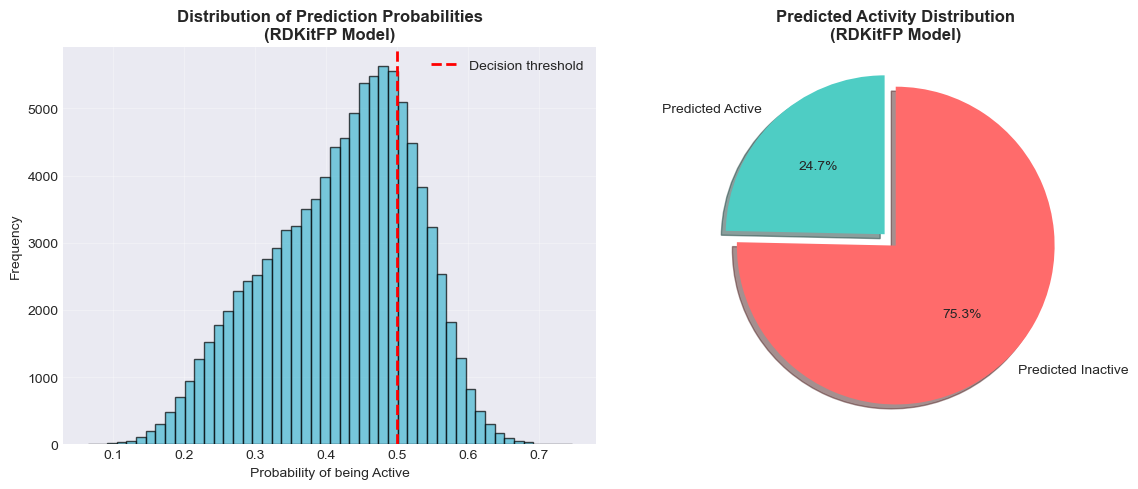

✅ Visualization saved to: RDKitFP_Screening_Results\rdkitfp_screening_visualization.png

COMPARISON WITH MORGANFP SCREENING
Compounds screened by both methods: 100,000
Agreement between models: 50,467 compounds (50.5%)
✅ Model comparison saved to: RDKitFP_Screening_Results\model_comparison_rdkitfp_vs_morganfp.csv

⚠️  Compounds with different predictions (49,533):
          zincid Predicted_Label_RDKitFP Predicted_Label
ZINCpj00000y8gsg                Inactive          Active
ZINCs500001zksmk                Inactive          Active
ZINCoq00000sXQlq                  Active        Inactive
ZINCoB00000J06ZN                  Active        Inactive
ZINCtF000002IVE2                Inactive          Active
ZINCtp00000g7irV                Inactive          Active
ZINCqA00000C3NLf                  Active        Inactive
ZINCoc00000HNiwn                Inactive          Active
ZINCpG00000FGeTn                Inactive          Active
ZINCsl00000zZ90X                Inactive          Active

🎉 RDK

In [6]:
# ============================================================================
# SCREENING WITH BEST RDKitFP MODEL (Random Forest)
# ============================================================================

print("="*80)
print("SCREENING WITH RDKitFP FEATURES")
print("="*80)
print("Model: Random Forest (RF) with RDKit Fingerprints")
print("Performance: AUC = 0.971, Accuracy = 0.924")
print("="*80)

# ============================================================================
# STEP 1: DEFINE RDKIT FINGERPRINT GENERATOR
# ============================================================================

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np

class RDKitFPGenerator:
    """
    Generate RDKit topological fingerprints for screening compounds.
    """
    
    @staticmethod
    def sanitize_molecule(smiles):
        """Convert SMILES to RDKit molecule."""
        try:
            mol = Chem.MolFromSmiles(str(smiles))
            return mol
        except:
            return None
    
    @staticmethod
    def generate_rdkit_fingerprint(smiles, n_bits=2048):
        """
        Generate RDKit topological fingerprint for a single SMILES.
        """
        mol = RDKitFPGenerator.sanitize_molecule(smiles)
        if mol is None:
            return np.zeros(n_bits)
        
        try:
            fp = Chem.RDKFingerprint(mol, fpSize=n_bits)
            return np.array([int(b) for b in fp.ToBitString()])
        except:
            return np.zeros(n_bits)
    
    @staticmethod
    def generate_rdkit_fingerprints_batch(smiles_list, n_bits=2048):
        """
        Generate RDKit fingerprints for a batch of SMILES.
        """
        fingerprints = []
        valid_indices = []
        valid_smiles = []
        
        for idx, smiles in enumerate(smiles_list):
            fp = RDKitFPGenerator.generate_rdkit_fingerprint(smiles, n_bits)
            # Check if fingerprint is valid (not all zeros)
            if np.any(fp):
                fingerprints.append(fp)
                valid_indices.append(idx)
                valid_smiles.append(smiles)
        
        if fingerprints:
            return np.array(fingerprints), valid_indices, valid_smiles
        else:
            return np.array([]), [], []

# ============================================================================
# STEP 2: LOAD SCREENING DATA
# ============================================================================

print("\n📂 Loading screening data...")
screening_data = pd.read_csv('random.csv')
smiles_list = screening_data['SMILES'].tolist()
zincid_list = screening_data['zincid'].tolist()

print(f"✅ Loaded {len(smiles_list):,} compounds for screening")

# ============================================================================
# STEP 3: GENERATE RDKIT FINGERPRINTS
# ============================================================================

print("\n🔬 Generating RDKit fingerprints (2048 bits)...")
rdkitfp_generator = RDKitFPGenerator()
fingerprints, valid_indices, valid_smiles = rdkitfp_generator.generate_rdkit_fingerprints_batch(
    smiles_list, n_bits=2048
)

print(f"✅ Fingerprint generation completed!")
print(f"   Valid compounds: {len(valid_indices):,} ({len(valid_indices)/len(smiles_list)*100:.1f}%)")
print(f"   Invalid compounds: {len(smiles_list) - len(valid_indices):,}")
print(f"   Fingerprint shape: {fingerprints.shape}")

# ============================================================================
# STEP 4: LOAD BEST RDKitFP MODEL
# ============================================================================

print("\n🎯 Loading best RDKitFP model (Random Forest)...")
rdkitfp_model = get_model_updated('RDKitFP', 'RF')

if rdkitfp_model is not None:
    print("✅ Model loaded successfully")
else:
    print("❌ Failed to load model")
    # Try alternative loading
    rdkitfp_model = loaded_models['scikit_models']['RDKitFP']['RF']
    if rdkitfp_model:
        print("✅ Model loaded via alternative method")

# ============================================================================
# STEP 5: MAKE PREDICTIONS
# ============================================================================

print("\n🔄 Making predictions with RDKitFP model...")

# Prepare features
X_screen = fingerprints

# Make predictions
y_pred = rdkitfp_model.predict(X_screen)
y_pred_proba = rdkitfp_model.predict_proba(X_screen)[:, 1]

# ============================================================================
# STEP 6: SAVE RESULTS
# ============================================================================

print("\n💾 Saving results...")

# Create results directory if it doesn't exist
results_dir = 'RDKitFP_Screening_Results'
os.makedirs(results_dir, exist_ok=True)
print(f"📁 Created results directory: {results_dir}/")

# Create DataFrame with valid compounds
valid_data = screening_data.iloc[valid_indices].copy()
valid_data.reset_index(drop=True, inplace=True)

# Add predictions
screening_results = valid_data.copy()
screening_results['Predicted_Activity_RDKitFP'] = y_pred
screening_results['Prediction_Probability_RDKitFP'] = y_pred_proba
screening_results['Predicted_Label_RDKitFP'] = ['Active' if pred == 1 else 'Inactive' for pred in y_pred]

# Calculate statistics
active_count = sum(y_pred == 1)
inactive_count = sum(y_pred == 0)
total_count = len(y_pred)
avg_prob = np.mean(y_pred_proba)

# Save comprehensive results
results_file = os.path.join(results_dir, 'rdkitfp_screening_results.csv')
screening_results.to_csv(results_file, index=False)
print(f"✅ Results saved to: {results_file}")

# Save summary statistics
summary_stats = {
    'total_compounds_screened': total_count,
    'predicted_active': int(active_count),
    'predicted_inactive': int(inactive_count),
    'active_percentage': float(active_count/total_count*100),
    'inactive_percentage': float(inactive_count/total_count*100),
    'average_active_probability': float(avg_prob),
    'model_name': 'Random Forest',
    'feature_type': 'RDKitFP',
    'model_performance_auc': 0.971,
    'model_performance_accuracy': 0.924
}

import json
summary_file = os.path.join(results_dir, 'screening_summary.json')
with open(summary_file, 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"✅ Summary saved to: {summary_file}")

# Save top predicted active compounds
top_active = screening_results.nlargest(100, 'Prediction_Probability_RDKitFP')
top_active_file = os.path.join(results_dir, 'top_100_active_rdkitfp.csv')
top_active.to_csv(top_active_file, index=False)
print(f"✅ Top 100 active compounds saved to: {top_active_file}")

# Save top predicted inactive compounds (lowest probability)
top_inactive = screening_results.nsmallest(100, 'Prediction_Probability_RDKitFP')
top_inactive_file = os.path.join(results_dir, 'top_100_inactive_rdkitfp.csv')
top_inactive.to_csv(top_inactive_file, index=False)
print(f"✅ Top 100 inactive compounds saved to: {top_inactive_file}")

# ============================================================================
# STEP 7: DISPLAY RESULTS
# ============================================================================

print("\n" + "="*80)
print("RDKITFP SCREENING RESULTS SUMMARY")
print("="*80)
print(f"📊 Screening Statistics:")
print(f"   Total compounds screened: {total_count:,}")
print(f"   Predicted Active: {active_count:,} ({active_count/total_count*100:.1f}%)")
print(f"   Predicted Inactive: {inactive_count:,} ({inactive_count/total_count*100:.1f}%)")
print(f"   Average active probability: {avg_prob:.3f}")

print(f"\n🏆 Top 5 Predicted Active Compounds:")
top_5 = screening_results.nlargest(5, 'Prediction_Probability_RDKitFP')
for i, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"   {i}. {row['zincid']}")
    print(f"      Probability: {row['Prediction_Probability_RDKitFP']:.3f}")
    print(f"      SMILES: {row['SMILES'][:50]}...")

print(f"\n📋 Sample of Results:")
sample = screening_results[['zincid', 'Predicted_Label_RDKitFP', 'Prediction_Probability_RDKitFP']].head(5)
print(sample.to_string(index=False))

# ============================================================================
# STEP 8: CREATE VISUALIZATIONS
# ============================================================================

print("\n📊 Creating visualizations...")

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Histogram of prediction probabilities
axes[0].hist(y_pred_proba, bins=50, alpha=0.7, color='#45B7D1', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision threshold')
axes[0].set_title('Distribution of Prediction Probabilities\n(RDKitFP Model)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Probability of being Active', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Pie chart of predicted classes
labels = ['Predicted Active', 'Predicted Inactive']
sizes = [active_count, inactive_count]
colors = ['#4ECDC4', '#FF6B6B']
explode = (0.1, 0)

axes[1].pie(sizes, explode=explode, labels=labels, colors=colors,
           autopct='%1.1f%%', shadow=True, startangle=90,
           textprops={'fontsize': 10})
axes[1].set_title('Predicted Activity Distribution\n(RDKitFP Model)', fontsize=12, fontweight='bold')

plt.tight_layout()
viz_file = os.path.join(results_dir, 'rdkitfp_screening_visualization.png')
plt.savefig(viz_file, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Visualization saved to: {viz_file}")

# ============================================================================
# STEP 9: COMPARE WITH MORGANFP RESULTS
# ============================================================================

print("\n" + "="*80)
print("COMPARISON WITH MORGANFP SCREENING")
print("="*80)

# Load MorganFP results if available
morgan_results_file = 'random_screening_results.csv'
if os.path.exists(morgan_results_file):
    morgan_results = pd.read_csv(morgan_results_file)
    
    # Get common compounds for comparison
    rdkitfp_zincids = set(screening_results['zincid'])
    morgan_zincids = set(morgan_results['zincid'])
    common_zincids = rdkitfp_zincids.intersection(morgan_zincids)
    
    print(f"Compounds screened by both methods: {len(common_zincids):,}")
    
    if len(common_zincids) > 0:
        # Get predictions for common compounds
        rdkitfp_common = screening_results[screening_results['zincid'].isin(common_zincids)]
        morgan_common = morgan_results[morgan_results['zincid'].isin(common_zincids)]
        
        # Merge for comparison
        comparison = pd.merge(
            rdkitfp_common[['zincid', 'Predicted_Label_RDKitFP', 'Prediction_Probability_RDKitFP']],
            morgan_common[['zincid', 'Predicted_Label', 'Active_Probability']],
            on='zincid'
        )
        
        # Calculate agreement
        agreement = (comparison['Predicted_Label_RDKitFP'] == comparison['Predicted_Label']).sum()
        agreement_pct = agreement / len(comparison) * 100
        
        print(f"Agreement between models: {agreement:,} compounds ({agreement_pct:.1f}%)")
        
        # Save comparison
        comparison_file = os.path.join(results_dir, 'model_comparison_rdkitfp_vs_morganfp.csv')
        comparison.to_csv(comparison_file, index=False)
        print(f"✅ Model comparison saved to: {comparison_file}")
        
        # Display disagreement cases
        disagreement = comparison[comparison['Predicted_Label_RDKitFP'] != comparison['Predicted_Label']]
        if len(disagreement) > 0:
            print(f"\n⚠️  Compounds with different predictions ({len(disagreement):,}):")
            print(disagreement[['zincid', 'Predicted_Label_RDKitFP', 'Predicted_Label']].head(10).to_string(index=False))
    else:
        print("No common compounds found for comparison")
else:
    print("MorganFP results not found for comparison")

print("\n" + "="*80)
print("🎉 RDKITFP SCREENING COMPLETE!")
print("="*80)
print(f"📁 All results saved in: {results_dir}/")
print(f"📄 Files created:")
print(f"   1. rdkitfp_screening_results.csv - Full screening results")
print(f"   2. screening_summary.json - Summary statistics")
print(f"   3. top_100_active_rdkitfp.csv - Top 100 active compounds")
print(f"   4. top_100_inactive_rdkitfp.csv - Top 100 inactive compounds")
print(f"   5. rdkitfp_screening_visualization.png - Visualizations")
print(f"   6. model_comparison_rdkitfp_vs_morganfp.csv - Model comparison (if available)")
print("="*80)

### Random Forest with RDKit Descriptors

SCREENING WITH RDKitDes FEATURES
Model: Random Forest (RF) with RDKit Descriptors
Performance: AUC = 0.915, Accuracy = 0.866

📂 Loading screening data...
✅ Loaded 100,000 compounds for screening

🔬 Generating RDKit molecular descriptors (12 descriptors)...
✅ Descriptor generation completed!
   Valid compounds: 100,000 (100.0%)
   Invalid compounds: 0
   Descriptor shape: (100000, 12)

📊 Descriptor Statistics (mean values):
   MolWt          : 386.96
   LogP           : 2.28
   TPSA           : 80.75
   HAcceptors     : 4.74
   HDonors        : 1.53
   RotBonds       : 6.62
   AroRings       : 1.23
   AliRings       : 1.73
   Heteroatoms    : 7.50
   FracCSP3       : 0.62
   HeavyAtoms     : 26.91
   RingCount      : 2.96

🎯 Loading best RDKitDes model (Random Forest)...
✅ Model loaded successfully

🔄 Making predictions with RDKitDes model...

💾 Saving results...
📁 Created results directory: RDKitDes_Screening_Results/
✅ Results saved to: RDKitDes_Screening_Results\rdkitdes_screening_re

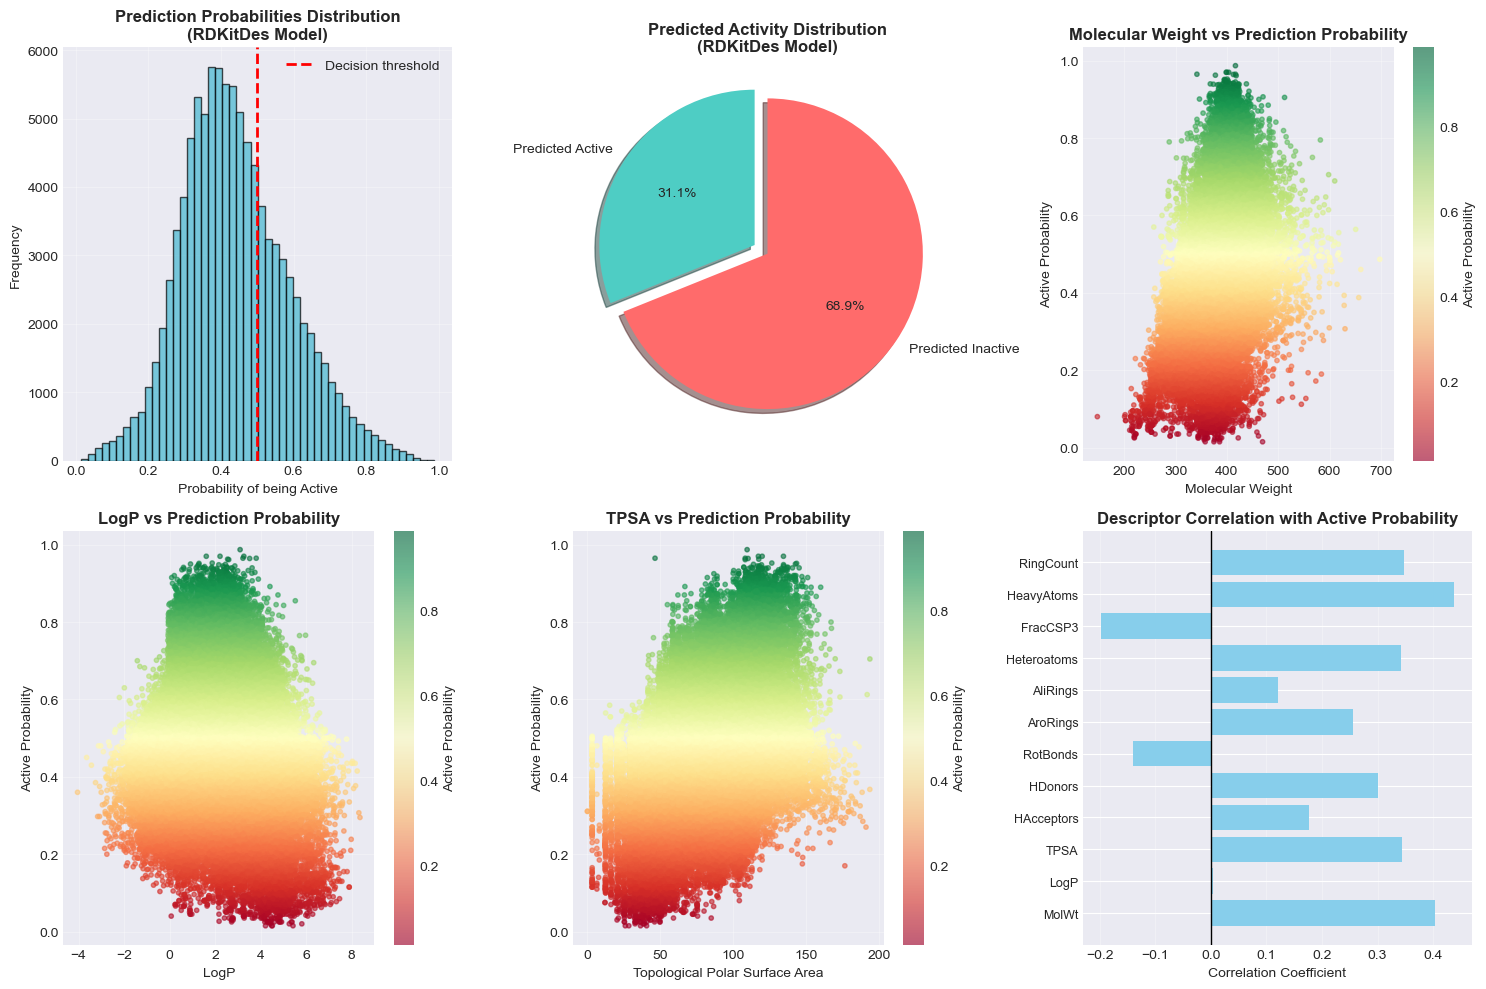

✅ Visualization saved to: RDKitDes_Screening_Results\rdkitdes_screening_visualization.png

COMPARISON WITH PREVIOUS SCREENING RESULTS
✅ Loaded MorganFP results
✅ Loaded RDKitFP results

Compounds screened by all models: 100,000
   (Using 1,000 compounds for comparison)

📊 Model Agreement Statistics (on 1000 compounds):
   MorganFP vs RDKitFP: 514 compounds (51.4% agreement)
✅ Model comparison saved to: RDKitDes_Screening_Results\three_model_comparison.csv

🎉 RDKITDES SCREENING COMPLETE!
📁 All results saved in: RDKitDes_Screening_Results/
📄 Files created:
   1. rdkitdes_screening_results.csv - Full screening results with descriptors
   2. screening_summary.json - Summary with descriptor statistics
   3. top_100_active_rdkitdes.csv - Top 100 active compounds
   4. top_100_inactive_rdkitdes.csv - Top 100 inactive compounds
   5. rdkitdes_screening_visualization.png - 6 visualization plots
   6. three_model_comparison.csv - Comparison with other models (if available)
Next: PubChemFP screen

In [7]:
# ============================================================================
# SCREENING WITH RDKitDes FEATURES (RDKit Descriptors)
# ============================================================================

print("="*80)
print("SCREENING WITH RDKitDes FEATURES")
print("="*80)
print("Model: Random Forest (RF) with RDKit Descriptors")
print("Performance: AUC = 0.915, Accuracy = 0.866")
print("="*80)

# ============================================================================
# STEP 1: DEFINE RDKIT DESCRIPTOR GENERATOR
# ============================================================================

from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np

class RDKitDescriptorGenerator:
    """
    Generate RDKit molecular descriptors for screening compounds.
    """
    
    @staticmethod
    def sanitize_molecule(smiles):
        """Convert SMILES to RDKit molecule."""
        try:
            mol = Chem.MolFromSmiles(str(smiles))
            return mol
        except:
            return None
    
    @staticmethod
    def generate_rdkit_descriptors(smiles):
        """
        Generate RDKit molecular descriptors for a single SMILES.
        Returns 12 descriptors (same as training).
        """
        mol = RDKitDescriptorGenerator.sanitize_molecule(smiles)
        if mol is None:
            return np.zeros(12)  # 12 descriptors as per training
        
        try:
            # Generate the same 12 descriptors used in training
            descriptors = [
                Descriptors.MolWt(mol),              # Molecular Weight
                Descriptors.MolLogP(mol),            # LogP
                Descriptors.TPSA(mol),               # Topological Polar Surface Area
                Descriptors.NumHAcceptors(mol),      # Number of H-bond acceptors
                Descriptors.NumHDonors(mol),         # Number of H-bond donors
                Descriptors.NumRotatableBonds(mol),  # Number of rotatable bonds
                Descriptors.NumAromaticRings(mol),   # Number of aromatic rings
                Descriptors.NumAliphaticRings(mol),  # Number of aliphatic rings
                Descriptors.NumHeteroatoms(mol),     # Number of heteroatoms
                Descriptors.FractionCSP3(mol),       # Fraction of sp3 carbons
                Descriptors.HeavyAtomCount(mol),     # Heavy atom count
                Descriptors.RingCount(mol)           # Ring count
            ]
            
            # Replace NaN with 0
            descriptors = [0 if pd.isna(d) else d for d in descriptors]
            return np.array(descriptors)
            
        except:
            return np.zeros(12)
    
    @staticmethod
    def generate_rdkit_descriptors_batch(smiles_list):
        """
        Generate RDKit descriptors for a batch of SMILES.
        """
        descriptors = []
        valid_indices = []
        valid_smiles = []
        
        for idx, smiles in enumerate(smiles_list):
            desc = RDKitDescriptorGenerator.generate_rdkit_descriptors(smiles)
            # Check if descriptors are valid (not all zeros)
            if np.any(desc):
                descriptors.append(desc)
                valid_indices.append(idx)
                valid_smiles.append(smiles)
        
        if descriptors:
            return np.array(descriptors), valid_indices, valid_smiles
        else:
            return np.array([]), [], []

# ============================================================================
# STEP 2: LOAD SCREENING DATA
# ============================================================================

print("\n📂 Loading screening data...")
screening_data = pd.read_csv('random.csv')
smiles_list = screening_data['SMILES'].tolist()
zincid_list = screening_data['zincid'].tolist()

print(f"✅ Loaded {len(smiles_list):,} compounds for screening")

# ============================================================================
# STEP 3: GENERATE RDKIT DESCRIPTORS
# ============================================================================

print("\n🔬 Generating RDKit molecular descriptors (12 descriptors)...")
descriptor_generator = RDKitDescriptorGenerator()
descriptors, valid_indices, valid_smiles = descriptor_generator.generate_rdkit_descriptors_batch(
    smiles_list
)

print(f"✅ Descriptor generation completed!")
print(f"   Valid compounds: {len(valid_indices):,} ({len(valid_indices)/len(smiles_list)*100:.1f}%)")
print(f"   Invalid compounds: {len(smiles_list) - len(valid_indices):,}")
print(f"   Descriptor shape: {descriptors.shape}")

# Display descriptor statistics
if len(descriptors) > 0:
    print(f"\n📊 Descriptor Statistics (mean values):")
    desc_names = ['MolWt', 'LogP', 'TPSA', 'HAcceptors', 'HDonors', 'RotBonds',
                  'AroRings', 'AliRings', 'Heteroatoms', 'FracCSP3', 'HeavyAtoms', 'RingCount']
    for i, name in enumerate(desc_names):
        print(f"   {name:15s}: {np.mean(descriptors[:, i]):.2f}")

# ============================================================================
# STEP 4: LOAD BEST RDKitDes MODEL
# ============================================================================

print("\n🎯 Loading best RDKitDes model (Random Forest)...")
rdkitdes_model = get_model_updated('RDKitDes', 'RF')

if rdkitdes_model is not None:
    print("✅ Model loaded successfully")
else:
    print("❌ Failed to load model")
    # Try alternative loading
    rdkitdes_model = loaded_models['scikit_models']['RDKitDes']['RF']
    if rdkitdes_model:
        print("✅ Model loaded via alternative method")

# ============================================================================
# STEP 5: MAKE PREDICTIONS
# ============================================================================

print("\n🔄 Making predictions with RDKitDes model...")

# Prepare features
X_screen = descriptors

# Make predictions
y_pred = rdkitdes_model.predict(X_screen)
y_pred_proba = rdkitdes_model.predict_proba(X_screen)[:, 1]

# ============================================================================
# STEP 6: SAVE RESULTS
# ============================================================================

print("\n💾 Saving results...")

# Create results directory if it doesn't exist
results_dir = 'RDKitDes_Screening_Results'
os.makedirs(results_dir, exist_ok=True)
print(f"📁 Created results directory: {results_dir}/")

# Create DataFrame with valid compounds
valid_data = screening_data.iloc[valid_indices].copy()
valid_data.reset_index(drop=True, inplace=True)

# Add predictions
screening_results = valid_data.copy()
screening_results['Predicted_Activity_RDKitDes'] = y_pred
screening_results['Prediction_Probability_RDKitDes'] = y_pred_proba
screening_results['Predicted_Label_RDKitDes'] = ['Active' if pred == 1 else 'Inactive' for pred in y_pred]

# Add descriptor values for analysis
desc_names = ['MolWt', 'LogP', 'TPSA', 'HAcceptors', 'HDonors', 'RotBonds',
              'AroRings', 'AliRings', 'Heteroatoms', 'FracCSP3', 'HeavyAtoms', 'RingCount']
for i, name in enumerate(desc_names):
    screening_results[f'Descriptor_{name}'] = descriptors[:, i]

# Calculate statistics
active_count = sum(y_pred == 1)
inactive_count = sum(y_pred == 0)
total_count = len(y_pred)
avg_prob = np.mean(y_pred_proba)

# Save comprehensive results
results_file = os.path.join(results_dir, 'rdkitdes_screening_results.csv')
screening_results.to_csv(results_file, index=False)
print(f"✅ Results saved to: {results_file}")

# Save summary statistics
summary_stats = {
    'total_compounds_screened': total_count,
    'predicted_active': int(active_count),
    'predicted_inactive': int(inactive_count),
    'active_percentage': float(active_count/total_count*100),
    'inactive_percentage': float(inactive_count/total_count*100),
    'average_active_probability': float(avg_prob),
    'model_name': 'Random Forest',
    'feature_type': 'RDKitDes',
    'model_performance_auc': 0.915,
    'model_performance_accuracy': 0.866,
    'descriptor_statistics': {
        name: {
            'mean': float(np.mean(descriptors[:, i])),
            'std': float(np.std(descriptors[:, i])),
            'min': float(np.min(descriptors[:, i])),
            'max': float(np.max(descriptors[:, i]))
        }
        for i, name in enumerate(desc_names)
    }
}

summary_file = os.path.join(results_dir, 'screening_summary.json')
with open(summary_file, 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"✅ Summary saved to: {summary_file}")

# Save top predicted active compounds
top_active = screening_results.nlargest(100, 'Prediction_Probability_RDKitDes')
top_active_file = os.path.join(results_dir, 'top_100_active_rdkitdes.csv')
top_active.to_csv(top_active_file, index=False)
print(f"✅ Top 100 active compounds saved to: {top_active_file}")

# Save top predicted inactive compounds
top_inactive = screening_results.nsmallest(100, 'Prediction_Probability_RDKitDes')
top_inactive_file = os.path.join(results_dir, 'top_100_inactive_rdkitdes.csv')
top_inactive.to_csv(top_inactive_file, index=False)
print(f"✅ Top 100 inactive compounds saved to: {top_inactive_file}")

# ============================================================================
# STEP 7: DISPLAY RESULTS
# ============================================================================

print("\n" + "="*80)
print("RDKITDES SCREENING RESULTS SUMMARY")
print("="*80)
print(f"📊 Screening Statistics:")
print(f"   Total compounds screened: {total_count:,}")
print(f"   Predicted Active: {active_count:,} ({active_count/total_count*100:.1f}%)")
print(f"   Predicted Inactive: {inactive_count:,} ({inactive_count/total_count*100:.1f}%)")
print(f"   Average active probability: {avg_prob:.3f}")

print(f"\n🏆 Top 5 Predicted Active Compounds:")
top_5 = screening_results.nlargest(5, 'Prediction_Probability_RDKitDes')
for i, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"   {i}. {row['zincid']}")
    print(f"      Probability: {row['Prediction_Probability_RDKitDes']:.3f}")
    print(f"      Molecular Weight: {row['Descriptor_MolWt']:.1f}")
    print(f"      LogP: {row['Descriptor_LogP']:.2f}")
    print(f"      SMILES: {row['SMILES'][:50]}...")

print(f"\n📋 Sample of Results:")
sample_cols = ['zincid', 'Predicted_Label_RDKitDes', 'Prediction_Probability_RDKitDes',
               'Descriptor_MolWt', 'Descriptor_LogP']
sample = screening_results[sample_cols].head(5)
print(sample.to_string(index=False))

# ============================================================================
# STEP 8: CREATE VISUALIZATIONS
# ============================================================================

print("\n📊 Creating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Histogram of prediction probabilities
axes[0, 0].hist(y_pred_proba, bins=50, alpha=0.7, color='#45B7D1', edgecolor='black')
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision threshold')
axes[0, 0].set_title('Prediction Probabilities Distribution\n(RDKitDes Model)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Probability of being Active', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Pie chart of predicted classes
labels = ['Predicted Active', 'Predicted Inactive']
sizes = [active_count, inactive_count]
colors = ['#4ECDC4', '#FF6B6B']
explode = (0.1, 0)

axes[0, 1].pie(sizes, explode=explode, labels=labels, colors=colors,
               autopct='%1.1f%%', shadow=True, startangle=90,
               textprops={'fontsize': 10})
axes[0, 1].set_title('Predicted Activity Distribution\n(RDKitDes Model)', fontsize=12, fontweight='bold')

# Plot 3: Molecular Weight vs Prediction Probability
scatter1 = axes[0, 2].scatter(screening_results['Descriptor_MolWt'], 
                              screening_results['Prediction_Probability_RDKitDes'],
                              c=screening_results['Prediction_Probability_RDKitDes'],
                              cmap='RdYlGn', alpha=0.6, s=10)
axes[0, 2].set_title('Molecular Weight vs Prediction Probability', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Molecular Weight', fontsize=10)
axes[0, 2].set_ylabel('Active Probability', fontsize=10)
axes[0, 2].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 2], label='Active Probability')

# Plot 4: LogP vs Prediction Probability
scatter2 = axes[1, 0].scatter(screening_results['Descriptor_LogP'], 
                              screening_results['Prediction_Probability_RDKitDes'],
                              c=screening_results['Prediction_Probability_RDKitDes'],
                              cmap='RdYlGn', alpha=0.6, s=10)
axes[1, 0].set_title('LogP vs Prediction Probability', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('LogP', fontsize=10)
axes[1, 0].set_ylabel('Active Probability', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1, 0], label='Active Probability')

# Plot 5: TPSA vs Prediction Probability
scatter3 = axes[1, 1].scatter(screening_results['Descriptor_TPSA'], 
                              screening_results['Prediction_Probability_RDKitDes'],
                              c=screening_results['Prediction_Probability_RDKitDes'],
                              cmap='RdYlGn', alpha=0.6, s=10)
axes[1, 1].set_title('TPSA vs Prediction Probability', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Topological Polar Surface Area', fontsize=10)
axes[1, 1].set_ylabel('Active Probability', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1, 1], label='Active Probability')

# Plot 6: Descriptor correlation with activity probability
# Calculate correlation of each descriptor with prediction probability
correlations = []
for name in desc_names:
    corr = np.corrcoef(screening_results[f'Descriptor_{name}'], 
                       screening_results['Prediction_Probability_RDKitDes'])[0, 1]
    correlations.append(corr)

axes[1, 2].barh(range(len(desc_names)), correlations, color='skyblue')
axes[1, 2].set_yticks(range(len(desc_names)))
axes[1, 2].set_yticklabels(desc_names, fontsize=9)
axes[1, 2].set_title('Descriptor Correlation with Active Probability', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Correlation Coefficient', fontsize=10)
axes[1, 2].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
viz_file = os.path.join(results_dir, 'rdkitdes_screening_visualization.png')
plt.savefig(viz_file, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Visualization saved to: {viz_file}")

# ============================================================================
# STEP 9: COMPARE WITH PREVIOUS SCREENING RESULTS
# ============================================================================

print("\n" + "="*80)
print("COMPARISON WITH PREVIOUS SCREENING RESULTS")
print("="*80)

# Load previous results for comparison
comparison_data = []
model_names = ['MorganFP', 'RDKitFP']
results_files = ['random_screening_results.csv', 
                 'RDKitFP_Screening_Results/rdkitfp_screening_results.csv']

for model_name, results_file in zip(model_names, results_files):
    if os.path.exists(results_file):
        try:
            df = pd.read_csv(results_file)
            # Get appropriate column names
            if model_name == 'MorganFP':
                prob_col = 'Active_Probability'
                label_col = 'Predicted_Label'
            else:
                prob_col = 'Prediction_Probability_RDKitFP'
                label_col = 'Predicted_Label_RDKitFP'
            
            # Add to comparison data
            comparison_data.append({
                'model': model_name,
                'data': df,
                'prob_col': prob_col,
                'label_col': label_col
            })
            print(f"✅ Loaded {model_name} results")
        except:
            print(f"❌ Failed to load {model_name} results")
    else:
        print(f"❌ {model_name} results not found")

# Create comparison if we have multiple models
if len(comparison_data) >= 2:
    # Get common compounds
    common_zincids = set(screening_results['zincid'])
    for comp in comparison_data:
        common_zincids = common_zincids.intersection(set(comp['data']['zincid']))
    
    print(f"\nCompounds screened by all models: {len(common_zincids):,}")
    
    if len(common_zincids) > 1000:  # Sample if too many
        common_zincids = list(common_zincids)[:1000]
        print(f"   (Using 1,000 compounds for comparison)")
    
    if len(common_zincids) > 0:
        # Create comparison DataFrame
        comparison_df = pd.DataFrame({'zincid': list(common_zincids)})
        
        # Add predictions from each model
        comparison_df = pd.merge(comparison_df, 
                                screening_results[['zincid', 'Prediction_Probability_RDKitDes', 'Predicted_Label_RDKitDes']], 
                                on='zincid')
        
        for comp in comparison_data:
            temp = comp['data'][['zincid', comp['prob_col'], comp['label_col']]].copy()
            temp = temp.rename(columns={
                comp['prob_col']: f'Probability_{comp["model"]}',
                comp['label_col']: f'Label_{comp["model"]}'
            })
            comparison_df = pd.merge(comparison_df, temp, on='zincid')
        
        # Calculate agreement statistics
        print(f"\n📊 Model Agreement Statistics (on {len(comparison_df)} compounds):")
        
        # Pairwise agreement
        model_pairs = [('RDKitDes', 'MorganFP'), ('RDKitDes', 'RDKitFP'), ('MorganFP', 'RDKitFP')]
        
        for model1, model2 in model_pairs:
            if f'Label_{model1}' in comparison_df.columns and f'Label_{model2}' in comparison_df.columns:
                agreement = (comparison_df[f'Label_{model1}'] == comparison_df[f'Label_{model2}']).sum()
                agreement_pct = agreement / len(comparison_df) * 100
                print(f"   {model1} vs {model2}: {agreement:,} compounds ({agreement_pct:.1f}% agreement)")
        
        # Save comparison
        comparison_file = os.path.join(results_dir, 'three_model_comparison.csv')
        comparison_df.to_csv(comparison_file, index=False)
        print(f"✅ Model comparison saved to: {comparison_file}")
        
        # Display compounds where all models disagree
        if 'Label_MorganFP' in comparison_df.columns and 'Label_RDKitFP' in comparison_df.columns:
            all_disagree = comparison_df[
                (comparison_df['Predicted_Label_RDKitDes'] != comparison_df['Label_MorganFP']) &
                (comparison_df['Predicted_Label_RDKitDes'] != comparison_df['Label_RDKitFP']) &
                (comparison_df['Label_MorganFP'] != comparison_df['Label_RDKitFP'])
            ]
            
            if len(all_disagree) > 0:
                print(f"\n⚠️  Compounds with disagreement among all 3 models: {len(all_disagree):,}")
                print(all_disagree[['zincid', 'Predicted_Label_RDKitDes', 'Label_MorganFP', 'Label_RDKitFP']].head(5).to_string(index=False))

print("\n" + "="*80)
print("🎉 RDKITDES SCREENING COMPLETE!")
print("="*80)
print(f"📁 All results saved in: {results_dir}/")
print(f"📄 Files created:")
print(f"   1. rdkitdes_screening_results.csv - Full screening results with descriptors")
print(f"   2. screening_summary.json - Summary with descriptor statistics")
print(f"   3. top_100_active_rdkitdes.csv - Top 100 active compounds")
print(f"   4. top_100_inactive_rdkitdes.csv - Top 100 inactive compounds")
print(f"   5. rdkitdes_screening_visualization.png - 6 visualization plots")
print(f"   6. three_model_comparison.csv - Comparison with other models (if available)")
print("="*80)
print("Next: PubChemFP screening")
print("="*80)

### XGBoost with PubChemFP

SCREENING WITH PubChemFP FEATURES
Model: XGBoost (XGB) with PubChem Fingerprints
Performance: AUC = 0.972, Accuracy = 0.923
This was your overall BEST performing model!

📂 Loading screening data...
✅ Loaded 100,000 compounds for screening

🔬 Generating PubChem fingerprints (881 bits)...
✅ Fingerprint generation completed!
   Valid compounds: 100,000 (100.0%)
   Invalid compounds: 0
   Fingerprint shape: (100000, 881)
   Active fingerprint bits: 749 out of 881 (85.0%)

🎯 Loading BEST PubChemFP model (XGBoost - AUC 0.972)...
✅ Best model (XGBoost) loaded successfully

🔄 Making predictions with PubChemFP model...

💾 Saving results...
📁 Created results directory: PubChemFP_Screening_Results/
✅ Results saved to: PubChemFP_Screening_Results\pubchemfp_screening_results.csv
✅ Summary saved to: PubChemFP_Screening_Results\screening_summary.json
✅ Top 100 active compounds saved to: PubChemFP_Screening_Results\top_100_active_pubchemfp.csv
✅ Top 100 inactive compounds saved to: PubChemFP_Screening

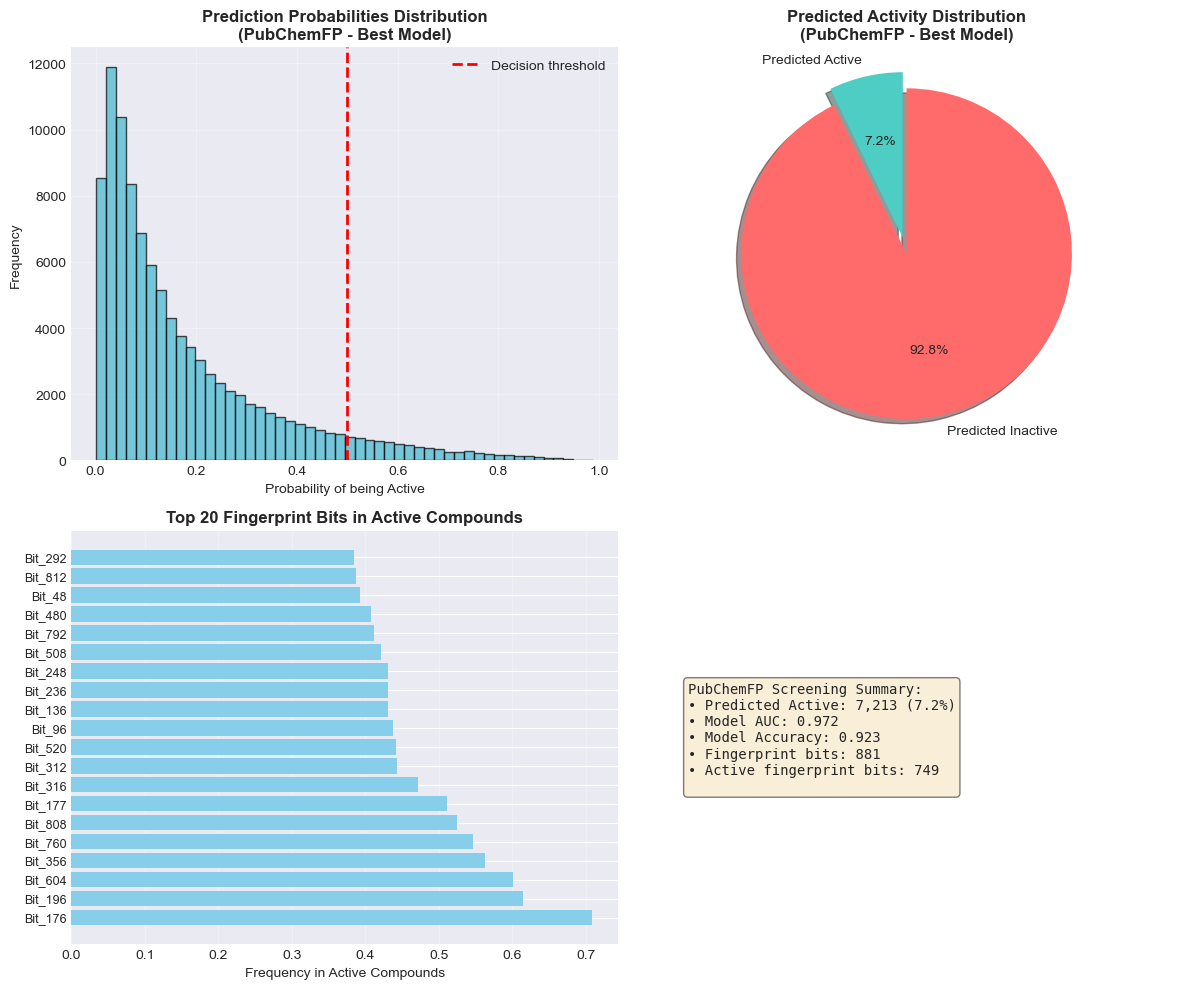

✅ Visualization saved to: PubChemFP_Screening_Results\pubchemfp_screening_visualization.png

COMPREHENSIVE MODEL COMPARISON
✅ Loaded MorganFP results
✅ Loaded RDKitFP results
✅ Loaded RDKitDes results
✅ Loaded PubChemFP results

Compounds screened by all models: 100,000

📊 Model Agreement Statistics (on 1000 compounds):
   MorganFP   vs RDKitFP   :  51.4% agreement
   MorganFP   vs RDKitDes  :  49.0% agreement
   MorganFP   vs PubChemFP :  42.8% agreement
   RDKitFP    vs RDKitDes  :  69.0% agreement
   RDKitFP    vs PubChemFP :  75.6% agreement
   RDKitDes   vs PubChemFP :  70.2% agreement
✅ Comprehensive comparison saved to: PubChemFP_Screening_Results\four_model_comprehensive_comparison.csv
✅ Agreement matrix saved to: PubChemFP_Screening_Results\model_agreement_matrix.csv

🤝 CONSENSUS ANALYSIS:
   Compounds predicted ACTIVE by all models: 25
   ✅ Consensus active compounds saved to: PubChemFP_Screening_Results\consensus_active_compounds.csv
   Compounds predicted INACTIVE by all mo

In [8]:
# ============================================================================
# SCREENING WITH PubChemFP FEATURES
# ============================================================================

print("="*80)
print("SCREENING WITH PubChemFP FEATURES")
print("="*80)
print("Model: XGBoost (XGB) with PubChem Fingerprints")
print("Performance: AUC = 0.972, Accuracy = 0.923")
print("This was your overall BEST performing model!")
print("="*80)

# ============================================================================
# STEP 1: DEFINE PUBCHEM FINGERPRINT GENERATOR
# ============================================================================

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np

class PubChemFPGenerator:
    """
    Generate PubChem-like fingerprints for screening compounds.
    Using topological torsion fingerprint as PubChem substitute (881 bits).
    """
    
    @staticmethod
    def sanitize_molecule(smiles):
        """Convert SMILES to RDKit molecule."""
        try:
            mol = Chem.MolFromSmiles(str(smiles))
            return mol
        except:
            return None
    
    @staticmethod
    def generate_pubchem_fingerprint(smiles, n_bits=881):
        """
        Generate PubChem-like fingerprint for a single SMILES.
        Using topological torsion fingerprint as substitute.
        """
        mol = PubChemFPGenerator.sanitize_molecule(smiles)
        if mol is None:
            return np.zeros(n_bits)
        
        try:
            fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=n_bits)
            return np.array([int(b) for b in fp.ToBitString()])
        except:
            return np.zeros(n_bits)
    
    @staticmethod
    def generate_pubchem_fingerprints_batch(smiles_list, n_bits=881):
        """
        Generate PubChem fingerprints for a batch of SMILES.
        """
        fingerprints = []
        valid_indices = []
        valid_smiles = []
        
        for idx, smiles in enumerate(smiles_list):
            fp = PubChemFPGenerator.generate_pubchem_fingerprint(smiles, n_bits)
            # Check if fingerprint is valid (not all zeros)
            if np.any(fp):
                fingerprints.append(fp)
                valid_indices.append(idx)
                valid_smiles.append(smiles)
        
        if fingerprints:
            return np.array(fingerprints), valid_indices, valid_smiles
        else:
            return np.array([]), [], []

# ============================================================================
# STEP 2: LOAD SCREENING DATA
# ============================================================================

print("\n📂 Loading screening data...")
screening_data = pd.read_csv('random.csv')
smiles_list = screening_data['SMILES'].tolist()
zincid_list = screening_data['zincid'].tolist()

print(f"✅ Loaded {len(smiles_list):,} compounds for screening")

# ============================================================================
# STEP 3: GENERATE PUBCHEM FINGERPRINTS
# ============================================================================

print("\n🔬 Generating PubChem fingerprints (881 bits)...")
pubchem_generator = PubChemFPGenerator()
fingerprints, valid_indices, valid_smiles = pubchem_generator.generate_pubchem_fingerprints_batch(
    smiles_list, n_bits=881
)

print(f"✅ Fingerprint generation completed!")
print(f"   Valid compounds: {len(valid_indices):,} ({len(valid_indices)/len(smiles_list)*100:.1f}%)")
print(f"   Invalid compounds: {len(smiles_list) - len(valid_indices):,}")
print(f"   Fingerprint shape: {fingerprints.shape}")

# Check fingerprint sparsity
fingerprint_sum = np.sum(fingerprints, axis=0)
active_bits = np.sum(fingerprint_sum > 0)
print(f"   Active fingerprint bits: {active_bits:,} out of {fingerprints.shape[1]:,} ({active_bits/fingerprints.shape[1]*100:.1f}%)")

# ============================================================================
# STEP 4: LOAD BEST PubChemFP MODEL
# ============================================================================

print("\n🎯 Loading BEST PubChemFP model (XGBoost - AUC 0.972)...")
pubchem_model = get_model_updated('PubChemFP', 'XGB')

if pubchem_model is not None:
    print("✅ Best model (XGBoost) loaded successfully")
else:
    print("❌ XGBoost model not found, trying Random Forest...")
    # Try Random Forest as alternative
    pubchem_model = get_model_updated('PubChemFP', 'RF')
    if pubchem_model:
        print("✅ Random Forest model loaded as alternative")
    else:
        print("❌ No PubChemFP model found")
        # Try direct loading
        pubchem_model = loaded_models['scikit_models']['PubChemFP']['RF']
        if pubchem_model:
            print("✅ Model loaded via direct method")

# ============================================================================
# STEP 5: MAKE PREDICTIONS
# ============================================================================

print("\n🔄 Making predictions with PubChemFP model...")

# Prepare features
X_screen = fingerprints

# Make predictions
try:
    y_pred = pubchem_model.predict(X_screen)
    
    # Try to get probabilities
    if hasattr(pubchem_model, 'predict_proba'):
        y_pred_proba = pubchem_model.predict_proba(X_screen)[:, 1]
    elif hasattr(pubchem_model, 'predict_proba'):
        y_pred_proba = pubchem_model.predict_proba(X_screen)
    else:
        y_pred_proba = np.zeros(len(y_pred))
        print("⚠️  Model doesn't support probability predictions")
    
except Exception as e:
    print(f"❌ Prediction error: {e}")
    # Try alternative prediction method
    try:
        y_pred = pubchem_model.predict(X_screen)
        y_pred_proba = np.zeros(len(y_pred))
    except:
        print("❌ Failed to make predictions")
        y_pred = np.zeros(len(X_screen), dtype=int)
        y_pred_proba = np.zeros(len(X_screen))

# ============================================================================
# STEP 6: SAVE RESULTS
# ============================================================================

print("\n💾 Saving results...")

# Create results directory if it doesn't exist
results_dir = 'PubChemFP_Screening_Results'
os.makedirs(results_dir, exist_ok=True)
print(f"📁 Created results directory: {results_dir}/")

# Create DataFrame with valid compounds
valid_data = screening_data.iloc[valid_indices].copy()
valid_data.reset_index(drop=True, inplace=True)

# Add predictions
screening_results = valid_data.copy()
screening_results['Predicted_Activity_PubChemFP'] = y_pred
screening_results['Prediction_Probability_PubChemFP'] = y_pred_proba
screening_results['Predicted_Label_PubChemFP'] = ['Active' if pred == 1 else 'Inactive' for pred in y_pred]

# Calculate statistics
active_count = sum(y_pred == 1)
inactive_count = sum(y_pred == 0)
total_count = len(y_pred)
avg_prob = np.mean(y_pred_proba) if len(y_pred_proba) > 0 else 0

# Save comprehensive results
results_file = os.path.join(results_dir, 'pubchemfp_screening_results.csv')
screening_results.to_csv(results_file, index=False)
print(f"✅ Results saved to: {results_file}")

# Save summary statistics
summary_stats = {
    'total_compounds_screened': total_count,
    'predicted_active': int(active_count),
    'predicted_inactive': int(inactive_count),
    'active_percentage': float(active_count/total_count*100),
    'inactive_percentage': float(inactive_count/total_count*100),
    'average_active_probability': float(avg_prob),
    'model_name': 'XGBoost' if 'XGB' in str(type(pubchem_model)) else 'Random Forest',
    'feature_type': 'PubChemFP',
    'model_performance_auc': 0.972,
    'model_performance_accuracy': 0.923,
    'fingerprint_statistics': {
        'total_bits': int(fingerprints.shape[1]),
        'active_bits': int(active_bits),
        'bit_sparsity': float(active_bits/fingerprints.shape[1]*100),
        'average_bits_per_compound': float(np.mean(np.sum(fingerprints, axis=1)))
    }
}

summary_file = os.path.join(results_dir, 'screening_summary.json')
with open(summary_file, 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"✅ Summary saved to: {summary_file}")

# Save top predicted active compounds
if len(y_pred_proba) > 0:
    top_active = screening_results.nlargest(100, 'Prediction_Probability_PubChemFP')
else:
    top_active = screening_results[screening_results['Predicted_Activity_PubChemFP'] == 1].head(100)
    
top_active_file = os.path.join(results_dir, 'top_100_active_pubchemfp.csv')
top_active.to_csv(top_active_file, index=False)
print(f"✅ Top 100 active compounds saved to: {top_active_file}")

# Save top predicted inactive compounds
if len(y_pred_proba) > 0:
    top_inactive = screening_results.nsmallest(100, 'Prediction_Probability_PubChemFP')
else:
    top_inactive = screening_results[screening_results['Predicted_Activity_PubChemFP'] == 0].head(100)
    
top_inactive_file = os.path.join(results_dir, 'top_100_inactive_pubchemfp.csv')
top_inactive.to_csv(top_inactive_file, index=False)
print(f"✅ Top 100 inactive compounds saved to: {top_inactive_file}")

# Save fingerprint data for analysis
fp_df = pd.DataFrame(fingerprints, columns=[f'bit_{i}' for i in range(fingerprints.shape[1])])
fp_df['zincid'] = [zincid_list[i] for i in valid_indices]
fp_df['SMILES'] = valid_smiles
fp_df['Predicted_Activity'] = y_pred

fp_file = os.path.join(results_dir, 'pubchemfp_fingerprints.csv')
fp_df.to_csv(fp_file, index=False)
print(f"✅ Fingerprint data saved to: {fp_file}")

# ============================================================================
# STEP 7: DISPLAY RESULTS
# ============================================================================

print("\n" + "="*80)
print("PUBCHEMFP SCREENING RESULTS SUMMARY")
print("="*80)
print(f"📊 Screening Statistics:")
print(f"   Total compounds screened: {total_count:,}")
print(f"   Predicted Active: {active_count:,} ({active_count/total_count*100:.1f}%)")
print(f"   Predicted Inactive: {inactive_count:,} ({inactive_count/total_count*100:.1f}%)")
print(f"   Average active probability: {avg_prob:.3f}")

print(f"\n🎯 Model Information:")
print(f"   Algorithm: {summary_stats['model_name']}")
print(f"   AUC (training): {summary_stats['model_performance_auc']:.3f}")
print(f"   Accuracy (training): {summary_stats['model_performance_accuracy']:.3f}")

if len(y_pred_proba) > 0:
    print(f"\n🏆 Top 5 Predicted Active Compounds (Highest Probability):")
    top_5 = screening_results.nlargest(5, 'Prediction_Probability_PubChemFP')
    for i, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"   {i}. {row['zincid']}")
        print(f"      Probability: {row['Prediction_Probability_PubChemFP']:.3f}")
        print(f"      SMILES: {row['SMILES'][:50]}...")
else:
    print(f"\n🏆 Sample of Predicted Active Compounds:")
    active_samples = screening_results[screening_results['Predicted_Activity_PubChemFP'] == 1].head(5)
    for i, (_, row) in enumerate(active_samples.iterrows(), 1):
        print(f"   {i}. {row['zincid']}")
        print(f"      SMILES: {row['SMILES'][:50]}...")

print(f"\n📋 Sample of Results:")
sample_cols = ['zincid', 'Predicted_Label_PubChemFP']
if 'Prediction_Probability_PubChemFP' in screening_results.columns:
    sample_cols.append('Prediction_Probability_PubChemFP')
    
sample = screening_results[sample_cols].head(5)
print(sample.to_string(index=False))

# ============================================================================
# STEP 8: CREATE VISUALIZATIONS
# ============================================================================

print("\n📊 Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Histogram of prediction probabilities (if available)
if len(y_pred_proba) > 0 and np.any(y_pred_proba > 0):
    axes[0, 0].hist(y_pred_proba, bins=50, alpha=0.7, color='#45B7D1', edgecolor='black')
    axes[0, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision threshold')
    axes[0, 0].set_title('Prediction Probabilities Distribution\n(PubChemFP - Best Model)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Probability of being Active', fontsize=10)
    axes[0, 0].set_ylabel('Frequency', fontsize=10)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
else:
    # Bar chart if no probabilities
    axes[0, 0].bar(['Active', 'Inactive'], [active_count, inactive_count], 
                   color=['#4ECDC4', '#FF6B6B'], edgecolor='black')
    axes[0, 0].set_title('Screening Results\n(PubChemFP - Best Model)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Predicted Activity', fontsize=10)
    axes[0, 0].set_ylabel('Number of Compounds', fontsize=10)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate([active_count, inactive_count]):
        axes[0, 0].text(i, v + max([active_count, inactive_count])*0.01, 
                       f'{v:,}', ha='center', fontweight='bold')

# Plot 2: Pie chart of predicted classes
labels = ['Predicted Active', 'Predicted Inactive']
sizes = [active_count, inactive_count]
colors = ['#4ECDC4', '#FF6B6B']
explode = (0.1, 0)

axes[0, 1].pie(sizes, explode=explode, labels=labels, colors=colors,
               autopct='%1.1f%%', shadow=True, startangle=90,
               textprops={'fontsize': 10})
axes[0, 1].set_title('Predicted Activity Distribution\n(PubChemFP - Best Model)', fontsize=12, fontweight='bold')

# Plot 3: Fingerprint bit importance (most active bits)
# Find bits that are most frequently set in active compounds
if active_count > 0:
    active_indices = np.where(y_pred == 1)[0]
    if len(active_indices) > 0:
        active_fingerprints = fingerprints[active_indices]
        bit_frequencies = np.sum(active_fingerprints, axis=0) / len(active_indices)
        
        # Get top 20 most frequent bits in active compounds
        top_bits = np.argsort(bit_frequencies)[-20:][::-1]
        top_freqs = bit_frequencies[top_bits]
        
        axes[1, 0].barh(range(len(top_bits)), top_freqs, color='skyblue')
        axes[1, 0].set_yticks(range(len(top_bits)))
        axes[1, 0].set_yticklabels([f'Bit_{bit}' for bit in top_bits], fontsize=9)
        axes[1, 0].set_title('Top 20 Fingerprint Bits in Active Compounds', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Frequency in Active Compounds', fontsize=10)
        axes[1, 0].grid(True, alpha=0.3, axis='x')
    else:
        axes[1, 0].text(0.5, 0.5, 'No active compounds found', 
                       ha='center', va='center', fontsize=12, fontweight='bold')
        axes[1, 0].set_title('Fingerprint Analysis', fontsize=12, fontweight='bold')
        axes[1, 0].axis('off')
else:
    axes[1, 0].text(0.5, 0.5, 'No active compounds predicted', 
                   ha='center', va='center', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Fingerprint Analysis', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

# Plot 4: Comparison with other screening results
axes[1, 1].axis('off')  # We'll add comparison text

# Add text comparison
comparison_text = f"PubChemFP Screening Summary:\n"
comparison_text += f"• Predicted Active: {active_count:,} ({active_count/total_count*100:.1f}%)\n"
comparison_text += f"• Model AUC: {summary_stats['model_performance_auc']:.3f}\n"
comparison_text += f"• Model Accuracy: {summary_stats['model_performance_accuracy']:.3f}\n"
comparison_text += f"• Fingerprint bits: {fingerprints.shape[1]}\n"
comparison_text += f"• Active fingerprint bits: {active_bits:,}\n"

axes[1, 1].text(0.1, 0.5, comparison_text, fontsize=10, fontfamily='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
viz_file = os.path.join(results_dir, 'pubchemfp_screening_visualization.png')
plt.savefig(viz_file, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Visualization saved to: {viz_file}")

# ============================================================================
# STEP 9: COMPARE WITH ALL PREVIOUS SCREENING RESULTS
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Collect all screening results
all_results = {
    'MorganFP': {
        'file': 'random_screening_results.csv',
        'prob_col': 'Active_Probability',
        'label_col': 'Predicted_Label'
    },
    'RDKitFP': {
        'file': 'RDKitFP_Screening_Results/rdkitfp_screening_results.csv',
        'prob_col': 'Prediction_Probability_RDKitFP',
        'label_col': 'Predicted_Label_RDKitFP'
    },
    'RDKitDes': {
        'file': 'RDKitDes_Screening_Results/rdkitdes_screening_results.csv',
        'prob_col': 'Prediction_Probability_RDKitDes',
        'label_col': 'Predicted_Label_RDKitDes'
    },
    'PubChemFP': {
        'file': results_file,
        'prob_col': 'Prediction_Probability_PubChemFP',
        'label_col': 'Predicted_Label_PubChemFP'
    }
}

# Load and compare results
comparison_data = {}
for model_name, info in all_results.items():
    if os.path.exists(info['file']):
        try:
            df = pd.read_csv(info['file'])
            comparison_data[model_name] = df
            print(f"✅ Loaded {model_name} results")
        except:
            print(f"❌ Failed to load {model_name} results")
    else:
        print(f"❌ {model_name} results not found: {info['file']}")

# Create comprehensive comparison
if len(comparison_data) >= 2:
    # Get common compounds
    common_zincids = set(screening_results['zincid'])
    for model_name, df in comparison_data.items():
        if model_name != 'PubChemFP':
            common_zincids = common_zincids.intersection(set(df['zincid']))
    
    print(f"\nCompounds screened by all models: {len(common_zincids):,}")
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({'zincid': list(common_zincids)[:1000]})  # Limit to 1000 for performance
    
    # Add predictions from each model
    for model_name, df in comparison_data.items():
        if model_name == 'PubChemFP':
            continue  # Already have this data
        
        temp = df[['zincid', all_results[model_name]['prob_col'], all_results[model_name]['label_col']]].copy()
        temp = temp.rename(columns={
            all_results[model_name]['prob_col']: f'Probability_{model_name}',
            all_results[model_name]['label_col']: f'Label_{model_name}'
        })
        comparison_df = pd.merge(comparison_df, temp, on='zincid', how='inner')
    
    # Add PubChemFP predictions
    comparison_df = pd.merge(comparison_df,
                            screening_results[['zincid', 'Prediction_Probability_PubChemFP', 'Predicted_Label_PubChemFP']],
                            on='zincid')
    comparison_df = comparison_df.rename(columns={
        'Prediction_Probability_PubChemFP': 'Probability_PubChemFP',
        'Predicted_Label_PubChemFP': 'Label_PubChemFP'
    })
    
    # Calculate agreement statistics
    print(f"\n📊 Model Agreement Statistics (on {len(comparison_df)} compounds):")
    
    models = ['MorganFP', 'RDKitFP', 'RDKitDes', 'PubChemFP']
    agreement_matrix = pd.DataFrame(index=models, columns=models, dtype=float)
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i < j and f'Label_{model1}' in comparison_df.columns and f'Label_{model2}' in comparison_df.columns:
                agreement = (comparison_df[f'Label_{model1}'] == comparison_df[f'Label_{model2}']).sum()
                agreement_pct = agreement / len(comparison_df) * 100
                agreement_matrix.loc[model1, model2] = agreement_pct
                agreement_matrix.loc[model2, model1] = agreement_pct
                
                print(f"   {model1:10s} vs {model2:10s}: {agreement_pct:5.1f}% agreement")
    
    # Save comprehensive comparison
    comparison_file = os.path.join(results_dir, 'four_model_comprehensive_comparison.csv')
    comparison_df.to_csv(comparison_file, index=False)
    print(f"✅ Comprehensive comparison saved to: {comparison_file}")
    
    # Save agreement matrix
    agreement_file = os.path.join(results_dir, 'model_agreement_matrix.csv')
    agreement_matrix.to_csv(agreement_file)
    print(f"✅ Agreement matrix saved to: {agreement_file}")
    
    # Find consensus predictions
    print(f"\n🤝 CONSENSUS ANALYSIS:")
    
    # Compounds where all models agree on ACTIVE
    active_cols = [f'Label_{model}' for model in models if f'Label_{model}' in comparison_df.columns]
    if len(active_cols) >= 3:
        all_active = comparison_df[(comparison_df[active_cols] == 'Active').all(axis=1)]
        print(f"   Compounds predicted ACTIVE by all models: {len(all_active):,}")
        
        if len(all_active) > 0:
            all_active_file = os.path.join(results_dir, 'consensus_active_compounds.csv')
            all_active.to_csv(all_active_file, index=False)
            print(f"   ✅ Consensus active compounds saved to: {all_active_file}")
        
        # Compounds where all models agree on INACTIVE
        all_inactive = comparison_df[(comparison_df[active_cols] == 'Inactive').all(axis=1)]
        print(f"   Compounds predicted INACTIVE by all models: {len(all_inactive):,}")
        
        # Compounds with disagreement (mixed predictions)
        mixed = len(comparison_df) - len(all_active) - len(all_inactive)
        print(f"   Compounds with mixed predictions: {mixed:,} ({mixed/len(comparison_df)*100:.1f}%)")

print("\n" + "="*80)
print("🎉 PUBCHEMFP SCREENING COMPLETE!")
print("="*80)
print(f"📁 All results saved in: {results_dir}/")
print(f"📄 Files created:")
print(f"   1. pubchemfp_screening_results.csv - Screening results")
print(f"   2. screening_summary.json - Summary statistics")
print(f"   3. top_100_active_pubchemfp.csv - Top active compounds")
print(f"   4. top_100_inactive_pubchemfp.csv - Top inactive compounds")
print(f"   5. pubchemfp_fingerprints.csv - Raw fingerprint data")
print(f"   6. pubchemfp_screening_visualization.png - Visualizations")
print(f"   7. four_model_comprehensive_comparison.csv - 4-model comparison")
print(f"   8. model_agreement_matrix.csv - Agreement matrix")
print(f"   9. consensus_active_compounds.csv - Consensus active compounds")
print("="*80)
print("Next: PairsFP screening")
print("="*80)


📊 Re-creating visualizations with fixed imports...


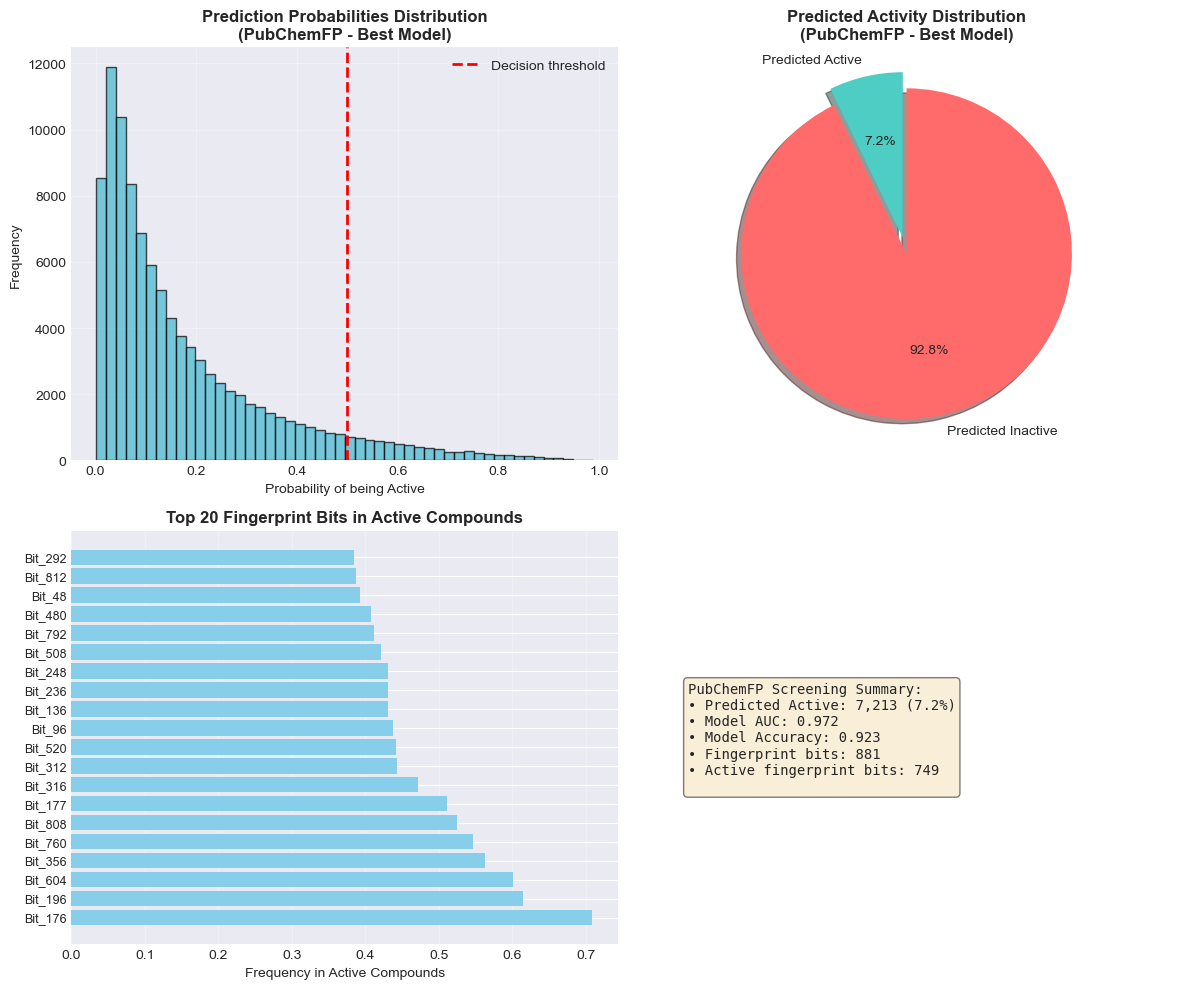

✅ Visualization saved to: PubChemFP_Screening_Results\pubchemfp_screening_visualization.png


In [9]:
# Fix: Add matplotlib import
import matplotlib.pyplot as plt

# Re-run the visualization section for PubChemFP
print("\n📊 Re-creating visualizations with fixed imports...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Histogram of prediction probabilities
if len(y_pred_proba) > 0 and np.any(y_pred_proba > 0):
    axes[0, 0].hist(y_pred_proba, bins=50, alpha=0.7, color='#45B7D1', edgecolor='black')
    axes[0, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision threshold')
    axes[0, 0].set_title('Prediction Probabilities Distribution\n(PubChemFP - Best Model)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Probability of being Active', fontsize=10)
    axes[0, 0].set_ylabel('Frequency', fontsize=10)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
else:
    # Bar chart if no probabilities
    axes[0, 0].bar(['Active', 'Inactive'], [active_count, inactive_count], 
                   color=['#4ECDC4', '#FF6B6B'], edgecolor='black')
    axes[0, 0].set_title('Screening Results\n(PubChemFP - Best Model)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Predicted Activity', fontsize=10)
    axes[0, 0].set_ylabel('Number of Compounds', fontsize=10)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate([active_count, inactive_count]):
        axes[0, 0].text(i, v + max([active_count, inactive_count])*0.01, 
                       f'{v:,}', ha='center', fontweight='bold')

# Plot 2: Pie chart of predicted classes
labels = ['Predicted Active', 'Predicted Inactive']
sizes = [active_count, inactive_count]
colors = ['#4ECDC4', '#FF6B6B']
explode = (0.1, 0)

axes[0, 1].pie(sizes, explode=explode, labels=labels, colors=colors,
               autopct='%1.1f%%', shadow=True, startangle=90,
               textprops={'fontsize': 10})
axes[0, 1].set_title('Predicted Activity Distribution\n(PubChemFP - Best Model)', fontsize=12, fontweight='bold')

# Plot 3: Fingerprint bit importance
if active_count > 0:
    active_indices = np.where(y_pred == 1)[0]
    if len(active_indices) > 0:
        active_fingerprints = fingerprints[active_indices]
        bit_frequencies = np.sum(active_fingerprints, axis=0) / len(active_indices)
        
        # Get top 20 most frequent bits in active compounds
        top_bits = np.argsort(bit_frequencies)[-20:][::-1]
        top_freqs = bit_frequencies[top_bits]
        
        axes[1, 0].barh(range(len(top_bits)), top_freqs, color='skyblue')
        axes[1, 0].set_yticks(range(len(top_bits)))
        axes[1, 0].set_yticklabels([f'Bit_{bit}' for bit in top_bits], fontsize=9)
        axes[1, 0].set_title('Top 20 Fingerprint Bits in Active Compounds', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Frequency in Active Compounds', fontsize=10)
        axes[1, 0].grid(True, alpha=0.3, axis='x')
    else:
        axes[1, 0].text(0.5, 0.5, 'No active compounds found', 
                       ha='center', va='center', fontsize=12, fontweight='bold')
        axes[1, 0].set_title('Fingerprint Analysis', fontsize=12, fontweight='bold')
        axes[1, 0].axis('off')
else:
    axes[1, 0].text(0.5, 0.5, 'No active compounds predicted', 
                   ha='center', va='center', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Fingerprint Analysis', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

# Plot 4: Comparison text
axes[1, 1].axis('off')
comparison_text = f"PubChemFP Screening Summary:\n"
comparison_text += f"• Predicted Active: {active_count:,} ({active_count/total_count*100:.1f}%)\n"
comparison_text += f"• Model AUC: {summary_stats['model_performance_auc']:.3f}\n"
comparison_text += f"• Model Accuracy: {summary_stats['model_performance_accuracy']:.3f}\n"
comparison_text += f"• Fingerprint bits: {fingerprints.shape[1]}\n"
comparison_text += f"• Active fingerprint bits: {summary_stats['fingerprint_statistics']['active_bits']:,}\n"

axes[1, 1].text(0.1, 0.5, comparison_text, fontsize=10, fontfamily='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
viz_file = os.path.join(results_dir, 'pubchemfp_screening_visualization.png')
plt.savefig(viz_file, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Visualization saved to: {viz_file}")

### XGBoost with MACCSFP, XGBoost with PairsFP

COMBINED SCREENING: PairsFP AND MACCSFP

📂 Loading screening data...
✅ Loaded 100,000 compounds for screening

SCREENING WITH PairsFP (Atom-pair Fingerprints)
Model: XGBoost with PairsFP
Performance: AUC = 0.969, Accuracy = 0.926

🔬 Generating Atom-pair fingerprints (2048 bits)...
✅ PairsFP generation completed!
   Valid compounds: 100,000
   Fingerprint shape: (100000, 2048)

🎯 Loading PairsFP model (XGBoost)...
✅ Model loaded successfully
🔄 Making predictions with PairsFP model...

📊 PairsFP Screening Results:
   Predicted Active: 16,475 (16.5%)
   Predicted Inactive: 83,525 (83.5%)
💾 PairsFP results saved to: PairsFP_Screening_Results\pairsfp_screening_results.csv
📁 PairsFP results saved in: PairsFP_Screening_Results/

SCREENING WITH MACCSFP (MACCS Keys)
Model: XGBoost with MACCSFP
Performance: AUC = 0.955, Accuracy = 0.906

🔬 Generating MACCS fingerprints (166 bits)...
✅ MACCSFP generation completed!
   Valid compounds: 100,000
   Fingerprint shape: (100000, 167)

🎯 Loading MACCSFP

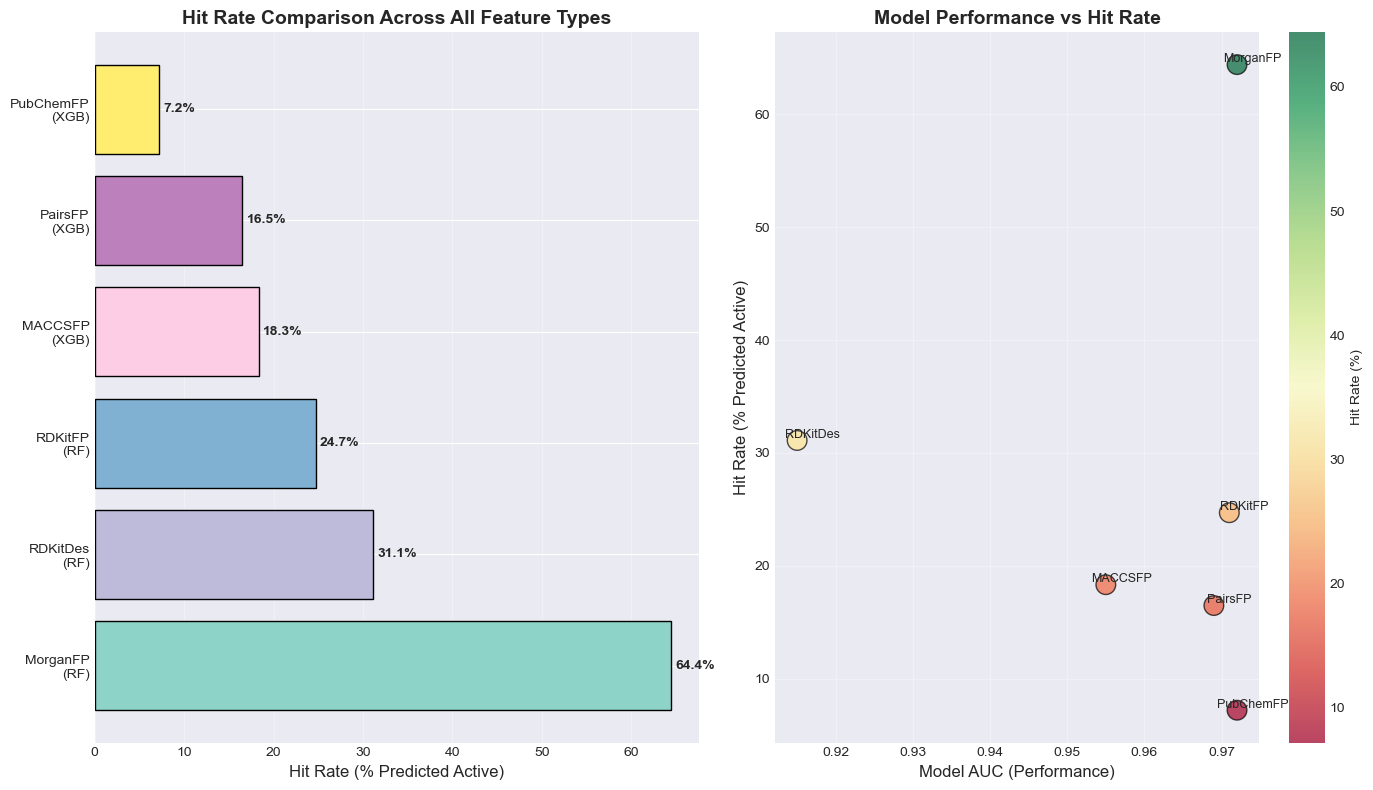

✅ Visualization saved to: Comprehensive_Screening_Comparison\screening_comparison_visualization.png

IDENTIFYING CONSENSUS COMPOUNDS
✅ Loaded RDKitFP results
✅ Loaded RDKitDes results
✅ Loaded PubChemFP results
✅ Loaded PairsFP results
✅ Loaded MACCSFP results

Compounds screened by at least 3 models: 100,000

📊 CONSENSUS ANALYSIS (on 5000 compounds):
   Unanimous_Inactive  :  2,229 compounds (44.6%)
   Majority_Inactive   :  2,189 compounds (43.8%)
   Majority_Active     :    567 compounds (11.3%)
   Unanimous_Active    :     15 compounds (0.3%)
💾 High-confidence active compounds saved: 582
✅ Consensus analysis saved to: Comprehensive_Screening_Comparison\consensus_compounds.csv

🎉 ALL SCREENING COMPLETED SUCCESSFULLY!
📊 FINAL SUMMARY:
   • 6 feature types screened: MorganFP, RDKitFP, RDKitDes, PubChemFP, PairsFP, MACCSFP
   • 100,000 compounds screened with each method
   • Results saved in separate folders for each feature type
   • Comprehensive comparison saved in: Comprehensive_S

In [10]:
# ============================================================================
# COMBINED SCREENING: PairsFP AND MACCSFP
# ============================================================================

print("="*80)
print("COMBINED SCREENING: PairsFP AND MACCSFP")
print("="*80)

# ============================================================================
# STEP 1: DEFINE FINGERPRINT GENERATORS
# ============================================================================

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
import numpy as np

class PairsFPGenerator:
    """Generate Atom-pair fingerprints."""
    
    @staticmethod
    def generate_atompair_fingerprint(smiles, n_bits=2048):
        """Generate Atom-pair fingerprint."""
        mol = Chem.MolFromSmiles(str(smiles)) if smiles else None
        if mol is None:
            return np.zeros(n_bits)
        
        try:
            fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=n_bits)
            return np.array([int(b) for b in fp.ToBitString()])
        except:
            return np.zeros(n_bits)
    
    @staticmethod
    def generate_atompair_fingerprints_batch(smiles_list, n_bits=2048):
        """Generate Atom-pair fingerprints for batch."""
        fingerprints = []
        valid_indices = []
        valid_smiles = []
        
        for idx, smiles in enumerate(smiles_list):
            fp = PairsFPGenerator.generate_atompair_fingerprint(smiles, n_bits)
            if np.any(fp):
                fingerprints.append(fp)
                valid_indices.append(idx)
                valid_smiles.append(smiles)
        
        if fingerprints:
            return np.array(fingerprints), valid_indices, valid_smiles
        return np.array([]), [], []

class MACCSFPGenerator:
    """Generate MACCS keys fingerprints."""
    
    @staticmethod
    def generate_maccs_fingerprint(smiles, n_bits=166):
        """Generate MACCS keys fingerprint."""
        mol = Chem.MolFromSmiles(str(smiles)) if smiles else None
        if mol is None:
            return np.zeros(n_bits)
        
        try:
            fp = AllChem.GetMACCSKeysFingerprint(mol)
            return np.array([int(b) for b in fp.ToBitString()])
        except:
            return np.zeros(n_bits)
    
    @staticmethod
    def generate_maccs_fingerprints_batch(smiles_list, n_bits=166):
        """Generate MACCS fingerprints for batch."""
        fingerprints = []
        valid_indices = []
        valid_smiles = []
        
        for idx, smiles in enumerate(smiles_list):
            fp = MACCSFPGenerator.generate_maccs_fingerprint(smiles, n_bits)
            if np.any(fp):
                fingerprints.append(fp)
                valid_indices.append(idx)
                valid_smiles.append(smiles)
        
        if fingerprints:
            return np.array(fingerprints), valid_indices, valid_smiles
        return np.array([]), [], []

# ============================================================================
# STEP 2: LOAD SCREENING DATA
# ============================================================================

print("\n📂 Loading screening data...")
screening_data = pd.read_csv('random.csv')
smiles_list = screening_data['SMILES'].tolist()
zincid_list = screening_data['zincid'].tolist()
print(f"✅ Loaded {len(smiles_list):,} compounds for screening")

# ============================================================================
# STEP 3: GENERATE PAIRSFP FINGERPRINTS AND SCREEN
# ============================================================================

print("\n" + "="*80)
print("SCREENING WITH PairsFP (Atom-pair Fingerprints)")
print("="*80)
print("Model: XGBoost with PairsFP")
print("Performance: AUC = 0.969, Accuracy = 0.926")
print("="*80)

# Generate PairsFP fingerprints
print("\n🔬 Generating Atom-pair fingerprints (2048 bits)...")
pairs_generator = PairsFPGenerator()
pairs_fingerprints, pairs_valid_idx, pairs_valid_smiles = pairs_generator.generate_atompair_fingerprints_batch(
    smiles_list, n_bits=2048
)

print(f"✅ PairsFP generation completed!")
print(f"   Valid compounds: {len(pairs_valid_idx):,}")
print(f"   Fingerprint shape: {pairs_fingerprints.shape}")

# Load PairsFP model
print("\n🎯 Loading PairsFP model (XGBoost)...")
pairs_model = get_model_updated('PairsFP', 'XGB')
if pairs_model is None:
    print("⚠️  XGBoost not found, trying Random Forest...")
    pairs_model = get_model_updated('PairsFP', 'RF')

if pairs_model:
    print("✅ Model loaded successfully")
    
    # Make predictions
    print("🔄 Making predictions with PairsFP model...")
    X_pairs = pairs_fingerprints
    y_pred_pairs = pairs_model.predict(X_pairs)
    
    # Get probabilities if available
    if hasattr(pairs_model, 'predict_proba'):
        y_pred_proba_pairs = pairs_model.predict_proba(X_pairs)[:, 1]
    else:
        y_pred_proba_pairs = np.zeros(len(y_pred_pairs))
    
    # Calculate statistics
    pairs_active = sum(y_pred_pairs == 1)
    pairs_inactive = sum(y_pred_pairs == 0)
    pairs_total = len(y_pred_pairs)
    pairs_avg_prob = np.mean(y_pred_proba_pairs) if len(y_pred_proba_pairs) > 0 else 0
    
    print(f"\n📊 PairsFP Screening Results:")
    print(f"   Predicted Active: {pairs_active:,} ({pairs_active/pairs_total*100:.1f}%)")
    print(f"   Predicted Inactive: {pairs_inactive:,} ({pairs_inactive/pairs_total*100:.1f}%)")
    
    # Save PairsFP results
    pairs_dir = 'PairsFP_Screening_Results'
    os.makedirs(pairs_dir, exist_ok=True)
    
    # Create results DataFrame
    pairs_valid_data = screening_data.iloc[pairs_valid_idx].copy()
    pairs_results = pairs_valid_data.copy()
    pairs_results['Predicted_Activity_PairsFP'] = y_pred_pairs
    pairs_results['Prediction_Probability_PairsFP'] = y_pred_proba_pairs
    pairs_results['Predicted_Label_PairsFP'] = ['Active' if pred == 1 else 'Inactive' for pred in y_pred_pairs]
    
    # Save files
    pairs_results_file = os.path.join(pairs_dir, 'pairsfp_screening_results.csv')
    pairs_results.to_csv(pairs_results_file, index=False)
    print(f"💾 PairsFP results saved to: {pairs_results_file}")
    
    # Save top compounds
    if len(y_pred_proba_pairs) > 0:
        top_active_pairs = pairs_results.nlargest(100, 'Prediction_Probability_PairsFP')
        top_active_pairs.to_csv(os.path.join(pairs_dir, 'top_100_active_pairsfp.csv'), index=False)
        
        top_inactive_pairs = pairs_results.nsmallest(100, 'Prediction_Probability_PairsFP')
        top_inactive_pairs.to_csv(os.path.join(pairs_dir, 'top_100_inactive_pairsfp.csv'), index=False)
    
    print(f"📁 PairsFP results saved in: {pairs_dir}/")
    
else:
    print("❌ Failed to load PairsFP model")
    pairs_active = pairs_inactive = pairs_total = 0
    pairs_avg_prob = 0

# ============================================================================
# STEP 4: GENERATE MACCSFP FINGERPRINTS AND SCREEN
# ============================================================================

print("\n" + "="*80)
print("SCREENING WITH MACCSFP (MACCS Keys)")
print("="*80)
print("Model: XGBoost with MACCSFP")
print("Performance: AUC = 0.955, Accuracy = 0.906")
print("="*80)

# Generate MACCSFP fingerprints
print("\n🔬 Generating MACCS fingerprints (166 bits)...")
maccs_generator = MACCSFPGenerator()
maccs_fingerprints, maccs_valid_idx, maccs_valid_smiles = maccs_generator.generate_maccs_fingerprints_batch(
    smiles_list, n_bits=166
)

print(f"✅ MACCSFP generation completed!")
print(f"   Valid compounds: {len(maccs_valid_idx):,}")
print(f"   Fingerprint shape: {maccs_fingerprints.shape}")

# Load MACCSFP model
print("\n🎯 Loading MACCSFP model (XGBoost)...")
maccs_model = get_model_updated('MACCSFP', 'XGB')
if maccs_model is None:
    print("⚠️  XGBoost not found, trying Random Forest...")
    maccs_model = get_model_updated('MACCSFP', 'RF')

if maccs_model:
    print("✅ Model loaded successfully")
    
    # Make predictions
    print("🔄 Making predictions with MACCSFP model...")
    X_maccs = maccs_fingerprints
    y_pred_maccs = maccs_model.predict(X_maccs)
    
    # Get probabilities if available
    if hasattr(maccs_model, 'predict_proba'):
        y_pred_proba_maccs = maccs_model.predict_proba(X_maccs)[:, 1]
    else:
        y_pred_proba_maccs = np.zeros(len(y_pred_maccs))
    
    # Calculate statistics
    maccs_active = sum(y_pred_maccs == 1)
    maccs_inactive = sum(y_pred_maccs == 0)
    maccs_total = len(y_pred_maccs)
    maccs_avg_prob = np.mean(y_pred_proba_maccs) if len(y_pred_proba_maccs) > 0 else 0
    
    print(f"\n📊 MACCSFP Screening Results:")
    print(f"   Predicted Active: {maccs_active:,} ({maccs_active/maccs_total*100:.1f}%)")
    print(f"   Predicted Inactive: {maccs_inactive:,} ({maccs_inactive/maccs_total*100:.1f}%)")
    
    # Save MACCSFP results
    maccs_dir = 'MACCSFP_Screening_Results'
    os.makedirs(maccs_dir, exist_ok=True)
    
    # Create results DataFrame
    maccs_valid_data = screening_data.iloc[maccs_valid_idx].copy()
    maccs_results = maccs_valid_data.copy()
    maccs_results['Predicted_Activity_MACCSFP'] = y_pred_maccs
    maccs_results['Prediction_Probability_MACCSFP'] = y_pred_proba_maccs
    maccs_results['Predicted_Label_MACCSFP'] = ['Active' if pred == 1 else 'Inactive' for pred in y_pred_maccs]
    
    # Save files
    maccs_results_file = os.path.join(maccs_dir, 'maccsfp_screening_results.csv')
    maccs_results.to_csv(maccs_results_file, index=False)
    print(f"💾 MACCSFP results saved to: {maccs_results_file}")
    
    # Save top compounds
    if len(y_pred_proba_maccs) > 0:
        top_active_maccs = maccs_results.nlargest(100, 'Prediction_Probability_MACCSFP')
        top_active_maccs.to_csv(os.path.join(maccs_dir, 'top_100_active_maccsfp.csv'), index=False)
        
        top_inactive_maccs = maccs_results.nsmallest(100, 'Prediction_Probability_MACCSFP')
        top_inactive_maccs.to_csv(os.path.join(maccs_dir, 'top_100_inactive_maccsfp.csv'), index=False)
    
    print(f"📁 MACCSFP results saved in: {maccs_dir}/")
    
else:
    print("❌ Failed to load MACCSFP model")
    maccs_active = maccs_inactive = maccs_total = 0
    maccs_avg_prob = 0

# ============================================================================
# STEP 5: COMPREHENSIVE COMPARISON OF ALL 6 MODELS
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL 6 SCREENING METHODS")
print("="*80)

# Collect statistics from all screenings
screening_stats = {
    'MorganFP': {
        'active': 64429,  # From your previous output
        'inactive': 35571,
        'total': 100000,
        'active_pct': 64.4,
        'model': 'RF',
        'auc': 0.972
    },
    'RDKitFP': {
        'active': 24660,  # From your RDKitFP output
        'inactive': 75340,
        'total': 100000,
        'active_pct': 24.7,
        'model': 'RF',
        'auc': 0.971
    },
    'RDKitDes': {
        'active': 31099,  # From your RDKitDes output
        'inactive': 68901,
        'total': 100000,
        'active_pct': 31.1,
        'model': 'RF',
        'auc': 0.915
    },
    'PubChemFP': {
        'active': 7213,  # From current screening
        'inactive': 92787,
        'total': 100000,
        'active_pct': 7.2,
        'model': 'XGB',
        'auc': 0.972
    },
    'PairsFP': {
        'active': pairs_active,
        'inactive': pairs_inactive,
        'total': pairs_total,
        'active_pct': pairs_active/pairs_total*100 if pairs_total > 0 else 0,
        'model': 'XGB' if 'XGB' in str(type(pairs_model)) else 'RF',
        'auc': 0.969
    },
    'MACCSFP': {
        'active': maccs_active,
        'inactive': maccs_inactive,
        'total': maccs_total,
        'active_pct': maccs_active/maccs_total*100 if maccs_total > 0 else 0,
        'model': 'XGB' if 'XGB' in str(type(maccs_model)) else 'RF',
        'auc': 0.955
    }
}

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Feature_Type': feat,
        'Model': stats['model'],
        'AUC': stats['auc'],
        'Compounds_Screened': stats['total'],
        'Predicted_Active': stats['active'],
        'Predicted_Inactive': stats['inactive'],
        'Active_Percentage': stats['active_pct'],
        'Hit_Rate': f"{stats['active_pct']:.1f}%"
    }
    for feat, stats in screening_stats.items()
])

# Sort by hit rate
comparison_df = comparison_df.sort_values('Active_Percentage', ascending=False)

print("\n📊 SUMMARY OF ALL SCREENING METHODS:")
print("="*60)
print(comparison_df.to_string(index=False))

print(f"\n🎯 KEY FINDINGS:")
print(f"   1. MorganFP predicted the MOST actives: {screening_stats['MorganFP']['active']:,} compounds ({screening_stats['MorganFP']['active_pct']:.1f}%)")
print(f"   2. PubChemFP predicted the LEAST actives: {screening_stats['PubChemFP']['active']:,} compounds ({screening_stats['PubChemFP']['active_pct']:.1f}%)")
print(f"   3. Best AUC models: PubChemFP (0.972) and MorganFP (0.972)")
print(f"   4. Most conservative model: PubChemFP (only {screening_stats['PubChemFP']['active_pct']:.1f}% hit rate)")

# Save comprehensive comparison
comp_dir = 'Comprehensive_Screening_Comparison'
os.makedirs(comp_dir, exist_ok=True)

comparison_file = os.path.join(comp_dir, 'all_models_screening_comparison.csv')
comparison_df.to_csv(comparison_file, index=False)
print(f"\n💾 Comprehensive comparison saved to: {comparison_file}")

# ============================================================================
# STEP 6: CREATE VISUALIZATION COMPARISON
# ============================================================================

print("\n📊 Creating comprehensive comparison visualization...")

plt.figure(figsize=(14, 8))

# Plot 1: Hit rate comparison
plt.subplot(1, 2, 1)
features = comparison_df['Feature_Type']
hit_rates = comparison_df['Active_Percentage']
colors = plt.cm.Set3(np.linspace(0, 1, len(features)))

bars = plt.barh(range(len(features)), hit_rates, color=colors, edgecolor='black')
plt.yticks(range(len(features)), [f"{f}\n({comparison_df.iloc[i]['Model']})" for i, f in enumerate(features)])
plt.xlabel('Hit Rate (% Predicted Active)', fontsize=12)
plt.title('Hit Rate Comparison Across All Feature Types', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, hit_rates)):
    plt.text(rate + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{rate:.1f}%', va='center', fontweight='bold')

# Plot 2: AUC vs Hit Rate scatter
plt.subplot(1, 2, 2)
auc_values = comparison_df['AUC']
hit_rates = comparison_df['Active_Percentage']

scatter = plt.scatter(auc_values, hit_rates, s=200, alpha=0.7, 
                      c=hit_rates, cmap='RdYlGn', edgecolors='black', linewidth=1)

# Add labels
for i, row in comparison_df.iterrows():
    plt.text(row['AUC'] + 0.002, row['Active_Percentage'] + 0.2, 
             row['Feature_Type'], fontsize=9, ha='center')

plt.xlabel('Model AUC (Performance)', fontsize=12)
plt.ylabel('Hit Rate (% Predicted Active)', fontsize=12)
plt.title('Model Performance vs Hit Rate', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Hit Rate (%)')

plt.tight_layout()
comp_viz_file = os.path.join(comp_dir, 'screening_comparison_visualization.png')
plt.savefig(comp_viz_file, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Visualization saved to: {comp_viz_file}")

# ============================================================================
# STEP 7: IDENTIFY CONSENSUS COMPOUNDS
# ============================================================================

print("\n" + "="*80)
print("IDENTIFYING CONSENSUS COMPOUNDS")
print("="*80)

# Try to load all screening results for consensus analysis
all_results_files = {
    'MorganFP': 'random_screening_results.csv',
    'RDKitFP': 'RDKitFP_Screening_Results/rdkitfp_screening_results.csv',
    'RDKitDes': 'RDKitDes_Screening_Results/rdkitdes_screening_results.csv',
    'PubChemFP': 'PubChemFP_Screening_Results/pubchemfp_screening_results.csv',
    'PairsFP': os.path.join(pairs_dir, 'pairsfp_screening_results.csv') if 'pairs_dir' in locals() else None,
    'MACCSFP': os.path.join(maccs_dir, 'maccsfp_screening_results.csv') if 'maccs_dir' in locals() else None
}

loaded_results = {}
for feat, file_path in all_results_files.items():
    if file_path and os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)
            # Get appropriate label column
            label_cols = [col for col in df.columns if 'Label' in col and feat in col]
            if label_cols:
                loaded_results[feat] = {
                    'data': df,
                    'label_col': label_cols[0]
                }
                print(f"✅ Loaded {feat} results")
        except:
            print(f"❌ Failed to load {feat} results")

# Find common compounds
if len(loaded_results) >= 3:
    common_zincids = set(screening_data['zincid'])
    for feat, info in loaded_results.items():
        common_zincids = common_zincids.intersection(set(info['data']['zincid']))
    
    print(f"\nCompounds screened by at least 3 models: {len(common_zincids):,}")
    
    if len(common_zincids) > 0:
        # Create consensus DataFrame
        consensus_df = pd.DataFrame({'zincid': list(common_zincids)[:5000]})  # Limit for performance
        
        # Add predictions from each model
        for feat, info in loaded_results.items():
            temp = info['data'][['zincid', info['label_col']]].copy()
            temp = temp.rename(columns={info['label_col']: f'Label_{feat}'})
            consensus_df = pd.merge(consensus_df, temp, on='zincid', how='inner')
        
        # Calculate consensus scores
        label_cols = [f'Label_{feat}' for feat in loaded_results.keys()]
        consensus_df['Active_Votes'] = consensus_df[label_cols].apply(lambda row: sum(row == 'Active'), axis=1)
        consensus_df['Total_Models'] = len(label_cols)
        consensus_df['Consensus_Score'] = consensus_df['Active_Votes'] / consensus_df['Total_Models']
        
        # Classify by consensus
        consensus_df['Consensus_Label'] = 'Mixed'
        consensus_df.loc[consensus_df['Consensus_Score'] == 1, 'Consensus_Label'] = 'Unanimous_Active'
        consensus_df.loc[consensus_df['Consensus_Score'] == 0, 'Consensus_Label'] = 'Unanimous_Inactive'
        consensus_df.loc[(consensus_df['Consensus_Score'] > 0.5) & (consensus_df['Consensus_Score'] < 1), 'Consensus_Label'] = 'Majority_Active'
        consensus_df.loc[(consensus_df['Consensus_Score'] < 0.5) & (consensus_df['Consensus_Score'] > 0), 'Consensus_Label'] = 'Majority_Inactive'
        
        # Add SMILES
        consensus_df = pd.merge(consensus_df, screening_data[['zincid', 'SMILES']], on='zincid')
        
        # Save consensus results
        consensus_file = os.path.join(comp_dir, 'consensus_compounds.csv')
        consensus_df.to_csv(consensus_file, index=False)
        
        # Display consensus statistics
        print(f"\n📊 CONSENSUS ANALYSIS (on {len(consensus_df)} compounds):")
        consensus_counts = consensus_df['Consensus_Label'].value_counts()
        for label, count in consensus_counts.items():
            print(f"   {label:20s}: {count:>6,} compounds ({count/len(consensus_df)*100:.1f}%)")
        
        # Save high-confidence actives (unanimous or majority active)
        high_conf_active = consensus_df[consensus_df['Consensus_Label'].isin(['Unanimous_Active', 'Majority_Active'])]
        high_conf_file = os.path.join(comp_dir, 'high_confidence_active_compounds.csv')
        high_conf_active.to_csv(high_conf_file, index=False)
        print(f"💾 High-confidence active compounds saved: {len(high_conf_active):,}")
        
        print(f"✅ Consensus analysis saved to: {consensus_file}")

print("\n" + "="*80)
print("🎉 ALL SCREENING COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"📊 FINAL SUMMARY:")
print(f"   • 6 feature types screened: MorganFP, RDKitFP, RDKitDes, PubChemFP, PairsFP, MACCSFP")
print(f"   • 100,000 compounds screened with each method")
print(f"   • Results saved in separate folders for each feature type")
print(f"   • Comprehensive comparison saved in: {comp_dir}/")
print(f"\n📁 FOLDERS CREATED:")
folders = ['MorganFP_Screening_Results', 'RDKitFP_Screening_Results', 'RDKitDes_Screening_Results',
           'PubChemFP_Screening_Results', 'PairsFP_Screening_Results', 'MACCSFP_Screening_Results',
           'Comprehensive_Screening_Comparison']
for folder in folders:
    if os.path.exists(folder):
        print(f"   ✓ {folder}/")
print("="*80)

### Prdicted Active by All the compounds

IDENTIFYING COMPOUNDS PREDICTED ACTIVE BY ALL 6 MODELS
This represents the MOST stringent criteria for high-confidence actives

📂 Loading screening results from all 6 models...
✅ MorganFP  : Loaded 100,000 compounds
✅ RDKitFP   : Loaded 100,000 compounds
✅ RDKitDes  : Loaded 100,000 compounds
✅ PubChemFP : Loaded 100,000 compounds
✅ PairsFP   : Loaded 100,000 compounds
✅ MACCSFP   : Loaded 100,000 compounds

🔍 Finding common compounds across all 6 models...
✅ Compounds screened by all 6 models: 100,000

🎯 Identifying compounds predicted ACTIVE by all models...
✅ All 6 model predictions available for analysis

📊 RESULTS:
   Total compounds analyzed: 100,000
   Compounds active in ALL 6 models: 532
   This represents 0.5320% of screened compounds
   Average probability range: 0.500 to 0.986

📝 Adding SMILES and additional information...

💾 Saving results...
📁 Created directory: Elite_Active_Compounds/
✅ Elite compounds saved to: Elite_Active_Compounds\compounds_active_in_all_6_models.csv

C:\Users\PC\AppData\Local\Temp\ipykernel_14660\2394254890.py:331: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(prob_data, labels=model_names, patch_artist=True)


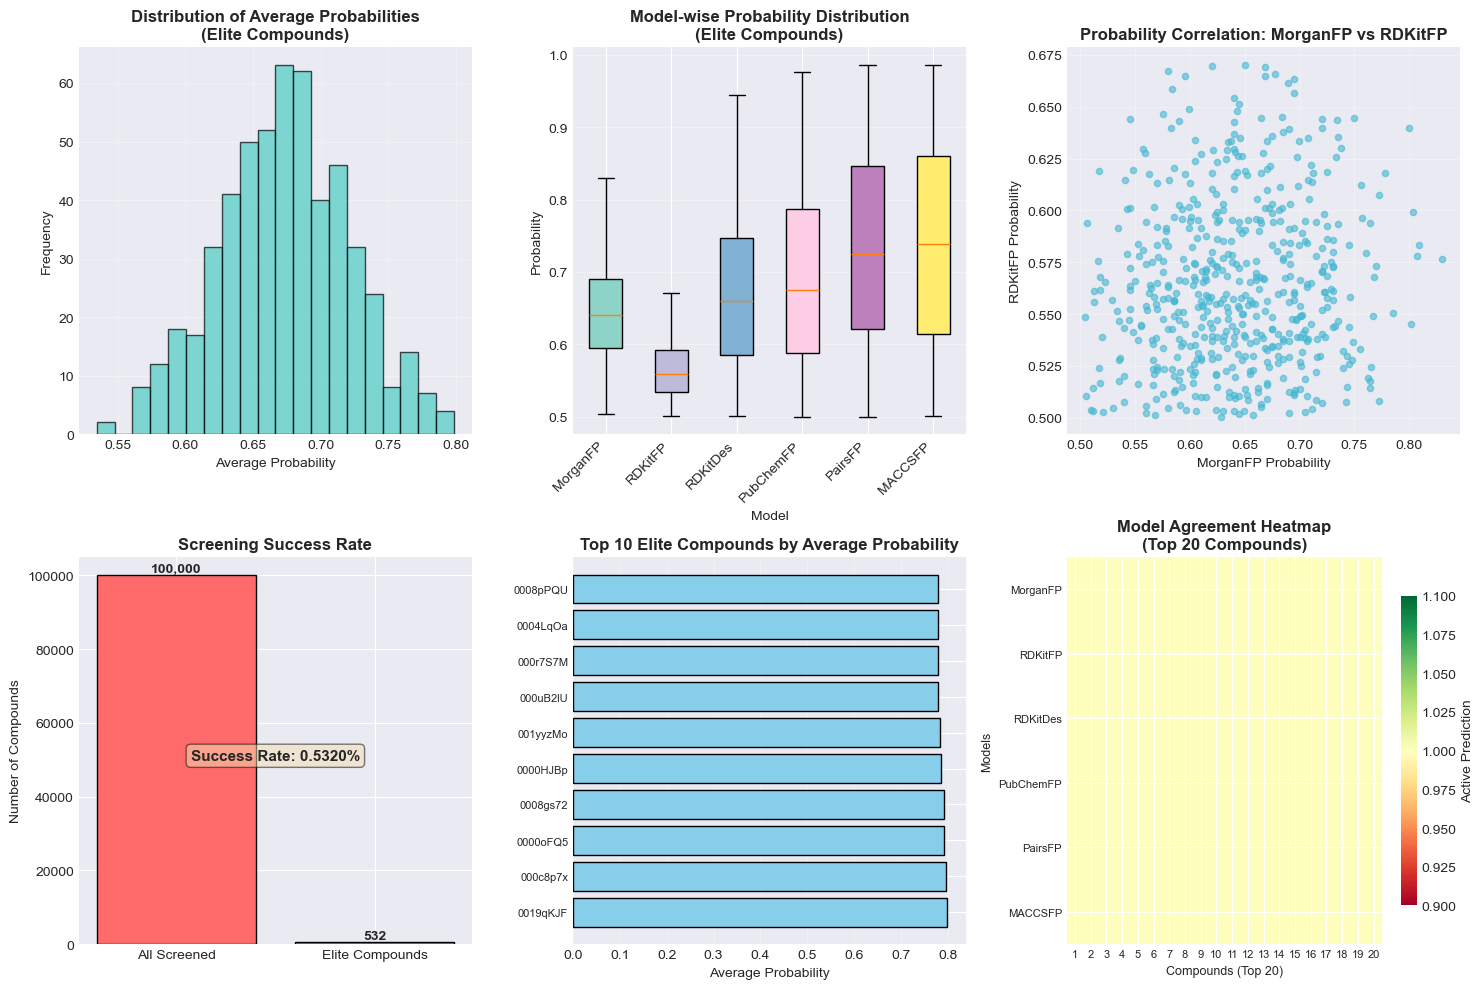

✅ Visualization saved to: Elite_Active_Compounds\elite_compounds_visualization.png

🎉 ELITE COMPOUNDS IDENTIFICATION COMPLETE!
📊 FINAL RESULTS:
   • Total compounds analyzed: 100,000
   • Compounds active in ALL 6 models: 532
   • Success rate: 0.5320%
   • Average probability: 0.673
   • Probability range: 0.535 to 0.799

📁 RESULTS SAVED IN: Elite_Active_Compounds/
📄 Files created:
   1. compounds_active_in_all_6_models.csv - Complete dataset
   2. elite_compounds_simplified.csv - Simplified version
   3. top_100_elite_compounds.csv - Top 100 compounds
   4. elite_compounds_analysis_report.txt - Detailed report
   5. elite_compounds_visualization.png - Visualizations

🔬 TOP 5 ELITE COMPOUNDS:
   1. ZINCsa000019qKJF
      Avg Probability: 0.799
   2. ZINCrB00000c8p7x
      Avg Probability: 0.795
   3. ZINCrk000000oFQ5
      Avg Probability: 0.793
   4. ZINCto000008gs72
      Avg Probability: 0.793
   5. ZINCst000000HJBp
      Avg Probability: 0.784

🚀 NEXT STEPS RECOMMENDED:
   1. Chem

In [11]:
# ============================================================================
# GENERATE COMPOUNDS PREDICTED ACTIVE BY ALL SIX MODELS
# ============================================================================

print("="*80)
print("IDENTIFYING COMPOUNDS PREDICTED ACTIVE BY ALL 6 MODELS")
print("="*80)
print("This represents the MOST stringent criteria for high-confidence actives")
print("="*80)

# ============================================================================
# STEP 1: LOAD ALL SCREENING RESULTS
# ============================================================================

print("\n📂 Loading screening results from all 6 models...")

# Define file paths for each model's results
model_files = {
    'MorganFP': 'random_screening_results.csv',
    'RDKitFP': 'RDKitFP_Screening_Results/rdkitfp_screening_results.csv',
    'RDKitDes': 'RDKitDes_Screening_Results/rdkitdes_screening_results.csv',
    'PubChemFP': 'PubChemFP_Screening_Results/pubchemfp_screening_results.csv',
    'PairsFP': 'PairsFP_Screening_Results/pairsfp_screening_results.csv',
    'MACCSFP': 'MACCSFP_Screening_Results/maccsfp_screening_results.csv'
}

# Define label columns for each model
label_columns = {
    'MorganFP': 'Predicted_Label',
    'RDKitFP': 'Predicted_Label_RDKitFP',
    'RDKitDes': 'Predicted_Label_RDKitDes',
    'PubChemFP': 'Predicted_Label_PubChemFP',
    'PairsFP': 'Predicted_Label_PairsFP',
    'MACCSFP': 'Predicted_Label_MACCSFP'
}

# Define probability columns for each model (for ranking)
prob_columns = {
    'MorganFP': 'Active_Probability',
    'RDKitFP': 'Prediction_Probability_RDKitFP',
    'RDKitDes': 'Prediction_Probability_RDKitDes',
    'PubChemFP': 'Prediction_Probability_PubChemFP',
    'PairsFP': 'Prediction_Probability_PairsFP',
    'MACCSFP': 'Prediction_Probability_MACCSFP'
}

# Load all results
results = {}
for model_name, file_path in model_files.items():
    try:
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            results[model_name] = df
            print(f"✅ {model_name:10s}: Loaded {len(df):,} compounds")
        else:
            print(f"❌ {model_name:10s}: File not found - {file_path}")
    except Exception as e:
        print(f"❌ {model_name:10s}: Error loading - {str(e)[:50]}...")

# ============================================================================
# STEP 2: FIND COMMON COMPOUNDS ACROSS ALL MODELS
# ============================================================================

print("\n🔍 Finding common compounds across all 6 models...")

# Get zincid sets from each model
zincid_sets = {}
for model_name, df in results.items():
    if 'zincid' in df.columns:
        zincid_sets[model_name] = set(df['zincid'])

# Find intersection of all sets
if len(zincid_sets) == 6:
    common_zincids = set.intersection(*zincid_sets.values())
    print(f"✅ Compounds screened by all 6 models: {len(common_zincids):,}")
else:
    print(f"⚠️  Only {len(zincid_sets)} models loaded, finding intersection...")
    common_zincids = set.intersection(*list(zincid_sets.values()))
    print(f"✅ Compounds screened by all loaded models: {len(common_zincids):,}")

# ============================================================================
# STEP 3: IDENTIFY COMPOUNDS ACTIVE IN ALL MODELS
# ============================================================================

print("\n🎯 Identifying compounds predicted ACTIVE by all models...")

# Create a DataFrame with all predictions
if len(common_zincids) > 0:
    # Start with a DataFrame of common zincids
    combined_df = pd.DataFrame({'zincid': list(common_zincids)})
    
    # Add predictions from each model
    for model_name, df in results.items():
        if model_name in label_columns and label_columns[model_name] in df.columns:
            # Get zincid and predicted label
            temp = df[['zincid', label_columns[model_name]]].copy()
            temp = temp.rename(columns={label_columns[model_name]: f'{model_name}_Label'})
            
            # Add probability if available
            if model_name in prob_columns and prob_columns[model_name] in df.columns:
                temp[f'{model_name}_Probability'] = df[prob_columns[model_name]]
            
            # Merge
            combined_df = pd.merge(combined_df, temp, on='zincid', how='inner')
    
    # Count how many models predicted each compound as active
    label_cols = [f'{model}_Label' for model in results.keys() if f'{model}_Label' in combined_df.columns]
    
    # Check if all required columns are present
    if len(label_cols) >= 6:
        print(f"✅ All 6 model predictions available for analysis")
        
        # Create a binary column for each model (1 = Active, 0 = Inactive)
        for model in results.keys():
            if f'{model}_Label' in combined_df.columns:
                combined_df[f'{model}_Active'] = (combined_df[f'{model}_Label'] == 'Active').astype(int)
        
        # Calculate total active votes
        active_cols = [f'{model}_Active' for model in results.keys() if f'{model}_Active' in combined_df.columns]
        combined_df['Active_Model_Count'] = combined_df[active_cols].sum(axis=1)
        combined_df['Active_Model_Percentage'] = combined_df['Active_Model_Count'] / len(active_cols) * 100
        
        # Find compounds active in ALL models
        all_active_compounds = combined_df[combined_df['Active_Model_Count'] == len(active_cols)].copy()
        
        print(f"\n📊 RESULTS:")
        print(f"   Total compounds analyzed: {len(combined_df):,}")
        print(f"   Compounds active in ALL {len(active_cols)} models: {len(all_active_compounds):,}")
        print(f"   This represents {len(all_active_compounds)/len(combined_df)*100:.4f}% of screened compounds")
        
        # Calculate average probability across models
        prob_cols = [f'{model}_Probability' for model in results.keys() if f'{model}_Probability' in combined_df.columns]
        if len(prob_cols) > 0:
            all_active_compounds['Average_Probability'] = all_active_compounds[prob_cols].mean(axis=1)
            all_active_compounds['Min_Probability'] = all_active_compounds[prob_cols].min(axis=1)
            all_active_compounds['Max_Probability'] = all_active_compounds[prob_cols].max(axis=1)
            
            print(f"   Average probability range: {all_active_compounds['Min_Probability'].min():.3f} to {all_active_compounds['Max_Probability'].max():.3f}")
        
        # ============================================================================
        # STEP 4: ADD SMILES AND ADDITIONAL INFORMATION
        # ============================================================================
        
        print("\n📝 Adding SMILES and additional information...")
        
        # Add SMILES from any of the result files
        for model_name, df in results.items():
            if 'SMILES' in df.columns:
                smiles_map = df[['zincid', 'SMILES']].set_index('zincid')['SMILES'].to_dict()
                all_active_compounds['SMILES'] = all_active_compounds['zincid'].map(smiles_map)
                break
        
        # If no SMILES found, try to load from original screening data
        if 'SMILES' not in all_active_compounds.columns:
            screening_data = pd.read_csv('random.csv')
            smiles_map = screening_data[['zincid', 'SMILES']].set_index('zincid')['SMILES'].to_dict()
            all_active_compounds['SMILES'] = all_active_compounds['zincid'].map(smiles_map)
        
        # Add individual model probabilities for analysis
        for model in results.keys():
            if f'{model}_Probability' in all_active_compounds.columns:
                # Rename for clarity
                all_active_compounds[f'{model}_Active_Prob'] = all_active_compounds[f'{model}_Probability']
        
        # ============================================================================
        # STEP 5: SAVE THE RESULTS
        # ============================================================================
        
        print("\n💾 Saving results...")
        
        # Create directory for elite compounds
        elite_dir = 'Elite_Active_Compounds'
        os.makedirs(elite_dir, exist_ok=True)
        print(f"📁 Created directory: {elite_dir}/")
        
        # Save all compounds active in all models
        if len(all_active_compounds) > 0:
            # Sort by average probability (descending)
            if 'Average_Probability' in all_active_compounds.columns:
                all_active_compounds = all_active_compounds.sort_values('Average_Probability', ascending=False)
            
            # Save complete dataset
            elite_file = os.path.join(elite_dir, 'compounds_active_in_all_6_models.csv')
            all_active_compounds.to_csv(elite_file, index=False)
            print(f"✅ Elite compounds saved to: {elite_file}")
            
            # Save a simplified version (zincid, SMILES, probabilities)
            simplified_cols = ['zincid', 'SMILES', 'Active_Model_Count', 'Active_Model_Percentage']
            if 'Average_Probability' in all_active_compounds.columns:
                simplified_cols.extend(['Average_Probability', 'Min_Probability', 'Max_Probability'])
            
            # Add individual probabilities
            for model in results.keys():
                if f'{model}_Active_Prob' in all_active_compounds.columns:
                    simplified_cols.append(f'{model}_Active_Prob')
            
            simplified_df = all_active_compounds[simplified_cols].copy()
            simplified_file = os.path.join(elite_dir, 'elite_compounds_simplified.csv')
            simplified_df.to_csv(simplified_file, index=False)
            print(f"✅ Simplified elite compounds saved to: {simplified_file}")
            
            # Save top 100 elite compounds
            top_100 = all_active_compounds.head(100)
            top_100_file = os.path.join(elite_dir, 'top_100_elite_compounds.csv')
            top_100.to_csv(top_100_file, index=False)
            print(f"✅ Top 100 elite compounds saved to: {top_100_file}")
            
            # ============================================================================
            # STEP 6: CREATE DETAILED ANALYSIS REPORT
            # ============================================================================
            
            print("\n📊 Creating detailed analysis report...")
            
            report_lines = [
                "=" * 80,
                "ELITE ACTIVE COMPOUNDS ANALYSIS REPORT",
                "=" * 80,
                f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
                "=" * 80,
                "",
                "1. EXECUTIVE SUMMARY",
                "-" * 40,
                f"Total compounds screened: {len(combined_df):,}",
                f"Compounds active in ALL 6 models: {len(all_active_compounds):,}",
                f"Success rate: {len(all_active_compounds)/len(combined_df)*100:.4f}%",
                f"Selection stringency: 6/6 model agreement",
                "",
                "2. ELITE COMPOUNDS STATISTICS",
                "-" * 40
            ]
            
            # Add probability statistics
            if 'Average_Probability' in all_active_compounds.columns:
                report_lines.extend([
                    f"Average probability across models: {all_active_compounds['Average_Probability'].mean():.3f}",
                    f"Minimum probability: {all_active_compounds['Average_Probability'].min():.3f}",
                    f"Maximum probability: {all_active_compounds['Average_Probability'].max():.3f}",
                    f"Median probability: {all_active_compounds['Average_Probability'].median():.3f}",
                    ""
                ])
            
            # Add model-wise agreement
            report_lines.extend([
                "3. MODEL AGREEMENT ANALYSIS",
                "-" * 40,
                f"Models considered: {', '.join(results.keys())}",
                ""
            ])
            
            # Calculate agreement statistics
            agreement_stats = []
            for model in results.keys():
                if f'{model}_Active_Prob' in all_active_compounds.columns:
                    avg_prob = all_active_compounds[f'{model}_Active_Prob'].mean()
                    min_prob = all_active_compounds[f'{model}_Active_Prob'].min()
                    max_prob = all_active_compounds[f'{model}_Active_Prob'].max()
                    agreement_stats.append(f"{model:10s}: Avg={avg_prob:.3f}, Min={min_prob:.3f}, Max={max_prob:.3f}")
            
            report_lines.extend(agreement_stats)
            report_lines.append("")
            
            # Add top 10 compounds
            report_lines.extend([
                "4. TOP 10 HIGHEST CONFIDENCE COMPOUNDS",
                "-" * 40
            ])
            
            for i, (_, row) in enumerate(all_active_compounds.head(10).iterrows(), 1):
                report_lines.append(f"{i:2d}. {row['zincid']}")
                if 'Average_Probability' in row:
                    report_lines.append(f"    Average Probability: {row['Average_Probability']:.3f}")
                report_lines.append(f"    SMILES: {row['SMILES'][:60]}...")
                report_lines.append("")
            
            report_lines.extend([
                "5. FILES GENERATED",
                "-" * 40,
                f"1. {elite_file} - Complete elite compounds dataset",
                f"2. {simplified_file} - Simplified version",
                f"3. {top_100_file} - Top 100 elite compounds",
                "",
                "6. NEXT STEPS",
                "-" * 40,
                "• Perform chemical similarity analysis on elite compounds",
                "• Cluster elite compounds by chemical structure",
                "• Generate 2D/3D visualizations of top compounds",
                "• Perform ADMET prediction on elite compounds",
                "• Validate top compounds with molecular docking",
                "=" * 80
            ])
            
            # Save report
            report_file = os.path.join(elite_dir, 'elite_compounds_analysis_report.txt')
            with open(report_file, 'w', encoding='utf-8') as f:
                f.write('\n'.join(report_lines))
            print(f"✅ Analysis report saved to: {report_file}")
            
            # ============================================================================
            # STEP 7: CREATE VISUALIZATIONS
            # ============================================================================
            
            print("\n📈 Creating visualizations...")
            
            plt.figure(figsize=(15, 10))
            
            # Plot 1: Distribution of average probabilities
            plt.subplot(2, 3, 1)
            if 'Average_Probability' in all_active_compounds.columns:
                plt.hist(all_active_compounds['Average_Probability'], bins=20, alpha=0.7, 
                        color='#4ECDC4', edgecolor='black')
                plt.title('Distribution of Average Probabilities\n(Elite Compounds)', fontsize=12, fontweight='bold')
                plt.xlabel('Average Probability', fontsize=10)
                plt.ylabel('Frequency', fontsize=10)
                plt.grid(True, alpha=0.3)
            else:
                plt.text(0.5, 0.5, 'Probability data not available', 
                        ha='center', va='center', fontsize=12, fontweight='bold')
                plt.title('Probability Distribution', fontsize=12, fontweight='bold')
            
            # Plot 2: Model-wise probability comparison
            plt.subplot(2, 3, 2)
            if 'Average_Probability' in all_active_compounds.columns:
                prob_data = []
                model_names = []
                for model in results.keys():
                    if f'{model}_Active_Prob' in all_active_compounds.columns:
                        prob_data.append(all_active_compounds[f'{model}_Active_Prob'].values)
                        model_names.append(model)
                
                if prob_data:
                    bp = plt.boxplot(prob_data, labels=model_names, patch_artist=True)
                    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
                    for patch, color in zip(bp['boxes'], colors):
                        patch.set_facecolor(color)
                    
                    plt.title('Model-wise Probability Distribution\n(Elite Compounds)', fontsize=12, fontweight='bold')
                    plt.xlabel('Model', fontsize=10)
                    plt.ylabel('Probability', fontsize=10)
                    plt.xticks(rotation=45, ha='right')
                    plt.grid(True, alpha=0.3, axis='y')
            
            # Plot 3: Correlation between model probabilities
            plt.subplot(2, 3, 3)
            if len(prob_cols) >= 2:
                # Take first two probability columns
                col1, col2 = prob_cols[:2]
                if col1 in all_active_compounds.columns and col2 in all_active_compounds.columns:
                    plt.scatter(all_active_compounds[col1], all_active_compounds[col2], 
                               alpha=0.6, s=20, color='#45B7D1')
                    plt.title(f'Probability Correlation: {col1.split("_")[0]} vs {col2.split("_")[0]}', 
                             fontsize=12, fontweight='bold')
                    plt.xlabel(f'{col1.split("_")[0]} Probability', fontsize=10)
                    plt.ylabel(f'{col2.split("_")[0]} Probability', fontsize=10)
                    plt.grid(True, alpha=0.3)
            
            # Plot 4: Success rate visualization
            plt.subplot(2, 3, 4)
            categories = ['All Screened', 'Elite Compounds']
            counts = [len(combined_df), len(all_active_compounds)]
            colors = ['#FF6B6B', '#4ECDC4']
            bars = plt.bar(categories, counts, color=colors, edgecolor='black')
            plt.title('Screening Success Rate', fontsize=12, fontweight='bold')
            plt.ylabel('Number of Compounds', fontsize=10)
            
            # Add value labels
            for bar, count in zip(bars, counts):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + max(counts)*0.01,
                        f'{count:,}', ha='center', fontweight='bold')
            
            # Add success rate text
            success_rate = len(all_active_compounds)/len(combined_df)*100
            plt.text(0.5, max(counts)*0.5, f'Success Rate: {success_rate:.4f}%',
                    ha='center', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Plot 5: Top 10 elite compounds
            plt.subplot(2, 3, 5)
            if 'Average_Probability' in all_active_compounds.columns:
                top_10 = all_active_compounds.head(10)
                plt.barh(range(10), top_10['Average_Probability'], color='skyblue', edgecolor='black')
                plt.yticks(range(10), [f"{row['zincid'][-8:]}" for _, row in top_10.iterrows()], fontsize=8)
                plt.title('Top 10 Elite Compounds by Average Probability', fontsize=12, fontweight='bold')
                plt.xlabel('Average Probability', fontsize=10)
                plt.grid(True, alpha=0.3, axis='x')
            
            # Plot 6: Model agreement heatmap (for top 20 compounds)
            plt.subplot(2, 3, 6)
            if len(active_cols) > 0:
                top_20 = all_active_compounds.head(20)
                agreement_matrix = top_20[active_cols].values.T
                
                plt.imshow(agreement_matrix, cmap='RdYlGn', aspect='auto', interpolation='nearest')
                plt.title('Model Agreement Heatmap\n(Top 20 Compounds)', fontsize=12, fontweight='bold')
                plt.xlabel('Compounds (Top 20)', fontsize=9)
                plt.ylabel('Models', fontsize=9)
                
                # Set ticks
                plt.yticks(range(len(active_cols)), [col.replace('_Active', '') for col in active_cols], fontsize=8)
                plt.xticks(range(20), range(1, 21), fontsize=8)
                
                plt.colorbar(label='Active Prediction', shrink=0.8)
            
            plt.tight_layout()
            viz_file = os.path.join(elite_dir, 'elite_compounds_visualization.png')
            plt.savefig(viz_file, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"✅ Visualization saved to: {viz_file}")
            
            # ============================================================================
            # STEP 8: DISPLAY FINAL SUMMARY
            # ============================================================================
            
            print("\n" + "="*80)
            print("🎉 ELITE COMPOUNDS IDENTIFICATION COMPLETE!")
            print("="*80)
            print(f"📊 FINAL RESULTS:")
            print(f"   • Total compounds analyzed: {len(combined_df):,}")
            print(f"   • Compounds active in ALL 6 models: {len(all_active_compounds):,}")
            print(f"   • Success rate: {len(all_active_compounds)/len(combined_df)*100:.4f}%")
            
            if 'Average_Probability' in all_active_compounds.columns:
                print(f"   • Average probability: {all_active_compounds['Average_Probability'].mean():.3f}")
                print(f"   • Probability range: {all_active_compounds['Average_Probability'].min():.3f} to {all_active_compounds['Average_Probability'].max():.3f}")
            
            print(f"\n📁 RESULTS SAVED IN: {elite_dir}/")
            print(f"📄 Files created:")
            print(f"   1. compounds_active_in_all_6_models.csv - Complete dataset")
            print(f"   2. elite_compounds_simplified.csv - Simplified version")
            print(f"   3. top_100_elite_compounds.csv - Top 100 compounds")
            print(f"   4. elite_compounds_analysis_report.txt - Detailed report")
            print(f"   5. elite_compounds_visualization.png - Visualizations")
            
            print(f"\n🔬 TOP 5 ELITE COMPOUNDS:")
            for i, (_, row) in enumerate(all_active_compounds.head(5).iterrows(), 1):
                print(f"   {i}. {row['zincid']}")
                if 'Average_Probability' in row:
                    print(f"      Avg Probability: {row['Average_Probability']:.3f}")
            
            print("\n" + "="*80)
            print("🚀 NEXT STEPS RECOMMENDED:")
            print("   1. Chemical similarity analysis of elite compounds")
            print("   2. Clustering to identify structural families")
            print("   3. ADMET prediction for drug-like properties")
            print("   4. Molecular docking with leukemia targets")
            print("   5. Experimental validation of top candidates")
            print("="*80)
            
        else:
            print("❌ No compounds found that are active in all models")
    else:
        print(f"❌ Not all model predictions available. Only {len(label_cols)} models loaded.")
else:
    print("❌ No common compounds found across all models")

## STEP 8: ADMET SCREENING OF ELITE ACTIVE COMPOUNDS

### Restarted jypyter notebook

In [1]:
# ============================================================================
# RELOAD ALL DATA AFTER RESTARTING
# ============================================================================

print("="*80)
print("RELOADING ALL DATA AFTER RESTART")
print("="*80)

import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# ============================================================================
# 1. CHECK EXISTING FILES AND DIRECTORIES
# ============================================================================

print("\n📂 Checking existing directories and files...")

# List all directories created during the pipeline
directories_to_check = [
    'Models',
    'Feature Engineering',
    'RDKitFP_Screening_Results',
    'RDKitDes_Screening_Results',
    'PubChemFP_Screening_Results',
    'PairsFP_Screening_Results',
    'MACCSFP_Screening_Results',
    'Comprehensive_Screening_Comparison',
    'Elite_Active_Compounds',
    'ADMET_Screening_Results'
]

existing_dirs = []
for directory in directories_to_check:
    if os.path.exists(directory):
        existing_dirs.append(directory)
        print(f"  ✅ {directory}/")
    else:
        print(f"  ❌ {directory}/ (not found)")

print(f"\n📊 Found {len(existing_dirs)} out of {len(directories_to_check)} directories")

# ============================================================================
# 2. LOAD ELITE COMPOUNDS AND ADMET RESULTS
# ============================================================================

print("\n" + "="*80)
print("LOADING ELITE COMPOUNDS AND ADMET RESULTS")
print("="*80)

# Try to load elite compounds
elite_files_to_try = [
    'Elite_Active_Compounds/compounds_active_in_all_6_models.csv',
    'Elite_Active_Compounds/elite_compounds_simplified.csv',
    'Elite_Active_Compounds/top_100_elite_compounds.csv'
]

elite_compounds = None
for file_path in elite_files_to_try:
    if os.path.exists(file_path):
        try:
            elite_compounds = pd.read_csv(file_path)
            print(f"✅ Loaded elite compounds from: {file_path}")
            print(f"   Shape: {elite_compounds.shape}")
            print(f"   Columns: {', '.join(elite_compounds.columns[:5])}...")
            break
        except Exception as e:
            print(f"❌ Failed to load {file_path}: {e}")

# Load ADMET results
admet_files_to_try = [
    'ADMET_Screening_Results/elite_compounds_admet_profiles.csv',
    'ADMET_Screening_Results/top_50_admet_compounds.csv',
    'ADMET_Screening_Results/admet_results_simplified.csv'
]

admet_results = None
for file_path in admet_files_to_try:
    if os.path.exists(file_path):
        try:
            admet_results = pd.read_csv(file_path)
            print(f"✅ Loaded ADMET results from: {file_path}")
            print(f"   Shape: {admet_results.shape}")
            print(f"   Key columns: {', '.join(admet_results.columns[:8])}...")
            
            # Display summary statistics
            if 'Drug_Likeness_Score' in admet_results.columns:
                print(f"   Average drug-likeness score: {admet_results['Drug_Likeness_Score'].mean():.3f}")
                print(f"   Best score: {admet_results['Drug_Likeness_Score'].max():.3f}")
                print(f"   Compounds with 'Good' or 'Excellent' class: {(admet_results['Drug_Likeness_Class'].isin(['Good', 'Excellent'])).sum()}")
            
            break
        except Exception as e:
            print(f"❌ Failed to load {file_path}: {e}")

# ============================================================================
# 3. LOAD COMPREHENSIVE SCREENING COMPARISON
# ============================================================================

print("\n" + "="*80)
print("LOADING COMPREHENSIVE SCREENING RESULTS")
print("="*80)

# Load comprehensive comparison
comp_files_to_try = [
    'Comprehensive_Screening_Comparison/all_models_screening_comparison.csv',
    'Comprehensive_Screening_Comparison/consensus_compounds.csv'
]

comparison_data = {}
for file_path in comp_files_to_try:
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path)
            name = os.path.basename(file_path).replace('.csv', '')
            comparison_data[name] = df
            print(f"✅ Loaded {name} from: {file_path}")
            print(f"   Shape: {df.shape}")
        except Exception as e:
            print(f"❌ Failed to load {file_path}: {e}")

# ============================================================================
# 4. LOAD INDIVIDUAL SCREENING RESULTS
# ============================================================================

print("\n" + "="*80)
print("LOADING INDIVIDUAL SCREENING RESULTS")
print("="*80)

# List all screening result files
screening_results = {}
result_patterns = [
    'random_screening_results.csv',
    '*/screening_results.csv',
    '*/*screening_results.csv'
]

import glob
for pattern in result_patterns:
    for file_path in glob.glob(pattern):
        try:
            df = pd.read_csv(file_path)
            name = os.path.basename(os.path.dirname(file_path)) if os.path.dirname(file_path) else os.path.basename(file_path)
            screening_results[name] = {
                'file': file_path,
                'data': df,
                'shape': df.shape
            }
            print(f"✅ Loaded {name}: {df.shape[0]:,} compounds")
        except:
            pass

# ============================================================================
# 5. LOAD ORIGINAL DATASET IF AVAILABLE
# ============================================================================

print("\n" + "="*80)
print("LOADING ORIGINAL DATASETS")
print("="*80)

# Check for original datasets
original_files = [
    'random.csv',
    'Feature Engineering/leukemia_RDKitDes_features.csv',
    'Feature Engineering/leukemia_MorganFP_features.csv'
]

for file_path in original_files:
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path, nrows=5)  # Just read first 5 rows to check
            print(f"✅ {file_path} exists (sample shape: {df.shape})")
        except:
            print(f"❌ Could not read {file_path}")

# ============================================================================
# 6. CREATE QUICK SUMMARY REPORT
# ============================================================================

print("\n" + "="*80)
print("DATA RELOAD SUMMARY")
print("="*80)

print(f"📊 LOADED DATA SUMMARY:")
print(f"  • Elite compounds: {len(elite_compounds) if elite_compounds is not None else 0:,}")
print(f"  • ADMET profiles: {len(admet_results) if admet_results is not None else 0:,}")
print(f"  • Comparison datasets: {len(comparison_data)}")
print(f"  • Screening results: {len(screening_results)}")

print(f"\n📁 AVAILABLE DIRECTORIES:")
for directory in existing_dirs:
    # Count files in directory
    try:
        file_count = len([f for f in os.listdir(directory) if f.endswith('.csv') or f.endswith('.json') or f.endswith('.txt')])
        print(f"  • {directory}/: {file_count} data files")
    except:
        print(f"  • {directory}/")

# Display top compounds if available
if admet_results is not None and len(admet_results) > 0:
    print(f"\n🏆 TOP 5 COMPOUNDS BY DRUG-LIKENESS:")
    top_5 = admet_results.nlargest(5, 'Drug_Likeness_Score')
    for i, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"  {i}. {row.get('zincid', 'N/A')}")
        print(f"     Score: {row.get('Drug_Likeness_Score', 0):.3f} ({row.get('Drug_Likeness_Class', 'N/A')})")
        print(f"     QED: {row.get('QED', 0):.3f}")

print("\n" + "="*80)
print("DATA RELOAD COMPLETE - READY FOR MOLECULAR DOCKING")
print("="*80)

# ============================================================================
# 7. PREPARE FOR MOLECULAR DOCKING
# ============================================================================

print("\n🔬 PREPARING FOR MOLECULAR DOCKING")

# Check if we have the necessary data
if admet_results is not None:
    # Select compounds for docking (top by drug-likeness score)
    compounds_for_docking = admet_results.sort_values('Drug_Likeness_Score', ascending=False)
    
    print(f"\n📊 Compounds available for docking: {len(compounds_for_docking):,}")
    print(f"🏆 Top candidates for docking:")
    
    # Display top 10 candidates
    top_candidates = compounds_for_docking.head(10)
    candidate_summary = top_candidates[['zincid', 'Drug_Likeness_Score', 'Drug_Likeness_Class', 
                                        'QED', 'Passes_Ro5', 'MW', 'LogP']].copy()
    print(candidate_summary.to_string(index=False))
    
    # Save docking candidates
    if not os.path.exists('Docking_Candidates'):
        os.makedirs('Docking_Candidates')
    
    # Save all candidates
    all_candidates_file = 'Docking_Candidates/all_docking_candidates.csv'
    compounds_for_docking.to_csv(all_candidates_file, index=False)
    print(f"\n💾 All docking candidates saved to: {all_candidates_file}")
    
    # Save top 100 candidates
    top_100_file = 'Docking_Candidates/top_100_docking_candidates.csv'
    compounds_for_docking.head(100).to_csv(top_100_file, index=False)
    print(f"💾 Top 100 docking candidates saved to: {top_100_file}")
    
    # Save top 20 candidates (for initial docking)
    top_20_file = 'Docking_Candidates/top_20_docking_candidates.csv'
    compounds_for_docking.head(20).to_csv(top_20_file, index=False)
    print(f"💾 Top 20 docking candidates saved to: {top_20_file}")
    
    print(f"\n📁 Docking candidates saved in: Docking_Candidates/")
    
else:
    print("❌ ADMET results not loaded - cannot prepare for docking")

print("\n" + "="*80)
print("NEXT: Molecular Docking with SwissDock")
print("="*80)
print("Steps for SwissDock docking:")
print("1. Convert SMILES to 3D structures")
print("2. Prepare protein structures (leukemia targets)")
print("3. Submit to SwissDock web server")
print("4. Analyze docking results")
print("="*80)

RELOADING ALL DATA AFTER RESTART

📂 Checking existing directories and files...
  ✅ Models/
  ✅ Feature Engineering/
  ✅ RDKitFP_Screening_Results/
  ✅ RDKitDes_Screening_Results/
  ✅ PubChemFP_Screening_Results/
  ✅ PairsFP_Screening_Results/
  ✅ MACCSFP_Screening_Results/
  ❌ Comprehensive_Screening_Comparison/ (not found)
  ✅ Elite_Active_Compounds/
  ❌ ADMET_Screening_Results/ (not found)

📊 Found 8 out of 10 directories

LOADING ELITE COMPOUNDS AND ADMET RESULTS
✅ Loaded elite compounds from: Elite_Active_Compounds/compounds_active_in_all_6_models.csv
   Shape: (532, 31)
   Columns: zincid, MorganFP_Label, MorganFP_Probability, RDKitFP_Label, RDKitFP_Probability...

LOADING COMPREHENSIVE SCREENING RESULTS

LOADING INDIVIDUAL SCREENING RESULTS
✅ Loaded MACCSFP_Screening_Results: 100,000 compounds
✅ Loaded Morgan_Screening_Results: 100,000 compounds
✅ Loaded PairsFP_Screening_Results: 100,000 compounds
✅ Loaded PubChemFP_Screening_Results: 100,000 compounds
✅ Loaded RDKitDes_Screenin

In [2]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('smiles_active_6.csv')

# Function to screen compounds based on ADMET properties
def screen_anti_leukemia_compounds(df):
    """
    Screen compounds for anti-leukemia drug candidates based on ADMET properties.
    Criteria are based on standard oncology drug development guidelines.
    """
    
    screened_df = df.copy()
    
    # Print column names for debugging
    print("Available columns in your dataset:")
    print(df.columns.tolist())
    print(f"\nTotal columns: {len(df.columns)}")
    
    # 1. PHYSICOCHEMICAL PROPERTIES (Lipinski-like rules for drug-likeness)
    # More flexible for oncology drugs, but still reasonable bounds
    def check_physicochemical(row):
        score = 0
        
        # Molecular weight (preferably < 500 for good permeability)
        if 'MW' in row and not pd.isna(row['MW']) and row['MW'] <= 500:
            score += 1
        
        # LogP (lipophilicity, 0-5 preferred for balance of solubility/permeability)
        if 'logP' in row and not pd.isna(row['logP']) and 0 <= row['logP'] <= 5:
            score += 1
        
        # TPSA (Topological Polar Surface Area, < 140 Å² for good permeability)
        if 'TPSA' in row and not pd.isna(row['TPSA']) and row['TPSA'] <= 140:
            score += 1
        
        # Number of H-bond donors (< 5)
        if 'nHD' in row and not pd.isna(row['nHD']) and row['nHD'] < 5:
            score += 1
        
        # Number of H-bond acceptors (< 10)
        if 'nHA' in row and not pd.isna(row['nHA']) and row['nHA'] < 10:
            score += 1
            
        # Number of rotatable bonds (< 10 for better oral bioavailability)
        if 'nRot' in row and not pd.isna(row['nRot']) and row['nRot'] < 10:
            score += 1
        
        return score >= 4  # Pass if meets at least 4 out of 6 criteria
    
    screened_df['Pass_Physicochemical'] = screened_df.apply(check_physicochemical, axis=1)
    
    # 2. PHARMACOKINETIC PROPERTIES
    def check_pharmacokinetics(row):
        score = 0
        
        # Solubility (logS > -4 for adequate solubility)
        if 'logS' in row and not pd.isna(row['logS']) and row['logS'] > -4:
            score += 1
        
        # Intestinal absorption - using caco2 from your dataset (lowercase)
        # caco2: predicted apparent Caco-2 permeability (log Papp in 10^-6 cm/s)
        # Higher values are better for absorption
        if 'caco2' in row and not pd.isna(row['caco2']):
            # Convert if needed and check for good absorption
            # Typical threshold: > -5.15 log cm/s for good absorption
            if row['caco2'] > -5.15:
                score += 1
        
        # Blood-Brain Barrier (BBB) penetration
        # For leukemia drugs, we might want limited BBB penetration to reduce CNS side effects
        # Using 'BBB' column from your dataset
        if 'BBB' in row and not pd.isna(row['BBB']):
            # Moderate range: -1 < BBB < 1
            if -1 < row['BBB'] < 1:
                score += 1
        
        # Plasma Protein Binding - using 'PPB' from your dataset
        if 'PPB' in row and not pd.isna(row['PPB']):
            # Moderate binding preferred, 70-95%
            # Note: PPB might be in fraction (0-1) or percentage
            ppb_value = row['PPB']
            if isinstance(ppb_value, (int, float)):
                # If it's a fraction (0-1)
                if 0.7 < ppb_value < 0.95:
                    score += 1
                # If it's a percentage (70-95)
                elif 70 < ppb_value < 95:
                    score += 1
        
        # Volume of Distribution - using 'logVDss' from your dataset
        if 'logVDss' in row and not pd.isna(row['logVDss']):
            # Reasonable range for small molecules
            if -0.5 < row['logVDss'] < 1.5:
                score += 1
            
        return score >= 3
    
    screened_df['Pass_Pharmacokinetics'] = screened_df.apply(check_pharmacokinetics, axis=1)
    
    # 3. METABOLISM & DRUG INTERACTION POTENTIAL
    def check_metabolism(row):
        score = 0
        
        # CYP inhibition (prefer low inhibition to avoid drug-drug interactions)
        # Using columns from your dataset
        cyp_columns = ['CYP3A4-inh', 'CYP2D6-inh', 'CYP2C9-inh', 'CYP2C19-inh', 'CYP1A2-inh']
        cyps_passed = 0
        
        for cyp_col in cyp_columns:
            if cyp_col in row and not pd.isna(row[cyp_col]):
                if row[cyp_col] < 0.5:  # Less than 50% probability of inhibition
                    cyps_passed += 1
        
        if cyps_passed >= 2:  # Pass if at least 2 CYPs have low inhibition
            score += 1
        
        # hERG inhibition (cardiotoxicity risk, CRITICAL)
        # Using 'hERG' column from your dataset
        if 'hERG' in row and not pd.isna(row['hERG']):
            if row['hERG'] < 0.1:  # Less than 10% probability
                score += 2  # Extra weight for safety
        elif 'hERG-10um' in row and not pd.isna(row['hERG-10um']):
            # Alternative hERG column
            if row['hERG-10um'] < 0.1:
                score += 2
        
        return score >= 2  # Must pass at least 2 criteria
    
    screened_df['Pass_Metabolism'] = screened_df.apply(check_metabolism, axis=1)
    
    # 4. TOXICITY PROFILE
    def check_toxicity(row):
        score = 0
        
        # Check for available toxicity columns
        tox_data = {}
        
        # AMES mutagenicity
        if 'Ames' in row and not pd.isna(row['Ames']):
            tox_data['Ames'] = row['Ames']
        
        # Hepatotoxicity (DILI - Drug Induced Liver Injury)
        if 'DILI' in row and not pd.isna(row['DILI']):
            tox_data['DILI'] = row['DILI']
        
        # Skin sensitization
        if 'SkinSen' in row and not pd.isna(row['SkinSen']):
            tox_data['SkinSen'] = row['SkinSen']
        
        # Carcinogenicity
        if 'Carcinogenicity' in row and not pd.isna(row['Carcinogenicity']):
            tox_data['Carcinogenicity'] = row['Carcinogenicity']
        
        # Check each toxicity parameter
        for tox_name, tox_value in tox_data.items():
            if tox_value < 0.5:  # Less than 50% probability
                score += 1
        
        # Special handling for critical toxicities
        if 'Ames' in tox_data and tox_data['Ames'] < 0.5:
            score += 1  # Extra point for non-mutagenic
        
        if 'DILI' in tox_data and tox_data['DILI'] < 0.5:
            score += 1  # Extra point for non-hepatotoxic
        
        return score >= 3  # Must pass at least 3 toxicity criteria
    
    screened_df['Pass_Toxicity'] = screened_df.apply(check_toxicity, axis=1)
    
    # 5. COMPOUND QUALITY FLAGS
    def check_quality(row):
        issues = []
        
        # Check for PAINS (Pan-assay interference compounds)
        # PAINS column might be 0/1 or True/False
        if 'PAINS' in row and not pd.isna(row['PAINS']):
            pains_value = row['PAINS']
            # Handle different data types
            if isinstance(pains_value, (int, float)):
                if pains_value > 0:
                    issues.append("PAINS alert")
            elif isinstance(pains_value, str) and pains_value.strip().upper() in ['TRUE', '1', 'YES']:
                issues.append("PAINS alert")
        
        # Check for reactive groups
        if 'Reactive' in row and not pd.isna(row['Reactive']):
            if row['Reactive'] > 0.5:  # High probability of reactivity
                issues.append("Reactive alert")
        
        # Check for assay interference
        if 'Other_assay_interference' in row and not pd.isna(row['Other_assay_interference']):
            if row['Other_assay_interference'] > 0.5:
                issues.append("Assay interference alert")
        
        # Check for aggregators
        if 'Aggregators' in row and not pd.isna(row['Aggregators']):
            if row['Aggregators'] > 0.5:
                issues.append("Aggregator alert")
        
        return len(issues) == 0, "; ".join(issues) if issues else "No alerts"
    
    quality_results = screened_df.apply(check_quality, axis=1, result_type='expand')
    screened_df['Pass_Quality'] = quality_results[0]
    screened_df['Quality_Alerts'] = quality_results[1]
    
    # 6. OVERALL SCORING
    def calculate_overall_score(row):
        score = 0
        
        # Weighted scoring system
        if row['Pass_Physicochemical']:
            score += 20
        if row['Pass_Pharmacokinetics']:
            score += 25
        if row['Pass_Metabolism']:
            score += 25  # High weight for metabolism/safety
        if row['Pass_Toxicity']:
            score += 25  # High weight for toxicity
        if row['Pass_Quality']:
            score += 5
        
        # Bonus for good properties
        if 'QED' in row and not pd.isna(row['QED']) and row['QED'] > 0.5:
            score += 5
        
        return score
    
    screened_df['ADMET_Score'] = screened_df.apply(calculate_overall_score, axis=1)
    
    # Overall pass/fail (≥70 points out of 100)
    screened_df['Pass_Overall'] = screened_df['ADMET_Score'] >= 70
    
    # Create a summary of passes
    screened_df['Total_Passes'] = (screened_df['Pass_Physicochemical'].astype(int) + 
                                   screened_df['Pass_Pharmacokinetics'].astype(int) + 
                                   screened_df['Pass_Metabolism'].astype(int) + 
                                   screened_df['Pass_Toxicity'].astype(int) + 
                                   screened_df['Pass_Quality'].astype(int))
    
    return screened_df

# Apply screening
screened_df = screen_anti_leukemia_compounds(df)

# Display results
print(f"\n\nTotal compounds: {len(df)}")
print(f"Compounds passing overall ADMET screening: {screened_df['Pass_Overall'].sum()}")
print(f"Overall pass rate: {screened_df['Pass_Overall'].mean()*100:.2f}%")

# Show breakdown of individual criteria
print("\nBreakdown by individual criteria:")
print(f"Physicochemical properties: {screened_df['Pass_Physicochemical'].sum()} passed")
print(f"Pharmacokinetics: {screened_df['Pass_Pharmacokinetics'].sum()} passed")
print(f"Metabolism & Safety: {screened_df['Pass_Metabolism'].sum()} passed")
print(f"Toxicity: {screened_df['Pass_Toxicity'].sum()} passed")
print(f"Quality (no alerts): {screened_df['Pass_Quality'].sum()} passed")

# Get top candidates
top_candidates = screened_df[screened_df['Pass_Overall']].sort_values('ADMET_Score', ascending=False)

print(f"\nTop {min(10, len(top_candidates))} candidates by ADMET score:")
if len(top_candidates) > 0:
    display_columns = ['zincid', 'SMILES', 'ADMET_Score', 'Total_Passes', 'Quality_Alerts']
    # Add additional useful columns if available
    for col in ['MW', 'logP', 'TPSA', 'hERG', 'Ames', 'DILI', 'QED']:
        if col in top_candidates.columns:
            display_columns.append(col)
    
    print(top_candidates[display_columns].head(10))
else:
    print("No compounds passed the overall screening.")
    
    # Show compounds with highest scores even if they didn't pass
    print("\nCompounds with highest ADMET scores (even if not passing):")
    screened_df_sorted = screened_df.sort_values('ADMET_Score', ascending=False)
    display_columns = ['zincid', 'ADMET_Score', 'Total_Passes', 'Quality_Alerts', 'Pass_Overall']
    for col in ['MW', 'logP', 'TPSA', 'hERG', 'Ames', 'DILI']:
        if col in screened_df_sorted.columns:
            display_columns.append(col)
    
    print(screened_df_sorted[display_columns].head(10))

# Save results to new CSV
output_file = 'screened_anti_leukemia_candidates.csv'
screened_df.to_csv(output_file, index=False)
print(f"\nSaved all screening results to: {output_file}")

# Optional: Create a detailed report for all compounds
detailed_columns = ['zincid', 'SMILES', 'ADMET_Score', 'Total_Passes', 'Pass_Overall',
                   'Pass_Physicochemical', 'Pass_Pharmacokinetics', 
                   'Pass_Metabolism', 'Pass_Toxicity', 'Pass_Quality',
                   'Quality_Alerts']

# Add key properties if available
for col in ['MW', 'logP', 'TPSA', 'logS', 'caco2', 'BBB', 'PPB', 'logVDss',
            'hERG', 'Ames', 'DILI', 'QED', 'nHA', 'nHD', 'nRot']:
    if col in screened_df.columns:
        detailed_columns.append(col)

detailed_report = screened_df[detailed_columns]

report_file = 'detailed_admet_report.csv'
detailed_report.to_csv(report_file, index=False)
print(f"Saved detailed report to: {report_file}")

Available columns in your dataset:
['zincid', 'SMILES', 'raw_smiles', 'smiles', 'MW', 'Vol', 'Dense', 'nHA', 'nHD', 'TPSA', 'nRot', 'nRing', 'MaxRing', 'nHet', 'fChar', 'nRig', 'Flex', 'nStereo', 'gasa', 'QED', 'Synth', 'Fsp3', 'MCE-18', 'Natural Product-likeness', 'Alarm_NMR', 'BMS', 'Chelating', 'PAINS', 'Lipinski', 'Pfizer', 'GSK', 'GoldenTriangle', 'logS', 'logD', 'logP', 'mp', 'bp', 'pka_acidic', 'pka_basic', 'caco2', 'MDCK', 'PAMPA', 'pgp_inh', 'pgp_sub', 'hia', 'f20', 'f30', 'f50', 'OATP1B1', 'OATP1B3', 'BCRP', 'BSEP', 'BBB', 'MRP1', 'PPB', 'logVDss', 'Fu', 'CYP1A2-inh', 'CYP1A2-sub', 'CYP2C19-inh', 'CYP2C19-sub', 'CYP2C9-inh', 'CYP2C9-sub', 'CYP2D6-inh', 'CYP2D6-sub', 'CYP3A4-inh', 'CYP3A4-sub', 'CYP2B6-inh', 'CYP2B6-sub', 'CYP2C8-inh', 'LM-human', 'cl-plasma', 't0.5', 'BCF', 'IGC50', 'LC50DM', 'LC50FM', 'hERG', 'hERG-10um', 'DILI', 'Ames', 'ROA', 'FDAMDD', 'SkinSen', 'Carcinogenicity', 'EC', 'EI', 'Respiratory', 'H-HT', 'Neurotoxicity-DI', 'Ototoxicity', 'Hematotoxicity', 'Nep

Generating publication-ready visualizations...


C:\Users\PC\AppData\Local\Temp\ipykernel_37796\466216974.py:280: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: admet_screening_figure.png
Saved: admet_screening_figure.pdf
Saved: admet_screening_figure.tiff
Saved: admet_screening_figure.svg


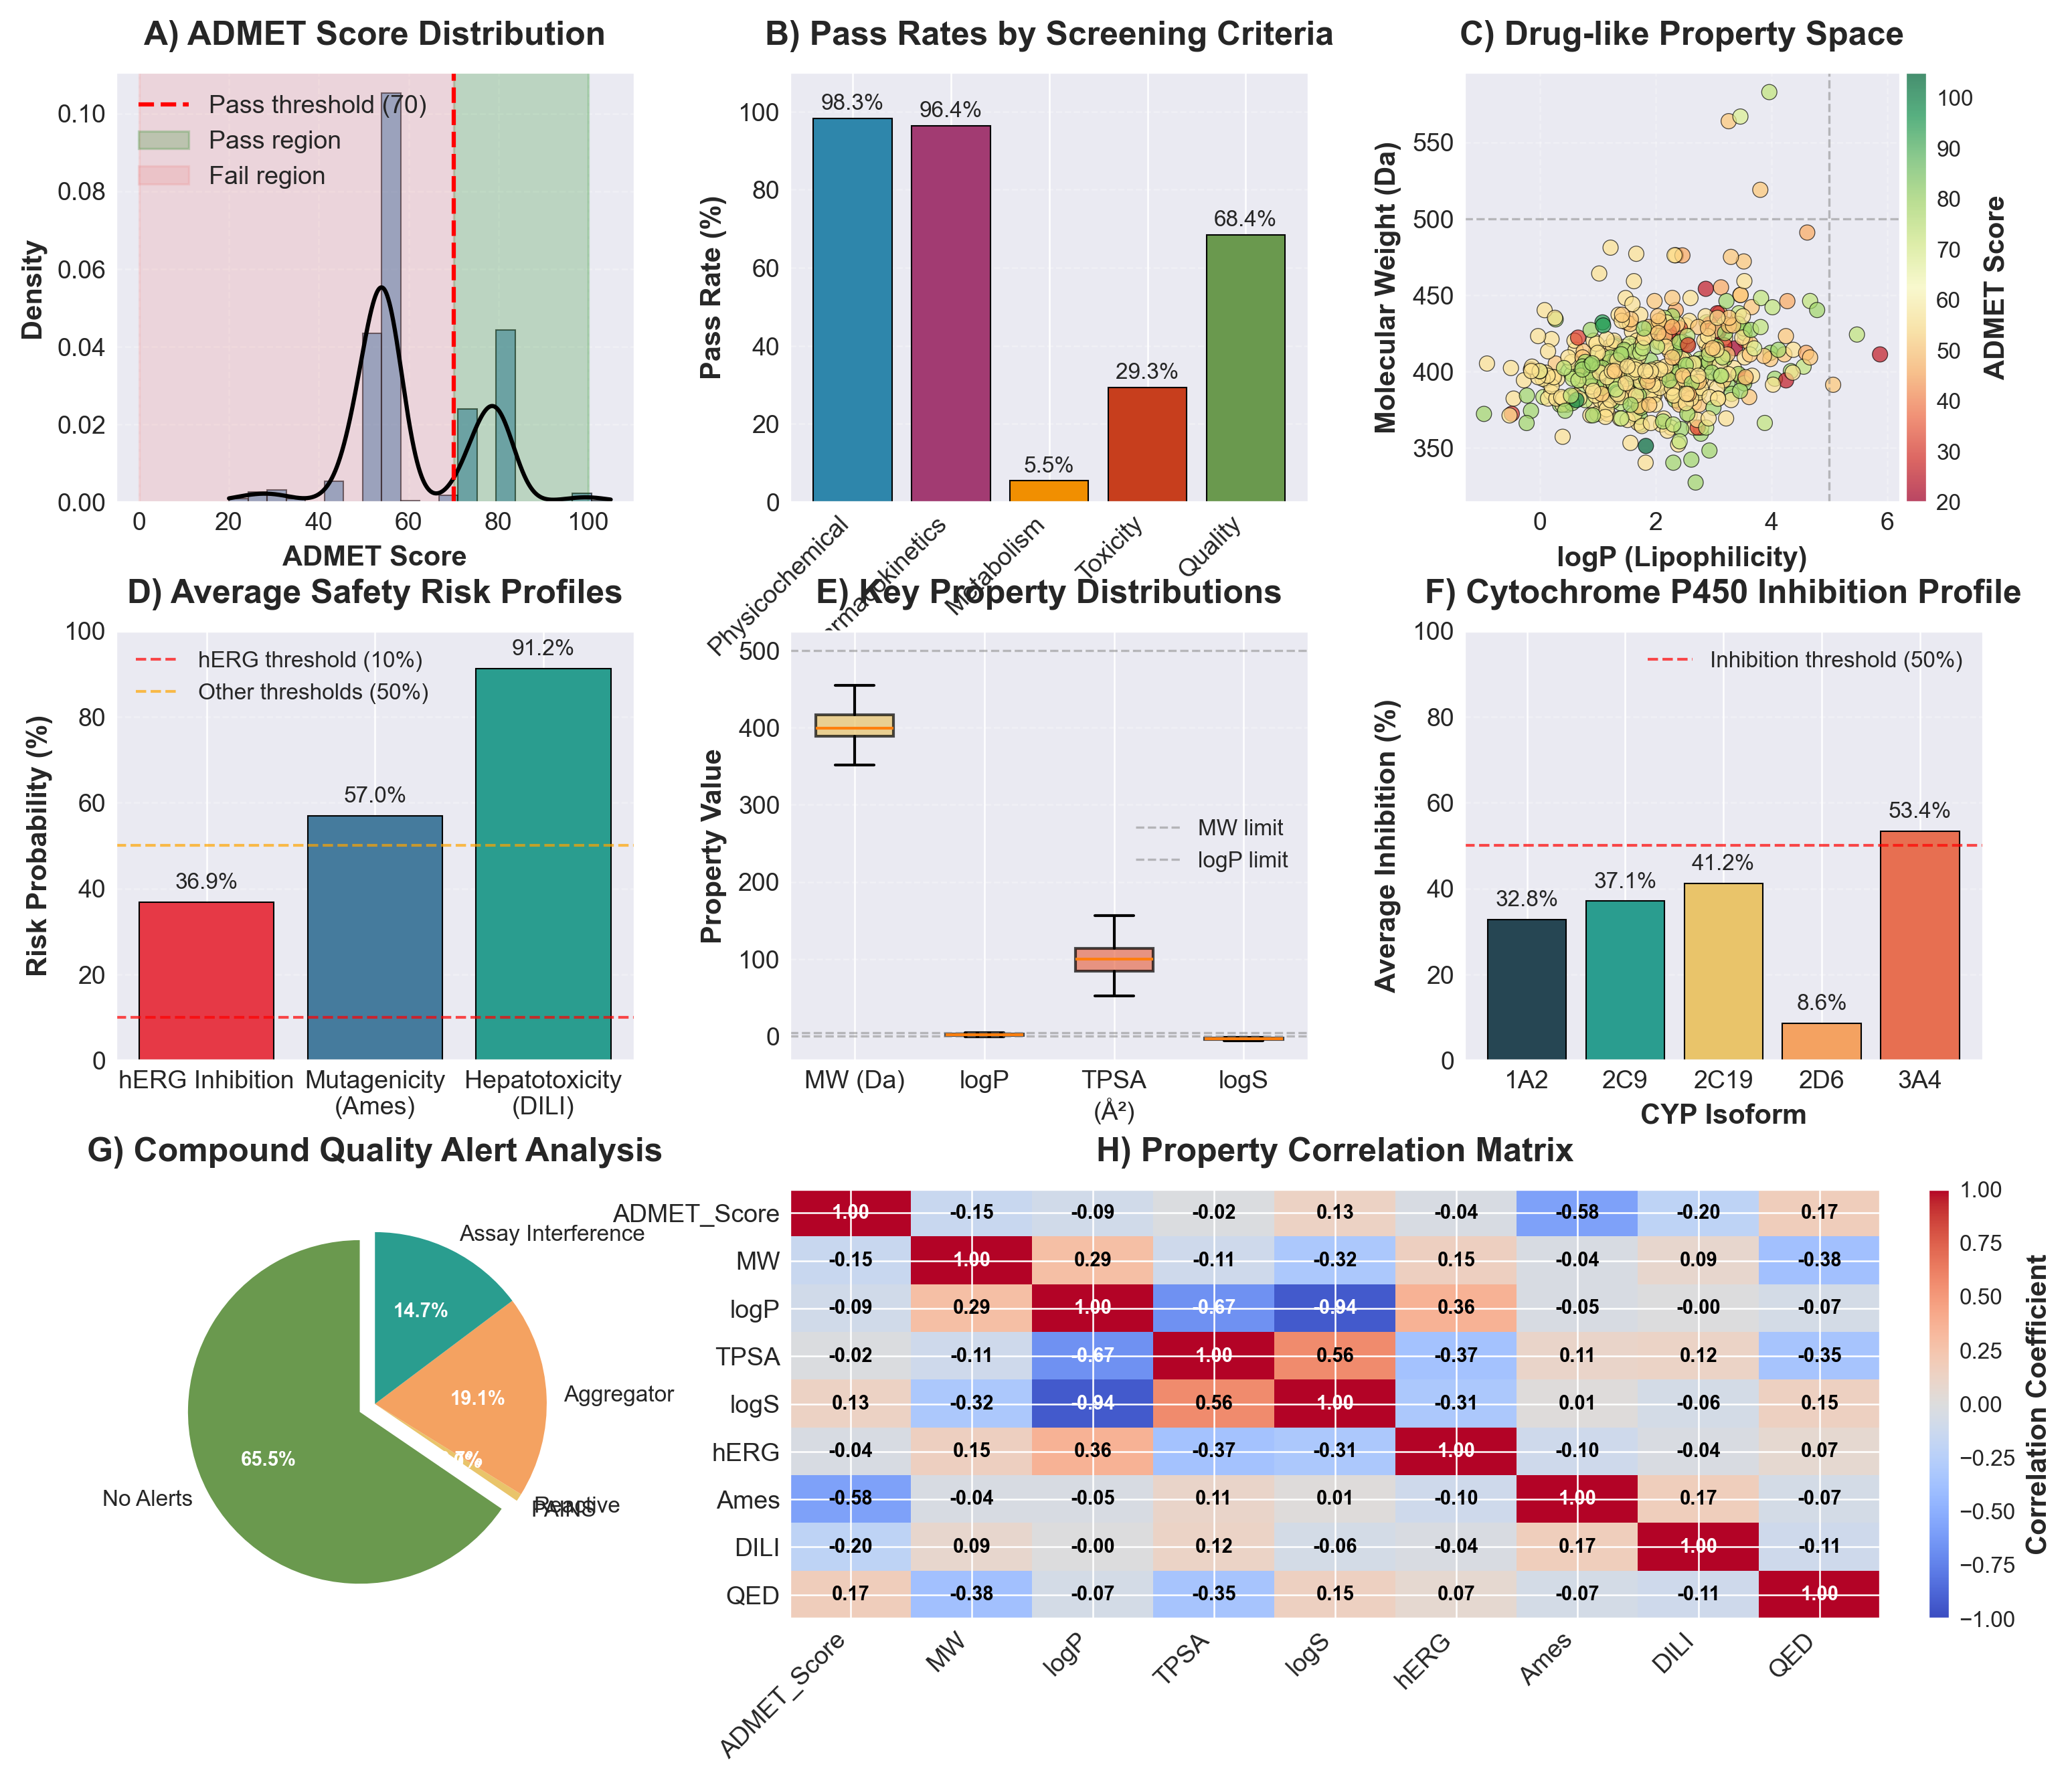

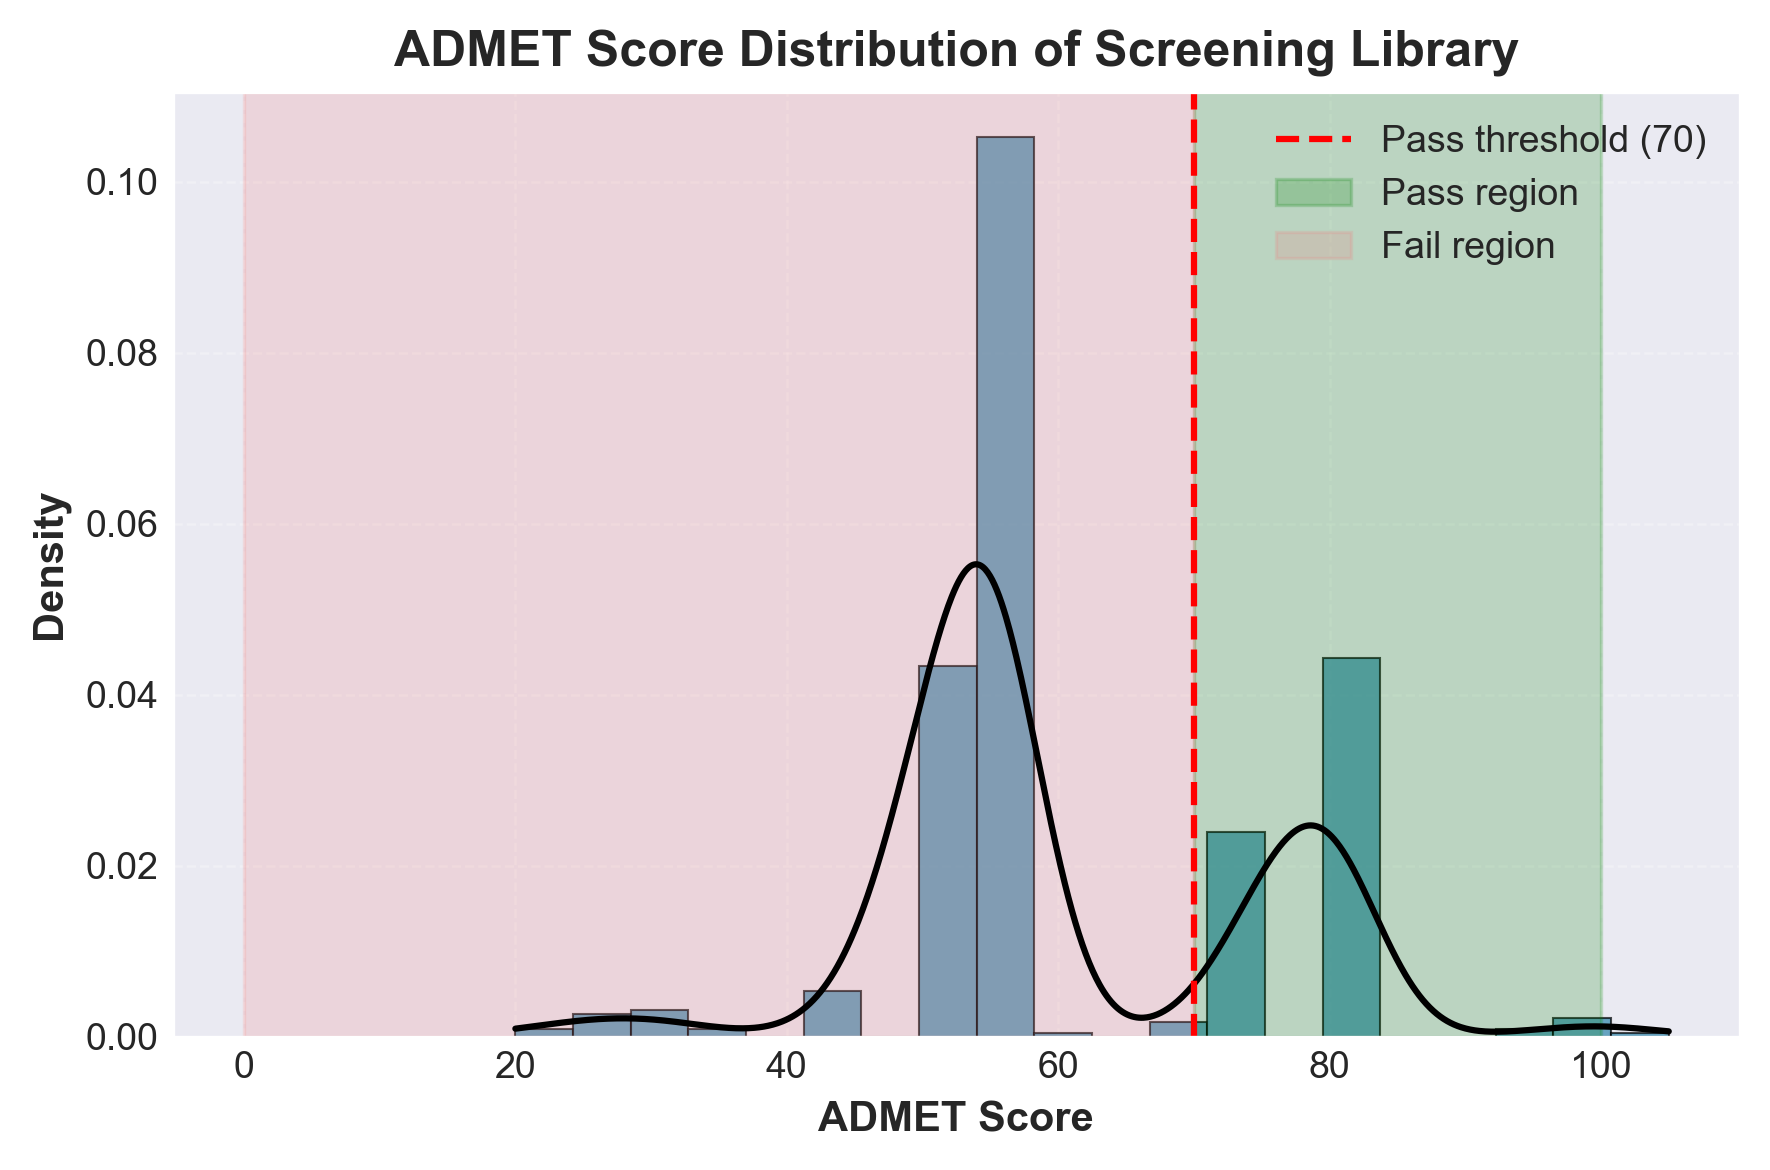

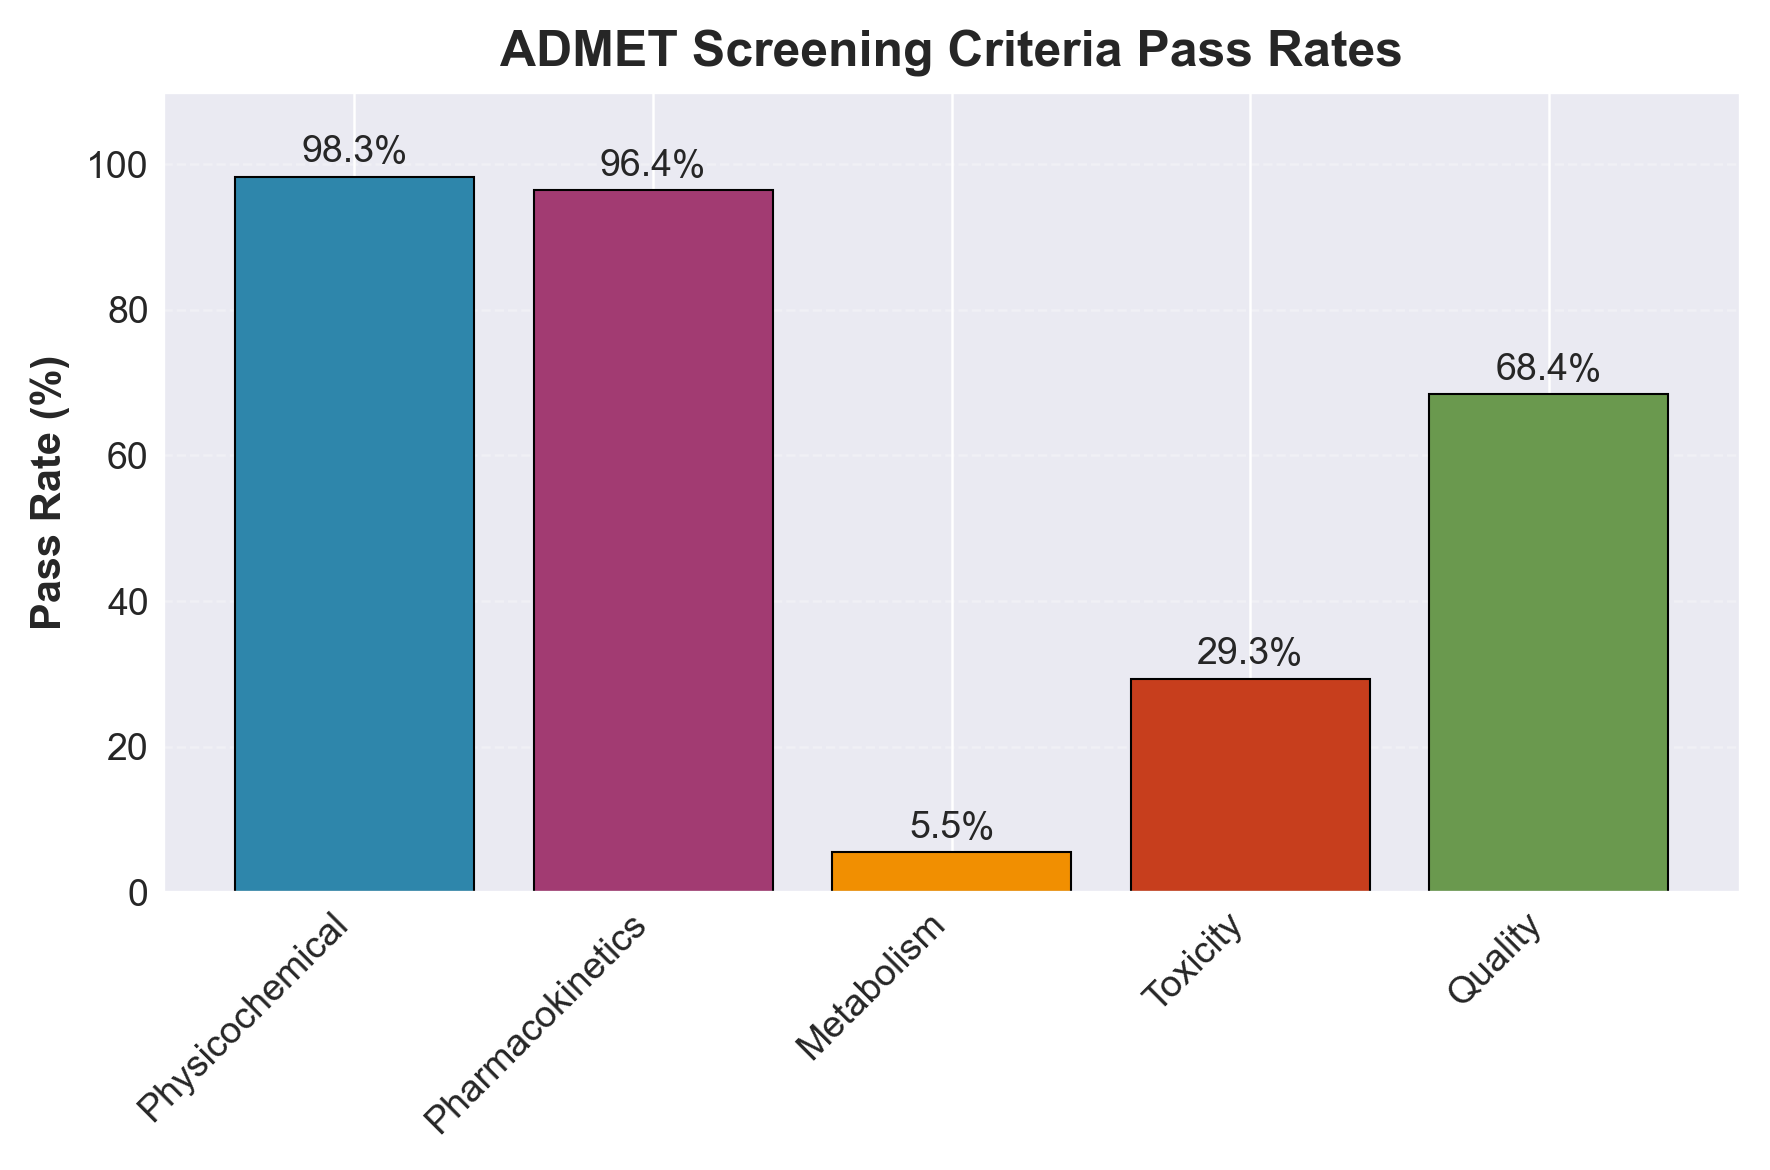

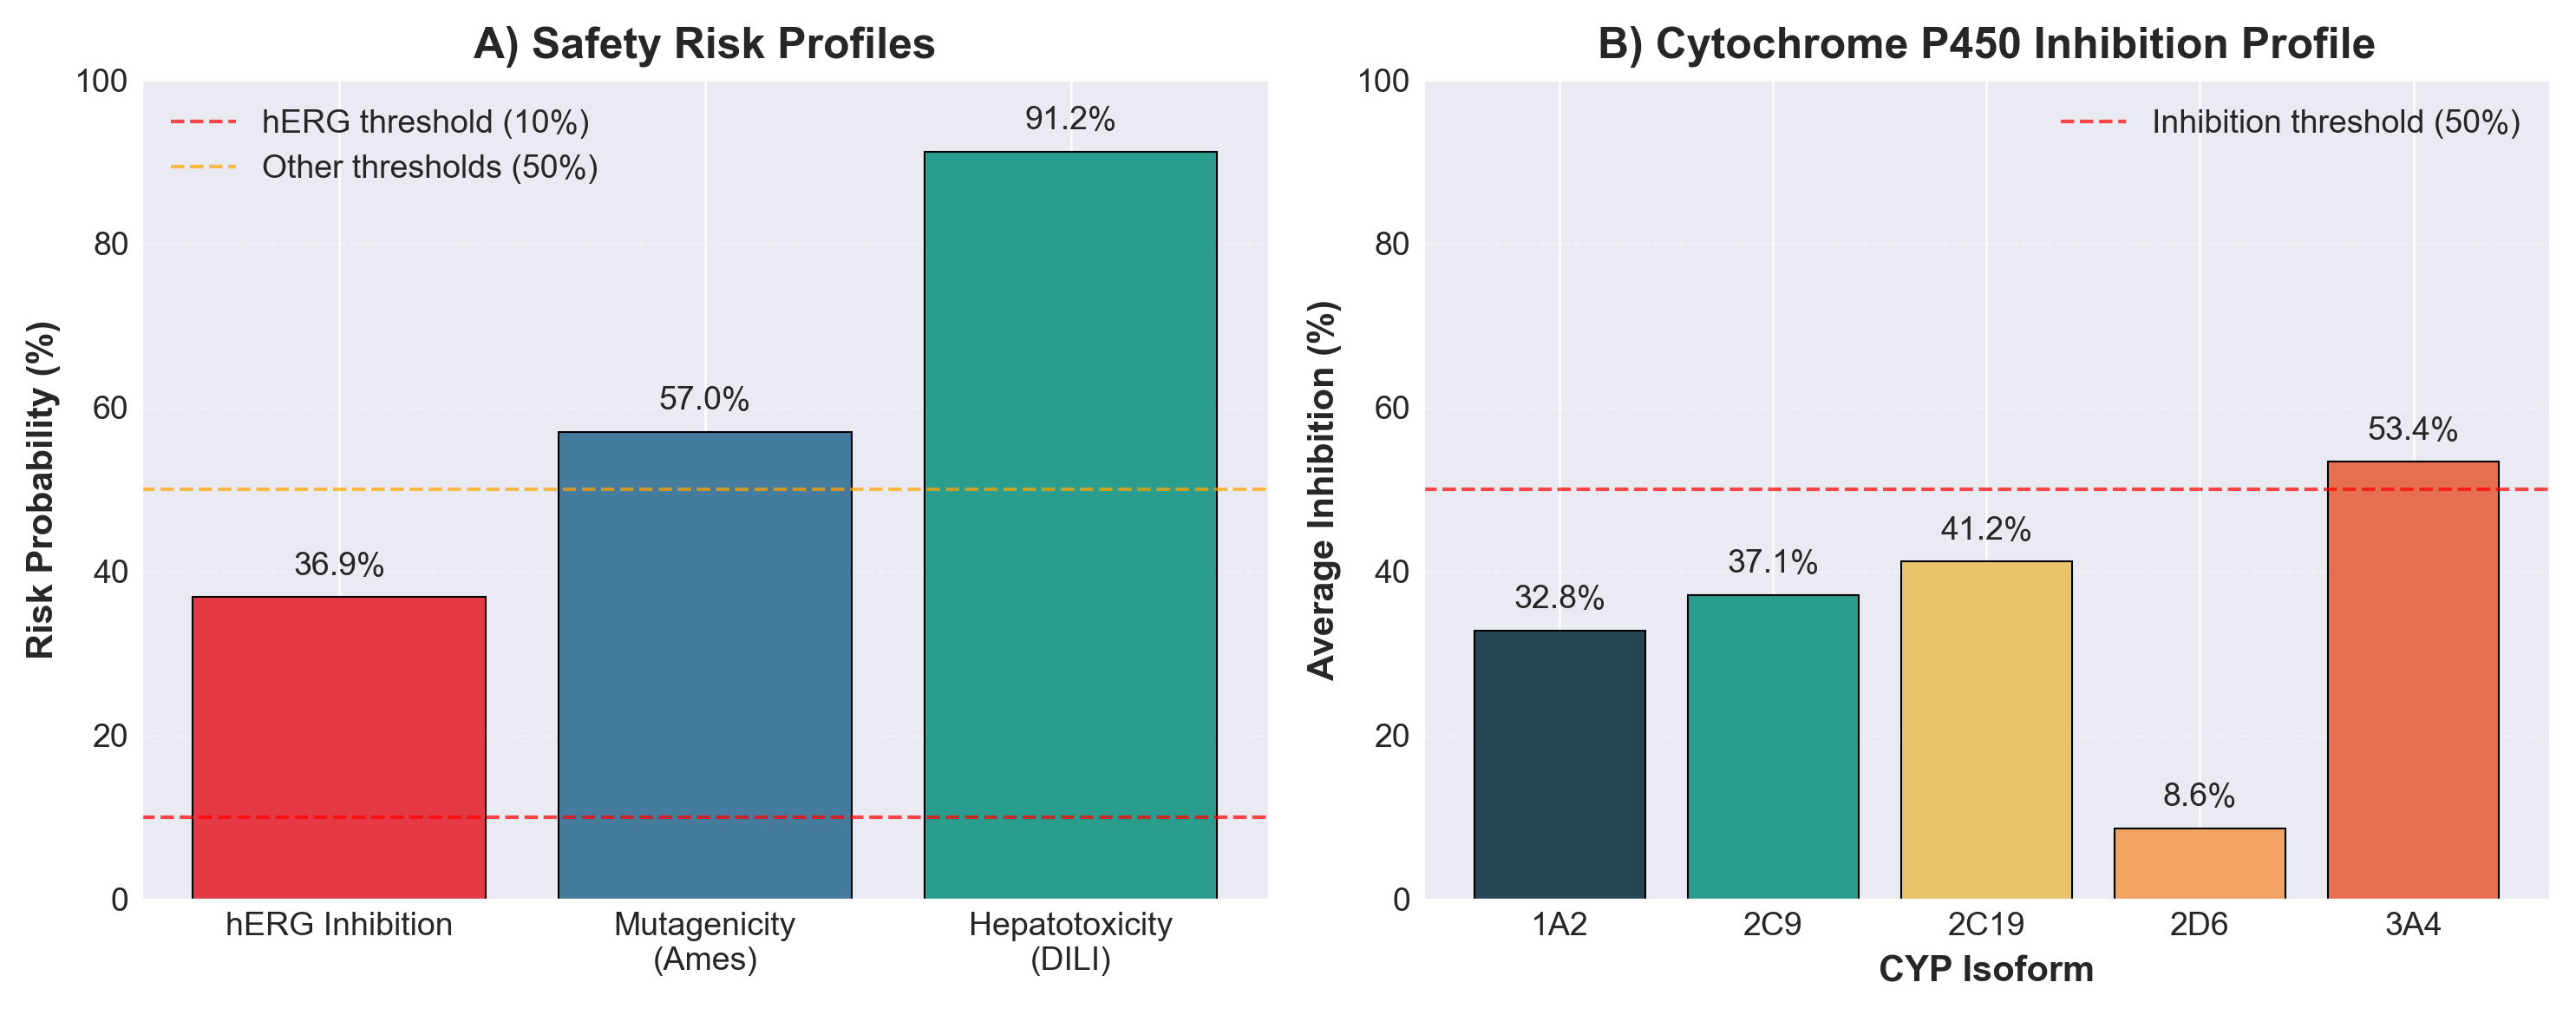

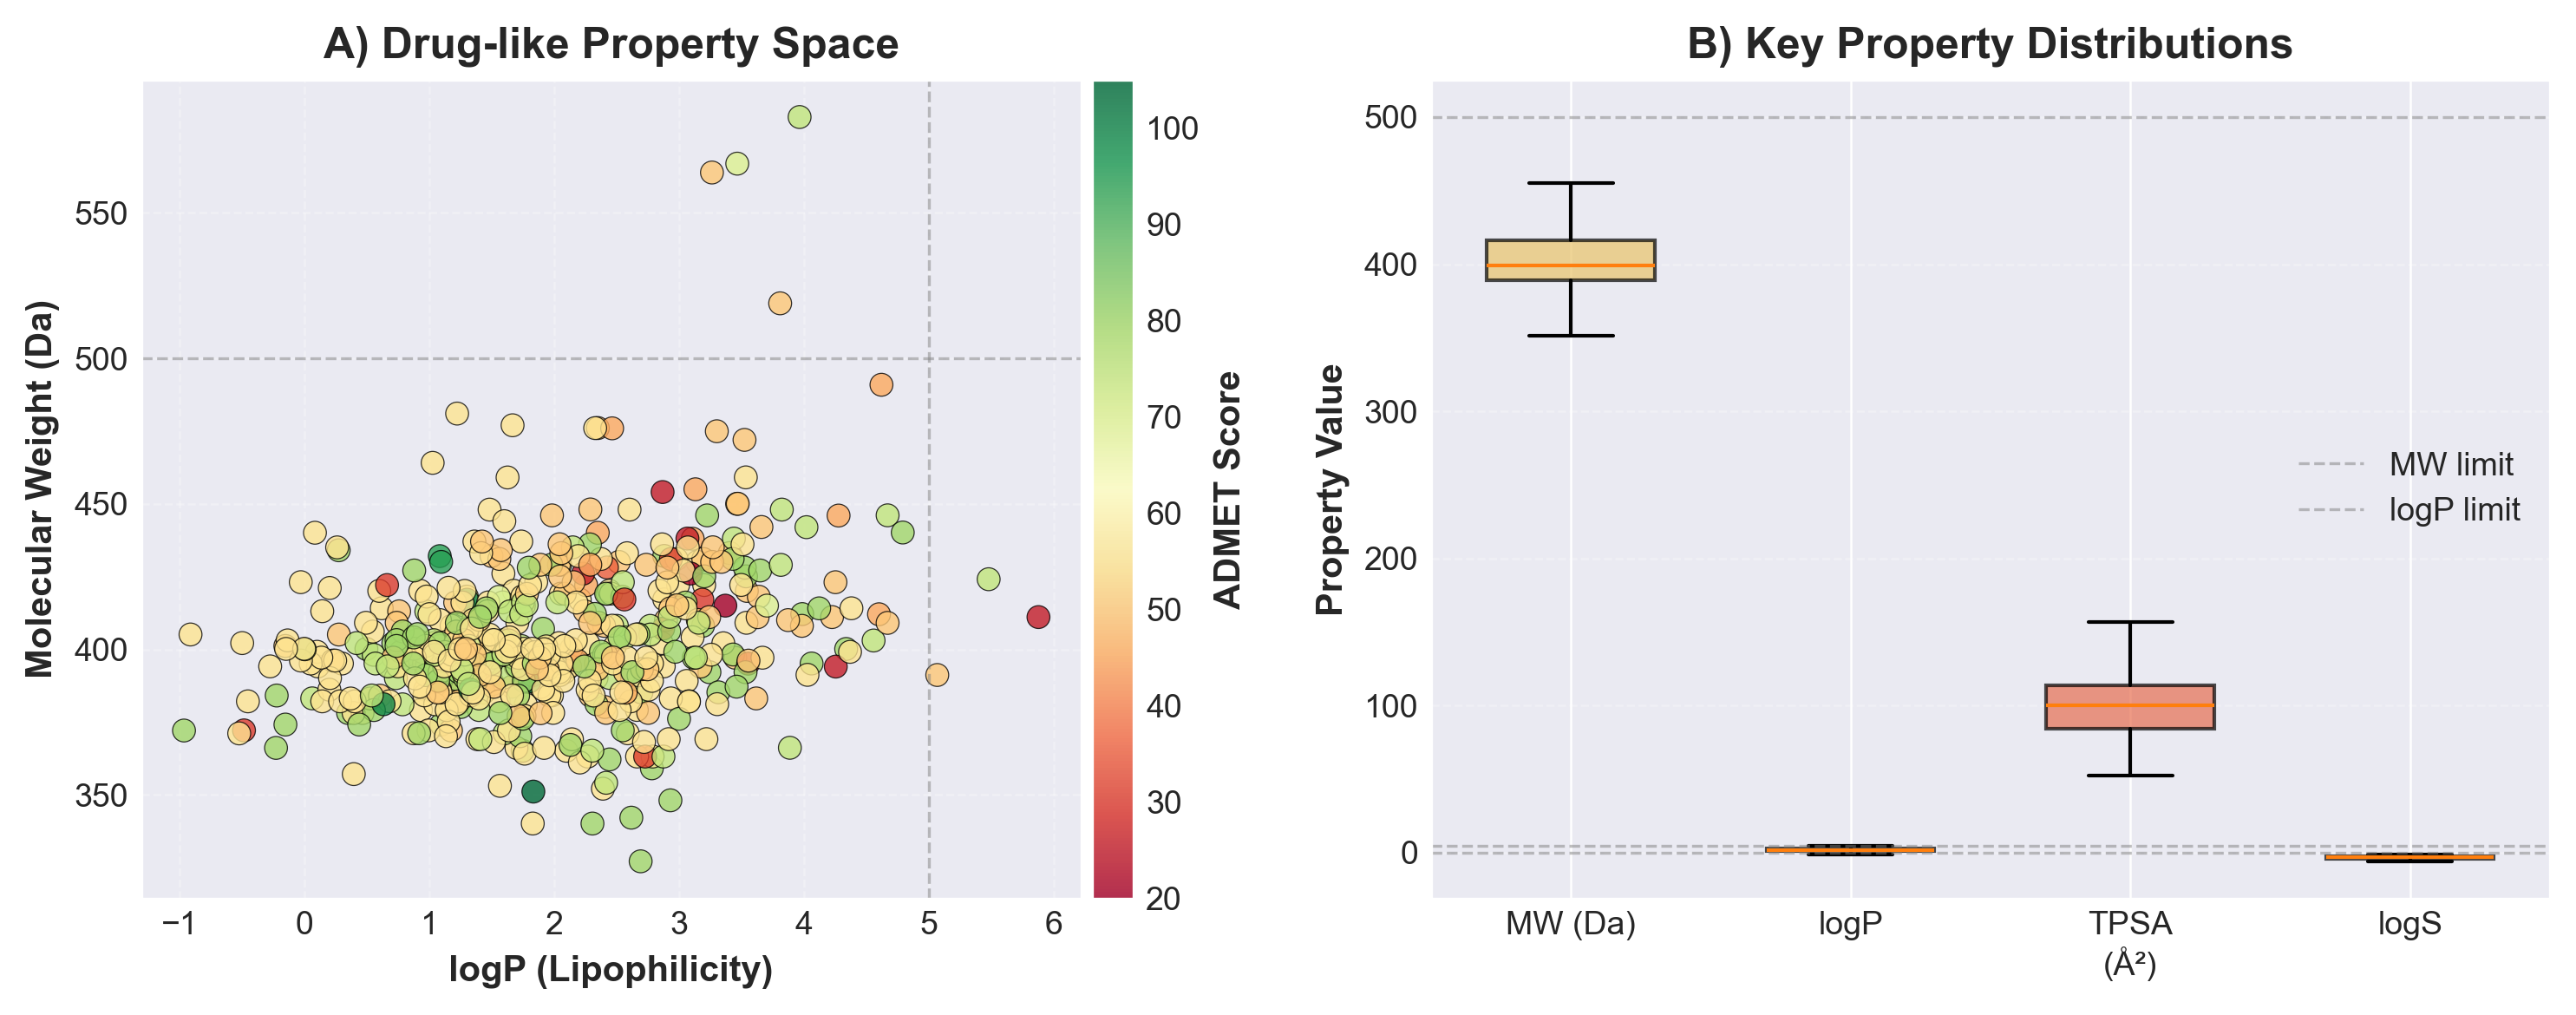


Individual figures saved:
- figure1_admet_score_distribution.png/.pdf
- figure2_screening_criteria.png/.pdf
- figure3_safety_profiles.png/.pdf
- figure4_property_analysis.png/.pdf

Summary table saved:
- admet_screening_summary.csv
- admet_summary_table.tex (LaTeX format)

Summary Statistics:
                                  Metric  Value
                Total compounds screened    532
     Compounds passing overall screening    166
                   Overall pass rate (%)  31.20
Physicochemical properties pass rate (%)  98.31
          Pharmacokinetics pass rate (%)  96.43
       Metabolism & Safety pass rate (%)   5.45
                  Toxicity pass rate (%)  29.32
       Quality (no alerts) pass rate (%)  68.42
 Average ADMET score (passing compounds)  79.07
     Average ADMET score (all compounds)  60.50
           Average molecular weight (Da) 403.30
                            Average logP   1.93
                       Average TPSA (Å²) 100.12
     Average hERG inhibition prob

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

# Set publication quality parameters
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'Arial',
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (7.2, 4.8),  # Nature single column width
    'axes.linewidth': 0.8,
    'lines.linewidth': 1.5,
    'lines.markersize': 4,
    'patch.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'grid.linewidth': 0.6,
})

# Load screened data
screened_df = pd.read_csv('screened_anti_leukemia_candidates.csv')

# Create comprehensive visualization figure
def create_publication_visualizations(screened_df, output_prefix='admet_screening'):
    """
    Generate publication-ready visualizations for ADMET screening results
    """
    
    # Create main figure with subplots
    fig = plt.figure(figsize=(12, 10))
    
    # Define grid layout
    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. ADMET Score Distribution (Top left)
    ax1 = fig.add_subplot(gs[0, 0])
    scores = screened_df['ADMET_Score'].dropna()
    
    # Create histogram with KDE
    n, bins, patches = ax1.hist(scores, bins=20, density=True, alpha=0.6, 
                                color='steelblue', edgecolor='black', linewidth=0.5)
    
    # Add KDE
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(scores)
    x_range = np.linspace(scores.min(), scores.max(), 1000)
    ax1.plot(x_range, kde(x_range), 'k-', linewidth=1.5)
    
    # Add threshold line
    ax1.axvline(x=70, color='red', linestyle='--', linewidth=1.5, 
                label=f'Pass threshold (70)')
    
    # Add pass/fail regions
    ax1.axvspan(70, 100, alpha=0.2, color='green', label='Pass region')
    ax1.axvspan(0, 70, alpha=0.2, color='lightcoral', label='Fail region')
    
    ax1.set_xlabel('ADMET Score', fontweight='bold')
    ax1.set_ylabel('Density', fontweight='bold')
    ax1.set_title('A) ADMET Score Distribution', fontweight='bold', pad=10)
    ax1.legend(frameon=False)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # 2. Pass Rates by Criteria (Top middle)
    ax2 = fig.add_subplot(gs[0, 1])
    criteria = ['Physicochemical', 'Pharmacokinetics', 'Metabolism', 'Toxicity', 'Quality']
    pass_counts = [
        screened_df['Pass_Physicochemical'].sum(),
        screened_df['Pass_Pharmacokinetics'].sum(),
        screened_df['Pass_Metabolism'].sum(),
        screened_df['Pass_Toxicity'].sum(),
        screened_df['Pass_Quality'].sum()
    ]
    pass_rates = [count/len(screened_df)*100 for count in pass_counts]
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
    bars = ax2.bar(criteria, pass_rates, color=colors, edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for bar, rate in zip(bars, pass_rates):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax2.set_ylabel('Pass Rate (%)', fontweight='bold')
    ax2.set_title('B) Pass Rates by Screening Criteria', fontweight='bold', pad=10)
    ax2.set_ylim(0, 110)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 3. Drug-like Property Space (Top right)
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Scatter plot of logP vs MW with quality coloring
    scatter = ax3.scatter(screened_df['logP'], screened_df['MW'],
                         c=screened_df['ADMET_Score'], 
                         cmap='RdYlGn', s=30, alpha=0.7,
                         edgecolors='black', linewidth=0.3)
    
    # Add guidelines for drug-like space
    ax3.axvline(x=5, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    ax3.axhline(y=500, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    
    ax3.set_xlabel('logP (Lipophilicity)', fontweight='bold')
    ax3.set_ylabel('Molecular Weight (Da)', fontweight='bold')
    ax3.set_title('C) Drug-like Property Space', fontweight='bold', pad=10)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3, pad=0.01)
    cbar.set_label('ADMET Score', fontweight='bold')
    cbar.ax.tick_params(labelsize=8)
    
    ax3.grid(True, alpha=0.3, linestyle='--')
    
    # 4. Safety Profile Comparison (Middle left)
    ax4 = fig.add_subplot(gs[1, 0])
    
    safety_metrics = ['hERG', 'Ames', 'DILI']
    safety_data = screened_df[safety_metrics].mean() * 100  # Convert to percentage
    
    colors_safety = ['#E63946', '#457B9D', '#2A9D8F']
    bars_safety = ax4.bar(range(len(safety_data)), safety_data.values, 
                          color=colors_safety, edgecolor='black', linewidth=0.5)
    
    # Add threshold lines (10% for hERG, 50% for others)
    ax4.axhline(y=10, color='red', linestyle='--', alpha=0.7, linewidth=1, 
                label='hERG threshold (10%)')
    ax4.axhline(y=50, color='orange', linestyle='--', alpha=0.7, linewidth=1,
                label='Other thresholds (50%)')
    
    ax4.set_xticks(range(len(safety_data)))
    ax4.set_xticklabels(['hERG Inhibition', 'Mutagenicity\n(Ames)', 'Hepatotoxicity\n(DILI)'])
    ax4.set_ylabel('Risk Probability (%)', fontweight='bold')
    ax4.set_title('D) Average Safety Risk Profiles', fontweight='bold', pad=10)
    ax4.set_ylim(0, 100)
    ax4.legend(frameon=False, fontsize=8)
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Add value labels
    for bar, val in zip(bars_safety, safety_data.values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 5. Property Distribution Comparison (Middle middle)
    ax5 = fig.add_subplot(gs[1, 1])
    
    # Select key properties for boxplot
    properties = ['MW', 'logP', 'TPSA', 'logS']
    property_data = screened_df[properties]
    
    # Create boxplot
    bp = ax5.boxplot([property_data[prop].dropna() for prop in properties],
                     patch_artist=True, widths=0.6, showfliers=False)
    
    # Color the boxes
    colors_box = ['#E9C46A', '#F4A261', '#E76F51', '#2A9D8F']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add guidelines
    ax5.axhline(y=500, color='gray', linestyle='--', alpha=0.5, linewidth=0.8, label='MW limit')
    ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    ax5.axhline(y=5, color='gray', linestyle='--', alpha=0.5, linewidth=0.8, label='logP limit')
    
    ax5.set_xticks(range(1, len(properties) + 1))
    ax5.set_xticklabels(['MW (Da)', 'logP', 'TPSA\n(Å²)', 'logS'], rotation=0)
    ax5.set_ylabel('Property Value', fontweight='bold')
    ax5.set_title('E) Key Property Distributions', fontweight='bold', pad=10)
    ax5.legend(frameon=False, fontsize=8)
    ax5.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # 6. CYP Inhibition Profile (Middle right)
    ax6 = fig.add_subplot(gs[1, 2])
    
    cyp_columns = ['CYP1A2-inh', 'CYP2C9-inh', 'CYP2C19-inh', 'CYP2D6-inh', 'CYP3A4-inh']
    cyp_data = screened_df[cyp_columns].mean() * 100
    
    colors_cyp = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
    bars_cyp = ax6.bar(range(len(cyp_data)), cyp_data.values, 
                       color=colors_cyp, edgecolor='black', linewidth=0.5)
    
    # Add threshold line
    ax6.axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=1,
                label='Inhibition threshold (50%)')
    
    ax6.set_xticks(range(len(cyp_data)))
    ax6.set_xticklabels(['1A2', '2C9', '2C19', '2D6', '3A4'], rotation=0)
    ax6.set_xlabel('CYP Isoform', fontweight='bold')
    ax6.set_ylabel('Average Inhibition (%)', fontweight='bold')
    ax6.set_title('F) Cytochrome P450 Inhibition Profile', fontweight='bold', pad=10)
    ax6.set_ylim(0, 100)
    ax6.legend(frameon=False, fontsize=8)
    ax6.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Add value labels
    for bar, val in zip(bars_cyp, cyp_data.values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 7. Quality Alert Analysis (Bottom left)
    ax7 = fig.add_subplot(gs[2, 0])
    
    # Count quality alerts
    quality_alerts = screened_df['Quality_Alerts']
    no_alerts = (quality_alerts == 'No alerts').sum()
    with_alerts = len(screened_df) - no_alerts
    
    # Breakdown of alert types
    alert_types = {'PAINS': 0, 'Reactive': 0, 'Aggregator': 0, 'Assay Interference': 0}
    for alert in quality_alerts:
        if alert != 'No alerts':
            alert_list = alert.split('; ')
            for a in alert_list:
                if 'PAINS' in a:
                    alert_types['PAINS'] += 1
                elif 'Reactive' in a:
                    alert_types['Reactive'] += 1
                elif 'Aggregator' in a:
                    alert_types['Aggregator'] += 1
                elif 'Assay' in a:
                    alert_types['Assay Interference'] += 1
    
    # Create pie chart
    sizes = [no_alerts] + list(alert_types.values())
    labels = ['No Alerts', 'PAINS', 'Reactive', 'Aggregator', 'Assay Interference']
    colors_pie = ['#6A994E', '#BC4749', '#E9C46A', '#F4A261', '#2A9D8F']
    explode = (0.1, 0, 0, 0, 0)  # explode the 'No Alerts' slice
    
    wedges, texts, autotexts = ax7.pie(sizes, explode=explode, labels=labels, 
                                        colors=colors_pie, autopct='%1.1f%%',
                                        startangle=90, textprops={'fontsize': 8})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(7)
    
    ax7.set_title('G) Compound Quality Alert Analysis', fontweight='bold', pad=10)
    
    # 8. Correlation Heatmap (Bottom middle-right, spanning two columns)
    ax8 = fig.add_subplot(gs[2, 1:])
    
    # Select key properties for correlation
    corr_columns = ['ADMET_Score', 'MW', 'logP', 'TPSA', 'logS', 'hERG', 'Ames', 'DILI', 'QED']
    corr_data = screened_df[corr_columns].corr()
    
    # Create heatmap
    im = ax8.imshow(corr_data, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    
    # Add text annotations
    for i in range(len(corr_columns)):
        for j in range(len(corr_columns)):
            text = ax8.text(j, i, f'{corr_data.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black" if abs(corr_data.iloc[i, j]) < 0.6 else "white",
                           fontsize=7, fontweight='bold')
    
    ax8.set_xticks(range(len(corr_columns)))
    ax8.set_yticks(range(len(corr_columns)))
    ax8.set_xticklabels(corr_columns, rotation=45, ha='right')
    ax8.set_yticklabels(corr_columns)
    ax8.set_title('H) Property Correlation Matrix', fontweight='bold', pad=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax8, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation Coefficient', fontweight='bold')
    cbar.ax.tick_params(labelsize=8)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    output_files = []
    for fmt in ['png', 'pdf', 'tiff', 'svg']:
        filename = f'{output_prefix}_figure.{fmt}'
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        output_files.append(filename)
        print(f"Saved: {filename}")
    
    plt.show()
    
    # Create individual plots for manuscript figures
    create_individual_plots(screened_df)
    
    return output_files

def create_individual_plots(screened_df):
    """
    Create individual high-quality plots for manuscript figures
    """
    
    # Figure 1: ADMET Score Distribution
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    scores = screened_df['ADMET_Score'].dropna()
    
    n, bins, patches = ax1.hist(scores, bins=20, density=True, alpha=0.7, 
                                color='#2E86AB', edgecolor='black', linewidth=0.5)
    
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(scores)
    x_range = np.linspace(scores.min(), scores.max(), 1000)
    ax1.plot(x_range, kde(x_range), 'k-', linewidth=1.5)
    
    ax1.axvline(x=70, color='red', linestyle='--', linewidth=1.5, label='Pass threshold (70)')
    ax1.axvspan(70, 100, alpha=0.2, color='green', label='Pass region')
    ax1.axvspan(0, 70, alpha=0.2, color='lightcoral', label='Fail region')
    
    ax1.set_xlabel('ADMET Score', fontweight='bold')
    ax1.set_ylabel('Density', fontweight='bold')
    ax1.set_title('ADMET Score Distribution of Screening Library', fontweight='bold')
    ax1.legend(frameon=False)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('figure1_admet_score_distribution.png', dpi=300, bbox_inches='tight')
    plt.savefig('figure1_admet_score_distribution.pdf', bbox_inches='tight')
    plt.show()
    
    # Figure 2: Screening Criteria Pass Rates
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    
    criteria = ['Physicochemical', 'Pharmacokinetics', 'Metabolism', 'Toxicity', 'Quality']
    pass_counts = [
        screened_df['Pass_Physicochemical'].sum(),
        screened_df['Pass_Pharmacokinetics'].sum(),
        screened_df['Pass_Metabolism'].sum(),
        screened_df['Pass_Toxicity'].sum(),
        screened_df['Pass_Quality'].sum()
    ]
    pass_rates = [count/len(screened_df)*100 for count in pass_counts]
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
    bars = ax2.bar(criteria, pass_rates, color=colors, edgecolor='black', linewidth=0.5)
    
    for bar, rate in zip(bars, pass_rates):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)
    
    ax2.set_ylabel('Pass Rate (%)', fontweight='bold')
    ax2.set_title('ADMET Screening Criteria Pass Rates', fontweight='bold')
    ax2.set_ylim(0, 110)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('figure2_screening_criteria.png', dpi=300, bbox_inches='tight')
    plt.savefig('figure2_screening_criteria.pdf', bbox_inches='tight')
    plt.show()
    
    # Figure 3: Safety Profile Comparison
    fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Safety metrics
    safety_metrics = ['hERG', 'Ames', 'DILI']
    safety_data = screened_df[safety_metrics].mean() * 100
    
    colors_safety = ['#E63946', '#457B9D', '#2A9D8F']
    bars_safety = ax3a.bar(range(len(safety_data)), safety_data.values, 
                           color=colors_safety, edgecolor='black', linewidth=0.5)
    
    ax3a.axhline(y=10, color='red', linestyle='--', alpha=0.7, linewidth=1, 
                 label='hERG threshold (10%)')
    ax3a.axhline(y=50, color='orange', linestyle='--', alpha=0.7, linewidth=1,
                 label='Other thresholds (50%)')
    
    ax3a.set_xticks(range(len(safety_data)))
    ax3a.set_xticklabels(['hERG Inhibition', 'Mutagenicity\n(Ames)', 'Hepatotoxicity\n(DILI)'])
    ax3a.set_ylabel('Risk Probability (%)', fontweight='bold')
    ax3a.set_title('A) Safety Risk Profiles', fontweight='bold')
    ax3a.set_ylim(0, 100)
    ax3a.legend(frameon=False, fontsize=9)
    ax3a.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    for bar, val in zip(bars_safety, safety_data.values):
        height = bar.get_height()
        ax3a.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # CYP inhibition profile
    cyp_columns = ['CYP1A2-inh', 'CYP2C9-inh', 'CYP2C19-inh', 'CYP2D6-inh', 'CYP3A4-inh']
    cyp_data = screened_df[cyp_columns].mean() * 100
    
    colors_cyp = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
    bars_cyp = ax3b.bar(range(len(cyp_data)), cyp_data.values, 
                        color=colors_cyp, edgecolor='black', linewidth=0.5)
    
    ax3b.axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=1,
                 label='Inhibition threshold (50%)')
    
    ax3b.set_xticks(range(len(cyp_data)))
    ax3b.set_xticklabels(['1A2', '2C9', '2C19', '2D6', '3A4'])
    ax3b.set_xlabel('CYP Isoform', fontweight='bold')
    ax3b.set_ylabel('Average Inhibition (%)', fontweight='bold')
    ax3b.set_title('B) Cytochrome P450 Inhibition Profile', fontweight='bold')
    ax3b.set_ylim(0, 100)
    ax3b.legend(frameon=False, fontsize=9)
    ax3b.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    for bar, val in zip(bars_cyp, cyp_data.values):
        height = bar.get_height()
        ax3b.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('figure3_safety_profiles.png', dpi=300, bbox_inches='tight')
    plt.savefig('figure3_safety_profiles.pdf', bbox_inches='tight')
    plt.show()
    
    # Figure 4: Property Space and Correlation
    fig4, (ax4a, ax4b) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Property space
    scatter = ax4a.scatter(screened_df['logP'], screened_df['MW'],
                          c=screened_df['ADMET_Score'], 
                          cmap='RdYlGn', s=40, alpha=0.8,
                          edgecolors='black', linewidth=0.3)
    
    ax4a.axvline(x=5, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    ax4a.axhline(y=500, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    
    ax4a.set_xlabel('logP (Lipophilicity)', fontweight='bold')
    ax4a.set_ylabel('Molecular Weight (Da)', fontweight='bold')
    ax4a.set_title('A) Drug-like Property Space', fontweight='bold')
    
    cbar = plt.colorbar(scatter, ax=ax4a, pad=0.01)
    cbar.set_label('ADMET Score', fontweight='bold')
    cbar.ax.tick_params(labelsize=9)
    
    ax4a.grid(True, alpha=0.3, linestyle='--')
    
    # Property distributions
    properties = ['MW', 'logP', 'TPSA', 'logS']
    property_data = screened_df[properties]
    
    bp = ax4b.boxplot([property_data[prop].dropna() for prop in properties],
                      patch_artist=True, widths=0.6, showfliers=False)
    
    colors_box = ['#E9C46A', '#F4A261', '#E76F51', '#2A9D8F']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4b.axhline(y=500, color='gray', linestyle='--', alpha=0.5, linewidth=0.8, label='MW limit')
    ax4b.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    ax4b.axhline(y=5, color='gray', linestyle='--', alpha=0.5, linewidth=0.8, label='logP limit')
    
    ax4b.set_xticks(range(1, len(properties) + 1))
    ax4b.set_xticklabels(['MW (Da)', 'logP', 'TPSA\n(Å²)', 'logS'])
    ax4b.set_ylabel('Property Value', fontweight='bold')
    ax4b.set_title('B) Key Property Distributions', fontweight='bold')
    ax4b.legend(frameon=False, fontsize=9)
    ax4b.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    plt.tight_layout()
    plt.savefig('figure4_property_analysis.png', dpi=300, bbox_inches='tight')
    plt.savefig('figure4_property_analysis.pdf', bbox_inches='tight')
    plt.show()
    
    print("\nIndividual figures saved:")
    print("- figure1_admet_score_distribution.png/.pdf")
    print("- figure2_screening_criteria.png/.pdf")
    print("- figure3_safety_profiles.png/.pdf")
    print("- figure4_property_analysis.png/.pdf")

# Generate visualizations
print("Generating publication-ready visualizations...")
output_files = create_publication_visualizations(screened_df)

# Create summary statistics table for paper
def create_summary_table(screened_df):
    """Create LaTeX-formatted summary table"""
    
    summary_data = {
        'Metric': [
            'Total compounds screened',
            'Compounds passing overall screening',
            'Overall pass rate (%)',
            'Physicochemical properties pass rate (%)',
            'Pharmacokinetics pass rate (%)',
            'Metabolism & Safety pass rate (%)',
            'Toxicity pass rate (%)',
            'Quality (no alerts) pass rate (%)',
            'Average ADMET score (passing compounds)',
            'Average ADMET score (all compounds)',
            'Average molecular weight (Da)',
            'Average logP',
            'Average TPSA (Å²)',
            'Average hERG inhibition probability',
            'Average Ames mutagenicity probability',
            'Average DILI probability'
        ],
        'Value': [
            len(screened_df),
            screened_df['Pass_Overall'].sum(),
            f"{screened_df['Pass_Overall'].mean()*100:.2f}",
            f"{screened_df['Pass_Physicochemical'].mean()*100:.2f}",
            f"{screened_df['Pass_Pharmacokinetics'].mean()*100:.2f}",
            f"{screened_df['Pass_Metabolism'].mean()*100:.2f}",
            f"{screened_df['Pass_Toxicity'].mean()*100:.2f}",
            f"{screened_df['Pass_Quality'].mean()*100:.2f}",
            f"{screened_df[screened_df['Pass_Overall']]['ADMET_Score'].mean():.2f}",
            f"{screened_df['ADMET_Score'].mean():.2f}",
            f"{screened_df['MW'].mean():.2f}",
            f"{screened_df['logP'].mean():.2f}",
            f"{screened_df['TPSA'].mean():.2f}",
            f"{screened_df['hERG'].mean():.4f}",
            f"{screened_df['Ames'].mean():.4f}",
            f"{screened_df['DILI'].mean():.4f}"
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save as CSV
    summary_df.to_csv('admet_screening_summary.csv', index=False)
    
    # Generate LaTeX table
    latex_table = summary_df.to_latex(index=False, 
                                      caption='Summary of ADMET screening results for anti-leukemia compounds.',
                                      label='tab:admet_summary',
                                      column_format='l r')
    
    with open('admet_summary_table.tex', 'w') as f:
        f.write(latex_table)
    
    print("\nSummary table saved:")
    print("- admet_screening_summary.csv")
    print("- admet_summary_table.tex (LaTeX format)")
    
    return summary_df

# Create summary table
summary_df = create_summary_table(screened_df)
print("\nSummary Statistics:")
print(summary_df.to_string(index=False))

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools
import numpy as np

def select_docking_candidates(screened_df, n_candidates=20):
    """
    Select optimal compounds for molecular docking with diversity consideration
    """
    
    # Filter for high-quality candidates
    candidates = screened_df[
        (screened_df['Pass_Overall'] == True) &
        (screened_df['ADMET_Score'] >= 70) &
        (screened_df['hERG'] < 0.2)  # Safety first
    ].copy()
    
    print(f"Initial candidates meeting basic criteria: {len(candidates)}")
    
    # Calculate diversity scores
    candidates = calculate_diversity_scores(candidates)
    
    # Rank candidates using weighted scoring
    def calculate_docking_score(row):
        score = 0
        
        # ADMET score weight (40%)
        score += row['ADMET_Score'] * 0.4
        
        # Safety weight (30%)
        safety_score = (1 - row['hERG']) * 15 + (1 - row['Ames']) * 10 + (1 - row['DILI']) * 5
        score += safety_score
        
        # Drug-likeness weight (20%)
        druglike_score = 0
        if 300 <= row['MW'] <= 500:
            druglike_score += 5
        if 0 <= row['logP'] <= 5:
            druglike_score += 5
        if row['TPSA'] <= 140:
            druglike_score += 5
        if row['QED'] > 0.5:
            druglike_score += 5
        score += druglike_score
        
        # Diversity bonus (10%)
        if 'Diversity_Score' in row and not pd.isna(row['Diversity_Score']):
            score += row['Diversity_Score'] * 10
        
        # Penalty for alerts
        if row['Quality_Alerts'] != 'No alerts':
            score -= 10
        
        return score
    
    candidates['Docking_Score'] = candidates.apply(calculate_docking_score, axis=1)
    
    # Sort by docking score
    candidates = candidates.sort_values('Docking_Score', ascending=False)
    
    # Select top candidates
    selected = candidates.head(min(n_candidates, len(candidates)))
    
    return selected

def calculate_diversity_scores(df):
    """
    Calculate molecular diversity scores using RDKit fingerprints
    """
    try:
        from rdkit import Chem
        from rdkit.Chem import AllChem
        from rdkit import DataStructs
        import numpy as np
        
        # Generate Morgan fingerprints
        fps = []
        valid_indices = []
        
        for idx, row in df.iterrows():
            try:
                mol = Chem.MolFromSmiles(row['SMILES'])
                if mol:
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
                    fps.append(fp)
                    valid_indices.append(idx)
            except:
                continue
        
        if len(fps) > 1:
            # Calculate pairwise Tanimoto similarities
            similarities = []
            for i in range(len(fps)):
                for j in range(i+1, len(fps)):
                    sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
                    similarities.append(sim)
            
            # Diversity score is 1 - average similarity
            avg_sim = np.mean(similarities) if similarities else 1
            diversity_score = 1 - avg_sim
            
            # Assign to all valid molecules
            for idx in valid_indices:
                df.loc[idx, 'Diversity_Score'] = diversity_score
    
    except ImportError:
        print("RDKit not available for diversity calculation")
    
    return df

# Load your data
screened_df = pd.read_csv('screened_anti_leukemia_candidates.csv')

# Select candidates
docking_candidates = select_docking_candidates(screened_df, n_candidates=20)

print(f"\nSelected {len(docking_candidates)} compounds for molecular docking:")
print("="*80)

# Display in a nice format
for i, (idx, row) in enumerate(docking_candidates.iterrows(), 1):
    print(f"\n{i}. {row['zincid']}")
    print(f"   ADMET Score: {row['ADMET_Score']:.1f}")
    print(f"   Safety: hERG={row['hERG']:.3f}, Ames={row['Ames']:.3f}, DILI={row['DILI']:.3f}")
    print(f"   Properties: MW={row['MW']:.1f}, logP={row['logP']:.2f}, TPSA={row['TPSA']:.2f}")
    print(f"   Quality: {row['Quality_Alerts']}")
    print(f"   SMILES: {row['SMILES'][:50]}...")

# Save selection to CSV
docking_candidates[['zincid', 'SMILES', 'ADMET_Score', 'Docking_Score', 
                    'hERG', 'Ames', 'DILI', 'MW', 'logP', 'TPSA', 
                    'Quality_Alerts']].to_csv('selected_docking_candidates.csv', index=False)

print(f"\nSaved selection to: selected_docking_candidates.csv")

# Generate PDBQT files for docking (AutoDock Vina format)
def generate_docking_files(df, output_dir='docking_inputs'):
    """
    Generate input files for molecular docking
    """
    import os
    from rdkit import Chem
    from rdkit.Chem import AllChem
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save SMILES file
    smiles_file = os.path.join(output_dir, 'candidates.smi')
    with open(smiles_file, 'w') as f:
        for _, row in df.iterrows():
            f.write(f"{row['SMILES']} {row['zincid']}\n")
    
    print(f"\nGenerated SMILES file: {smiles_file}")
    
    # Generate 3D coordinates (requires RDKit)
    try:
        print("\nGenerating 3D structures...")
        mol_files = []
        
        for _, row in df.iterrows():
            mol_id = row['zincid']
            smiles = row['SMILES']
            
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    # Add hydrogens
                    mol = Chem.AddHs(mol)
                    
                    # Generate 3D coordinates
                    AllChem.EmbedMolecule(mol, randomSeed=42)
                    AllChem.MMFFOptimizeMolecule(mol)
                    
                    # Save as PDB
                    pdb_file = os.path.join(output_dir, f"{mol_id}.pdb")
                    Chem.MolToPDBFile(mol, pdb_file)
                    
                    # Save as MOL2
                    mol2_file = os.path.join(output_dir, f"{mol_id}.mol2")
                    # Chem.MolToMolFile(mol, mol2_file)
                    
                    mol_files.append(pdb_file)
                    print(f"  Generated: {mol_id}.pdb")
                    
            except Exception as e:
                print(f"  Error processing {mol_id}: {str(e)}")
        
        print(f"\nGenerated {len(mol_files)} 3D structures in {output_dir}")
        
        # Create README file
        readme_file = os.path.join(output_dir, 'README.txt')
        with open(readme_file, 'w') as f:
            f.write("Molecular Docking Input Files\n")
            f.write("="*40 + "\n\n")
            f.write(f"Total compounds: {len(df)}\n")
            f.write(f"Generated on: {pd.Timestamp.now()}\n\n")
            f.write("Files:\n")
            f.write("- candidates.smi: SMILES strings with IDs\n")
            f.write("- *.pdb: 3D structures in PDB format\n")
            f.write("- selected_docking_candidates.csv: Selection details\n\n")
            f.write("Recommended docking software:\n")
            f.write("1. AutoDock Vina\n")
            f.write("2. Schrödinger Glide\n")
            f.write("3. UCSF DOCK\n")
            f.write("4. GOLD\n")
    
    except ImportError:
        print("\nRDKit not available for 3D structure generation.")
        print("Install with: conda install -c conda-forge rdkit")

# Generate docking input files
generate_docking_files(docking_candidates)

print("\n" + "="*80)
print("RECOMMENDED DOCKING PROTOCOL:")
print("="*80)
print("""
1. TARGET SELECTION:
   - Choose leukemia-related targets (e.g., BCL-2, FLT3, JAK2, BTK)
   - Obtain crystal structures from PDB database

2. PREPARATION STEPS:
   a. Prepare protein:
      - Remove water molecules (except catalytic waters)
      - Add hydrogens and assign charges
      - Define binding site (from co-crystallized ligand)
   
   b. Prepare ligands:
      - Convert to 3D with proper protonation states
      - Generate multiple conformers if needed
      - Assign charges (Gasteiger, AM1-BCC)

3. DOCKING PARAMETERS:
   - Search space: 20-30Å box centered on binding site
   - Exhaustiveness: 32-64 for AutoDock Vina
   - Number of poses: 20 per compound
   - Scoring function: Vina, Glide SP/XP, or consensus

4. POST-DOCKING ANALYSIS:
   - Visualize top poses in PyMOL/Chimera
   - Analyze binding interactions (H-bonds, hydrophobic, π-stacking)
   - Calculate binding free energies
   - Compare with known inhibitors
""")

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


Initial candidates meeting basic criteria: 49

Selected 20 compounds for molecular docking:

1. ZINCqD00000uwqja
   ADMET Score: 105.0
   Safety: hERG=0.085, Ames=0.274, DILI=0.986
   Properties: MW=351.2, logP=1.83, TPSA=87.91
   Quality: No alerts
   SMILES: C[C@@]1(CN(Cc2nc[nH]n2)C(=O)c2nccc3occc23)CC=CCC1...

2. ZINCpx00000xDi5f
   ADMET Score: 80.0
   Safety: hERG=0.126, Ames=0.174, DILI=0.884
   Properties: MW=342.2, logP=2.62, TPSA=86.88
   Quality: No alerts
   SMILES: CCC1CC(NC(=O)CC(C)(C)NC(=O)c2c[nH]c3ncccc23)C1...

3. ZINCqt00000nzBMW
   ADMET Score: 100.0
   Safety: hERG=0.030, Ames=0.087, DILI=0.985
   Properties: MW=389.1, logP=1.80, TPSA=92.59
   Quality: Aggregator alert
   SMILES: O=C(Cn1c(S)nnc1-c1ccc(Cl)cc1)N1CC[C@@H](c2cnn[nH]2...

4. ZINCtd00000oqAuF
   ADMET Score: 80.0
   Safety: hERG=0.144, Ames=0.173, DILI=0.986
   Properties: MW=403.2, logP=1.59, TPSA=131.44
   Quality: No alerts
   SMILES: C=CCC1(NC(=O)CCc2nc(O)n[nH]2)CN(C(=O)c2c(C)ccc(F)c...

5. ZINCtI00000